# Предсказание риска поражения сердца

## <u>Введение</u>

Целью проекта является создание модели машинного обучения, которая позволит осуществлять предсказание риска поражения сердца на основе данных о пациентах, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке.

Для создания самой модели машинного обучения, необходимо решить следующие задачи:
1. Загрузить тренировочные данные и изучить информацию о них
2. Осуществить предварительную обработку данных
3. Выполнить исследовательский и корреляционный анализ данных
4. Подготовить обучающую выборку
5. Выбрать релевантные метрики для модели
6. Осуществить поиск наилучшей модели с подбором гиперпараметров на кросс-валидации.
7. Выполнить проверку модели

## <u>Импорт библиотек</u>

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import re
import phik
import time
from typing import List

# графика
import matplotlib.pyplot as plt
import seaborn as sns


# модели
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# выборки
from sklearn.model_selection import train_test_split

# предобработка
from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler)

from sklearn.impute import SimpleImputer

# пайплайны
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# метрика
from sklearn.metrics import (accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_auc_score,
                            average_precision_score,
                            confusion_matrix)

# подбор гиперпараметров RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# для оценки важности признаков
from sklearn.inspection import permutation_importance
import shap

# предупреждения
import warnings

In [2]:
# ratio тестовой выборки
TEST_SIZE = 0.25

In [3]:
# создание константы RANDOM_STATE
RANDOM_STATE = 42 # nice ref to Douglas Adams :)

In [4]:
# уберем предупреждения
warnings.filterwarnings(action="ignore")

## <u>Вспомогательный функции</u>

**Комментарий**: ниже представлены вспомогательные функции, которые разрабатывались и затем дорабатывались в рамках предыдущих проектов.

### Функция ```dataset_info```

In [5]:
# функция вывода общей информации о датасете
def dataset_info(data):
    """
    Функция выводит информацию о датафрейме info, describe, первые и последние 5 записей
    
    Параметры:
    ----------
        data -- датафрейм
    
    Возвращает:
    -----------
        None
    """
    print("Общая информация о датасете:")
    data.info();
    print("Описательная статистика датасета:")
    display(data.describe())
    print("Первые 5 записей:")
    display(data.head())
    print("Последние 5 записей:")
    display(data.tail())

### Функция ```plot_isna```

In [6]:
# функция для отображения количества пропусков в процентном соотношении от общего числа записей
def plot_isna(data):
    try:
        # вычисляем процент пропусков
        missing_data = data.isna().mean() * 100
        # фильтруем столбцы с пропусками и сортируем
        missing_data = missing_data[missing_data > 0].sort_values(ascending=True)
        
        if missing_data.empty:
            print('Пропуски в данных отсутствуют.')
            return
        
        # создаем горизонтальную столбчатую диаграмму
        fig, ax = plt.subplots(figsize=(13, 6))
        ax.barh(missing_data.index, missing_data, color='skyblue', edgecolor='black')
        
        # настраиваем подписи и заголовок
        ax.set_title('% пропусков в данных по столбцам\n(от общего количества записей в данных)', fontsize=14)
        ax.set_xlabel('Пропуски в данных, (%)', fontsize=12)
        ax.set_ylabel('Столбцы', fontsize=12)
        
        # настраиваем шрифт для меток на осях
        ax.tick_params(axis='both', labelsize=12)
        
        # добавляем сетку
        ax.grid(True, axis='x', linestyle='--', alpha=0.7)
        
        # строим график
        plt.show()
        print("Доля пропусков по столбцам:")
        display(missing_data)
        
    except Exception as e:
        print(f'Ошибка: {e}')

### Функция ```to_snake_case```

In [7]:
def to_snake_case(name):
    """
    Преобразует CamelCase в snake_case:
    "DateCrawled" -> "date_crawled"
    
    Параметры:
    ----------
        name -- название столбца
        
    Возвращает:
    -----------
        name -- преобразованное в snake_case из CamelCase название столбца
    """
    
    # заменяем пробелы и спецсимволы на подчеркивания
    name = re.sub(r'[\s\-()]', '_', name)
    
    # вставляем _ только между camelCase (строчная -> заглавная)
    name = re.sub(r'([a-z])([A-Z])', r'\1_\2', name)
    
    # приводим к нижнему регистру и убираем множественные подчеркивания
    name = name.lower()
    name = re.sub(r'_+', '_', name)
    
    # убираем подчеркивания в начале/конце
    return name.strip('_')

### Функция ```dataset_duplicates_info```

In [8]:
# функция для вывода общей информации о дубликатах в датафрейме
def dataset_duplicates_info(data):
    """
    Функция выводит информацию о количестве явных дубликатов в датафрейме 
    и кол-во уникальных значений в столбцах
    
    Параметры:
    ----------
        data -- датафрейм
    
    Возвращает:
    ----------- 
        None
    """
    print('Размерность данных:',data.shape)
    print(data.nunique())
    print('Количество явных дубликатов:',data.duplicated().sum())

### Функция ```get_duplicated_data```

In [9]:
# функция для вывода явных дубликатов в датафрейме по столбцу
def get_duplicated_data(data, column: str = None):
    """
    Функция возвращает данные, в которых есть явные дубликаты в столбце column
    
    Аргументы:
        data -- датафрейм
        column -- столбец, в котором ищем явные дубликаты
    
    
    Возвращает: датафрейм, который содержит записи, где в column явные дубликаты
    """
    if column is None:
        return data[data.duplicated(keep=False)]
    else:
        return data[data[column].duplicated(keep=False)]

### Функция ```remove_duplicated_data```

In [10]:
# функция для вывода явных дубликатов в датафрейме по столбцу
def remove_duplicated_data(data, column: str = None, inplace: bool = True):
    """
    Функция удаляет явные дубликаты в данных
    
    Аргументы:
        data -- датафрейм
        inplace -- флаг на удаление данных в непосредственно в исходной таблице
    
    
    Возвращает: 
        датафрейм без дубликатов если inplace=False
        None если inplace=True
    """
    print('Размерность данных до удаления дубликатов:', data.shape)
    initial_count = data.shape[0]
    
    if inplace:
        data.drop_duplicates(subset=column, inplace=True)
        removed_count = initial_count - data.shape[0]
        print(f'Удалено дубликатов: {removed_count}')
        print('Размерность данных после удаления дубликатов:', data.shape)
        return None
    else:
        result = data.drop_duplicates(subset=column)
        removed_count = initial_count - result.shape[0]
        print(f'Удалено дубликатов: {removed_count}')
        print('Размерность данных после удаления дубликатов:', result.shape)
        return result

### Функция ```plot_data_analysis```

In [11]:
# вспомогательная функция для отрисовки параметров с целью их дальнейшего анализа
# функция была написана ранее в рамках предыдущих проектов, эта версия доработанная
def plot_data_analysis(
    data,
    title: str = 'Изучение параметров',
    title_box: str = 'Диаграмма размаха',
    title_hist: str = 'Распределение',
    x_label: str = 'X',
    y_label: str = 'Y',
    plot_box: bool = True,
    plot_bar: bool = False,
    x=None,
    y=None,
    bins: int = 200,
    bar_labels=None,
    discrete=False,
    figsize=None,
    color: str = 'skyblue',
    show_stats: bool = True,
    label_angle: int = 0,
    log: bool = False
):
    """
    Функция для отрисовки данных с возможностью построения:
        boxplot (диаграмма размаха)
        гистограммы или barplot (столбчатой диаграммы)
    
    Параметры:
    ----------
        data -- данные для анализа (pd.Series, pd.DataFrame или массив)
        title -- общий заголовок
        title_box -- заголовок для boxplot
        title_hist -- заголовок для гистограммы/barplot
        x_label -- подпись оси X
        y_label -- подпись оси Y
        plot_box -- строить ли boxplot (по умолчанию True)
        plot_bar -- использовать ли barplot вместо гистограммы (по умолчанию False)
        x -- данные для оси X (если нужен barplot с внешними данными)
        y -- данные для оси Y (если нужен barplot с внешними данными)
        bins -- количество бинов для гистограммы
        bar_labels -- подписи для barplot
        discrete -- флаг для дискретных данных
        figsize -- размер графика
        color -- основной цвет графиков
        show_stats -- показывать ли статистику (по умолчанию True)
    """
    # проверка и преобразование типов ходных данных
    if not isinstance(data, (pd.Series, pd.DataFrame, np.ndarray, list)):
        raise TypeError("Данные должны быть типа pd.Series, pd.DataFrame, np.ndarray или list")
    
    if isinstance(data, (pd.DataFrame, np.ndarray, list)):
        data = pd.Series(data)
    
    # настройка размера графика
    if figsize is None:
        figsize = (13, 8) if plot_box else (13, 6)
    
    # создание subplots
    if plot_box:
        fig, (ax_box, ax_main) = plt.subplots(2, 1, figsize=figsize, 
                                             gridspec_kw={'height_ratios': [1, 2]})
        # усы
        ax_box.boxplot(data, vert=False, patch_artist=True,
                      boxprops=dict(facecolor='lightblue'))
        ax_box.set_title(title_box, pad=10)
        ax_box.set_xlabel(x_label)
        ax_box.grid(axis='x', linestyle='--', alpha=0.7)
        ax_box.set_yticks([])
    else:
        fig, ax_main = plt.subplots(1, 1, figsize=figsize)
    
    # выбор типа основного графика
    if plot_bar:
        if x is None or y is None:
            if discrete:
                value_counts = data.value_counts().sort_index()
                x = value_counts.index
                y = value_counts.values
                bar_labels = x if bar_labels is None else bar_labels
            else:
                raise ValueError("Для barplot нужно указать x и y или использовать discrete=True")
        
        ax_main.bar(x=x, height=y, color=color, edgecolor='black', alpha=0.8)
        ax_main.set_title(title_hist, pad=10)
        
        # установка подписей для дискретных данных
        if bar_labels is not None:
            ax_main.set_xticks(x if discrete else np.arange(len(x)))
            ax_main.set_xticklabels(bar_labels, rotation=label_angle, ha='right')
    else:
        # гистограмма
        ax_main.hist(data, bins=bins, color=color, edgecolor='black', alpha=0.8, log=log)
        ax_main.set_title(title_hist, pad=10)
    
    # подписи к осям и сетка
    ax_main.set_xlabel(x_label)
    ax_main.set_ylabel(y_label)
    ax_main.grid(axis='both', linestyle='--', alpha=0.5)
    
    fig.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # вывод статистики
    if show_stats:
        display(data.describe())

### Функция ```plot_corr_heatmap```

In [12]:
# функция построения тепловой карты коэффициентов корреляции Пирсона
def plot_corr_heatmap(data, 
                      title: str = 'Тепловая карта корреляции', 
                      columns: List[str] = None):
    """
    Функция для построения тепловой карты коэффициентов корреляции Пирсона
    
    Параметры:
    ----------
        data -- DataFrame
    """
    plt.figure(figsize=(14, 6))
    corr_matrix = data.phik_matrix(interval_cols=columns)
    sns.heatmap(corr_matrix, 
                annot=True,  # показывать значения в ячейках
                fmt=".2f",   # формат чисел (2 знака после запятой)
                cmap='coolwarm',  # цветовая схема
                vmin=-1, vmax=1,  # диапазон значений
                linewidths=0.5)   # ширина линий между ячейками

    # заголовок
    plt.title(title)

    # вывод графика
    plt.tight_layout()
    plt.show()
    return corr_matrix

### Функция ```plot_feature_vs_target```

In [13]:
def plot_feature_vs_target(data, 
                           feature, 
                           target,
                           x_label='Признак',
                           y_label='Количество',
                           title='Распределение признака от целевого',
                           bins=30,
                           label_angle=0):
    """
    Наложенные распределения фичи по бинарному таргету
    
    Параметры:
    ----------
    data : DataFrame
        Датафрейм с данными
    feature : str
        Название фичи для анализа
    target : str
        Название бинарного целевого признака
    x_label: str
        Подпись оси X
    y_label: str
        Подпись оси Y
    title: str
        Заголовок графика
    bins: int
        Количество бинов для гистограммы
    label_angle: int
        Угол наклона подписей шкалы по оси X
    """
    
    plt.figure(figsize=(12, 6))
    
    # разделяем данные по целевому
    data_0 = data[data[target] == 0][feature]
    data_1 = data[data[target] == 1][feature]
    
    # непрерывных фич строим гистограммы
    if data[feature].dtype in ['int64', 'float64'] and data[feature].nunique() > 10:
        plt.hist(data_0, alpha=0.7, label='нет риска - (0)', bins=bins, color='skyblue', edgecolor='black')
        plt.hist(data_1, alpha=0.7, label='есть риск - (1)', bins=bins, color='salmon', edgecolor='black')
        plt.ylabel(y_label)
    
    # для категориальных/дискретных - bar plot
    else:
        counts_0 = data_0.value_counts().sort_index()
        counts_1 = data_1.value_counts().sort_index()
        
        x = np.arange(len(counts_0))
        width = 0.35
        
        bars1 = plt.bar(x - width/2, counts_0, width, label='нет риска - (0)', color='skyblue', alpha=0.8, edgecolor='black')
        bars2 = plt.bar(x + width/2, counts_1, width, label='есть риск - (1)', color='salmon', alpha=0.8, edgecolor='black')
        plt.bar_label(bars1, fmt='%.2f', padding=3, fontsize=8)
        plt.bar_label(bars2, fmt='%.2f', padding=3, fontsize=8)
        try:
            xtick_labels = [f'{float(val):.2f}' for val in counts_0.index]
        except (ValueError, TypeError):
            xtick_labels = [str(val) for val in counts_0.index]
        plt.xticks(x, xtick_labels, rotation=label_angle)
        plt.ylabel(y_label)
    
    plt.xlabel(x_label)
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # статистика
    print(f"Статистика по {feature}:")
    print(f"Уникальных значений: {data[feature].nunique()}")
    print(f"\nСредние значения:")
    
    # средние значения только для числовых фич
    if data[feature].dtype in ['int64', 'float64']:
        print(f"\nСредние значения:")
        print(f"Без риска: {data_0.mean():.6f}")
        print(f"С риском: {data_1.mean():.6f}")
    
    # разница средних для количественных
    if data[feature].nunique() > 10:
        mean_diff = data_1.mean() - data_0.mean()
        print(f"Разница средних (риск - нет риска): {mean_diff:.6f}")
        print(f"Относительная разница: {mean_diff/data_0.mean():.2%}")

    # доли риска для категориальных
    if data[feature].nunique() <= 10:
        risk_ratios = data.groupby(feature)[target].mean()
        print(f"\nДоли риска по категориям {feature}:")
        for category, ratio in risk_ratios.items():
            print(f"  {category}: {ratio:.1%}")

### Функция ```corr_analysis```

In [14]:
def corr_analysis(corr_matrix, 
                  target_feature, 
                  features=None, 
                  min_abs_corr=0.1):
    """
    Анализирует корреляции целевого признака с другими признаками и сортирует их по убыванию.
    
    Параметры:
    ----------
    corr_matrix : DataFrame
        Матрица корреляции (phik-матрица или обычная корреляционная матрица)
    target_feature : str
        Название целевого признака для анализа
    features : list, optional
        Список признаков для анализа (если None, берутся все из матрицы)
    min_abs_corr : float, optional
        Минимальная абсолютная корреляция для включения в результат (по умолчанию 0.1)
        
    Возвращает:
    -----------
    DataFrame
        Таблица с признаками, отсортированными по убыванию абсолютной корреляции с целевым признаком,
        с указанием силы связи по шкале Чеддока
    """
    # если не указан список признаков, берем все из матрицы (исключая целевой)
    if features is None:
        features = [col for col in corr_matrix.columns if col != target_feature]
    
    # собираем корреляции с целевым признаком
    correlations = []
    
    for feature in features:
        if feature == target_feature:
            continue
        
        corr = corr_matrix.loc[target_feature, feature]
        abs_corr = abs(corr)
        
        # реализуем шкалу Чеддока (согласно 11 спринту - 3 тема - 9 урок)
        if abs_corr >= 0.9:
            strength = 'Весьма высокая'
        elif abs_corr >= 0.7:
            strength = 'Высокая'
        elif abs_corr >= 0.5:
            strength = 'Заметная'
        elif abs_corr >= 0.3:
            strength = 'Умеренная'
        elif abs_corr >= 0.1:
            strength = 'Слабая'
        elif abs_corr > min_abs_corr and abs_corr < 0.1:
            strength = 'Очень слабая'
        elif abs_corr < min_abs_corr:
            strength = 'Отсутствует'
        
        # определяем направление связи
        direction = 'положительная' if corr > 0 else 'отрицательная'
        
        correlations.append({
            'Признак': feature,
            'Корреляция': corr,
            'Абс. корреляция': abs_corr,
            'Сила связи': strength,
            'Направление': direction
        })
    
    # создаем DataFrame и сортируем по убыванию абсолютной корреляции
    if not correlations:
        return pd.DataFrame()  # возвращаем пустой DataFrame если нет корреляций
    
    result_df = pd.DataFrame(correlations).sort_values(
        by='Абс. корреляция', ascending=False
    ).reset_index(drop=True)
    
    # вывод корреляции для удобства чтения
    result_df['Корреляция'] = result_df['Корреляция'].apply(lambda x: f"{x:.3f}")
    
    return result_df[['Признак', 'Корреляция', 'Сила связи', 'Направление']]

### Функция ```evaluate_model```

In [15]:
def evaluate_model(model, 
                   params, 
                   model_name, 
                   X_train, 
                   y_train,
                   preprocessor_ohe,
                   preprocessor_ordinal,
                   random_state=42,
                   refit_metric='roc_auc'):
    """
    Функция для оценки моделей бинарной классификации
    
    Параметры:
    ----------
    model: модель
    params: гиперпараметры для перебора
    model_name: название модели
    X_train: входные признаки обучающей выборки
    y_train: целевой признак обучающей выборки
    preprocessor: пайплайн для предобработки
    random_state: зерно для рандома
    refit_metric: метрика для выбора лучшей модели 
                 ('roc_auc', 'recall', 'precision', 'f1', 'average_precision')
    
    Возвращает:
    -----------
    Словарь c параметрами:  
        - 'model_name': название модели
        - 'best_model': лучшая модель после подбора гиперпараметров
        - 'best_params': лучшие гиперпараметры
        - 'accuracy_cv': Accuracy на кросс-валидации
        - 'precision_cv': Precision на кросс-валидации
        - 'recall_cv': Recall на кросс-валидации
        - 'roc_auc_cv': ROC-AUC на кросс-валидации
        - 'average_precision_cv': Average Precision на кросс-валидации
        - 'f1_cv': F1-score на кросс-валидации
        - 'params_time': время подбора гиперпараметров
        - 'train_time': среднее время обучения лучшей модели (из cv_results_df)
        - 'predict_time': среднее время предсказания лучшей модели (из cv_results_df)
        - 'cv_results_df': таблица с полной информацией из cv_results_
    """
    
    linear_models = ['LogisticRegression', 'KNeighborsClassifier']
    
    is_linear = any(linear_model in model_name for linear_model in linear_models)
    
    if 'Dummy' in model_name:
        preprocessor = preprocessor_ordinal
    elif any(linear_model in model_name for linear_model in linear_models):
        preprocessor = preprocessor_ohe
        print(f"Для линейной модели {model_name} используется OneHotEncoder")
    else:
        preprocessor = preprocessor_ordinal
        print(f"Для нелинейной модели {model_name} используется OrdinalEncoder")
    
    pipeline = Pipeline(
        steps = [
            ('preprocessor', preprocessor),
            ('model', model)
        ]
    )
    
    # метрики для классификации
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall', 
        'roc_auc': 'roc_auc',
        'f1': 'f1',
        'average_precision': 'average_precision'
    }
    
    # Проверяем что refit_metric есть в scoring
    if refit_metric not in scoring:
        raise ValueError(f"refit_metric должен быть одним из: {list(scoring.keys())}")
    
    # замер времени подбора параметров
    search = RandomizedSearchCV(pipeline, 
                                params, 
                                n_iter=5, 
                                cv=3,
                                scoring=scoring,
                                refit=refit_metric,
                                return_train_score=True,
                                random_state=random_state,
                                n_jobs=-1)
    
    try:
        # замер времени подбора параметров
        start_time = time.time()
        search.fit(X_train, y_train)
        params_time = time.time() - start_time
    except Exception as e:
        print(f"Ошибка при подборе гиперпараметров для {model_name}: {e}")
        return None

    # берем cv_results_
    cv_results_df = pd.DataFrame(search.cv_results_)
    
    best_index = search.best_index_
    best_train_time = cv_results_df.loc[best_index, 'mean_fit_time']
    best_predict_time = cv_results_df.loc[best_index, 'mean_score_time']
    
    # берем лучшие метрики
    best_accuracy_cv = cv_results_df.loc[best_index, 'mean_test_accuracy']
    best_precision_cv = cv_results_df.loc[best_index, 'mean_test_precision']
    best_recall_cv = cv_results_df.loc[best_index, 'mean_test_recall']
    best_roc_auc_cv = cv_results_df.loc[best_index, 'mean_test_roc_auc']
    best_f1_cv = cv_results_df.loc[best_index, 'mean_test_f1']
    best_average_precision_cv = cv_results_df.loc[best_index, 'mean_test_average_precision']

    print(f"Модель: {model_name}")
    print(f"Лучшие параметры: {search.best_params_}")
    print(f"Время подбора параметров: {params_time:.3f} с.")
    print(f"Время обучения лучшей модели: {best_train_time:.3f} с.")
    print(f"Время предсказания лучшей модели: {best_predict_time:.3f} с.")
    print(f"Accuracy на кросс-валидации: {best_accuracy_cv:.4f}")
    print(f"Precision на кросс-валидации: {best_precision_cv:.4f}")
    print(f"Recall на кросс-валидации: {best_recall_cv:.4f}")
    print(f"ROC-AUC на кросс-валидации: {best_roc_auc_cv:.4f}")
    print(f"F1-score на кросс-валидации: {best_f1_cv:.4f}")
    print(f"Average Precision на кросс-валидации: {best_average_precision_cv:.4f}\n")

    return {
        'model_name': model_name,
        'best_model': search.best_estimator_,
        'best_params': search.best_params_,
        'accuracy_cv': best_accuracy_cv,
        'precision_cv': best_precision_cv,
        'recall_cv': best_recall_cv,
        'roc_auc_cv': best_roc_auc_cv,
        'average_precision_cv': best_average_precision_cv,
        'f1_cv': best_f1_cv,
        'params_time': params_time,
        'train_time': best_train_time,
        'predict_time': best_predict_time,
        'cv_results_df': cv_results_df
    }

### Функция ```plot_confusion_matrx```

In [16]:
def plot_confusion_matrix(conf_matrix, 
                          title='Матрица ошибок (уволится сотрудник или нет)',
                          labels = ['да', 'нет']
                         ):
    """
    Визуализирует матрицу ошибок (confusion matrix)
    
    Параметры:
    ----------
    conf_matrix : array-like
        Матрица ошибок в формате [[TN, FP], [FN, TP]]
    title : str, optional
        Заголовок графика (по умолчанию 'Матрица ошибок')
    """
    plt.figure(figsize=(16, 6))
    ax = sns.heatmap(conf_matrix, 
                     annot=True, 
                     fmt='d', 
                     cmap='icefire',
                     xticklabels=labels,
                     yticklabels=labels)
    
    ax.set_title(title, pad=20, fontsize=14)
    ax.set_xlabel('Предсказанное значение', fontsize=12)
    ax.set_ylabel('Реальное значение', fontsize=12)
    plt.tight_layout()
    plt.show()

## <u>Загрузка данных и изучение общей информации</u>

### Загрузка данных

**Комментарий**: выполним загрузку данных ```heart_train.csv```.

In [17]:
# выполняем чтение данных
# также снимем ограничение на выводимое кол-во столбцов
pd.options.display.max_columns = None
pd.options.display.max_rows = None
try:
    heart = pd.read_csv('data\\heart_train.csv', index_col=[0])
except:
    print("Ошибка чтения данных!")

In [18]:
# выведем общую информацию о данных
dataset_info(heart)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,1.057455,0.495380,0.501185,5.493367,0.499164,0.496055,0.496774,0.505484,3.508292,0.503737,0.346920,0.227339,0.048159,0.036689,0.450295,0.497634,4831.210823
std,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,0.866645,0.500008,0.500028,2.867862,0.285340,0.284698,0.282561,0.286320,2.281772,0.328061,0.476017,0.076635,0.075531,0.060157,0.170184,0.171830,2782.585625
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,0.000000,0.000000,0.000000,3.000000,0.255875,0.251922,0.254190,0.263636,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.303226,0.348837,2425.000000
50%,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,1.000000,0.000000,1.000000,5.000000,0.499920,0.494889,0.494774,0.503603,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,0.445161,0.500000,4837.000000
75%,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,2.000000,1.000000,1.000000,8.000000,0.744623,0.741036,0.736974,0.750649,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,0.600000,0.651163,7242.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9650.000000


Первые 5 записей:


,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


Последние 5 записей:


,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
8680,0.359551,0.357143,0.040330,1.0,0.0,1.0,1.0,1.0,0.926662,2,1.0,0.0,6.0,0.184825,0.412145,0.292379,0.222078,0.0,0.166667,0.0,0.136364,0.006771,0.088261,Male,0.632258,0.511628,5734
8681,0.516854,0.832143,0.036664,1.0,1.0,1.0,1.0,1.0,0.455572,2,1.0,1.0,8.0,0.083490,0.295875,0.925992,0.396104,6.0,0.833333,0.0,0.195652,0.008339,0.000777,Male,0.561290,0.511628,5191
8682,0.471910,0.067857,0.023831,1.0,0.0,1.0,0.0,1.0,0.076336,2,0.0,1.0,10.0,0.997170,0.378114,0.077175,0.189610,1.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.374194,0.558140,5390
8683,0.595506,0.000000,0.075160,0.0,1.0,1.0,0.0,1.0,0.371759,2,0.0,0.0,9.0,0.881231,0.554353,0.496346,0.892208,4.0,0.500000,0.0,0.227018,0.048229,0.036512,Male,0.477419,0.744186,860
8684,0.292135,0.342857,0.021082,0.0,1.0,1.0,1.0,0.0,0.567079,0,0.0,0.0,9.0,0.169786,0.753330,0.990535,0.975325,5.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.703226,0.639535,7270


### Промежуточный вывод

Данные содержат 8684 записи с информацией (**27** признаков) о пациентах.

Важные моменты:
1. В данных присутствуют пропуски;
2. Можно предположить, что большая часть количественных данных видимо уже отмасштабирована (например, возраст);
3. Необходимо привести именование столбцов к `snake_case` формату;
4. Необходимо проверить типы данных в столбцах;

Также важно рассмотреть несколько подробнее признаки, представленные в данных:

|#|Признак|Описание|
|--|:-|-:|
|1|`id`|уникальный идентификатор пациента|
|2|`Age`|возраст пациента|
|3|`Cholesterol`|уровень холестерина в крови пациента|
|4|`Heart Rate`|пульс пациента|
|5|`Diabetes`|наличие у пациента диагностированного диабета (`0` -- нет, `1` -- да)|
|6|`Family History`|были ли проблемы с сердцем у родственников пациента (`0` -- нет, `1` -- да)|
|7|`Smoking`|является ли пациент курильщиком (`0` -- нет, `1` -- да)|
|8|`Obesity`|страдает ли пациент от ожирения (`0` -- нет, `1` -- да)|
|9|`Alcohol Consumption`|употребление алкоголя пациентом (`0` -- нет, `1` -- да)|
|10|`Exercise Hours Per Week`|количество часов физических упражнений в неделю|
|11|`Diet`|какая у пациента диета/питание|
|12|`Previous Heart Problems`$^1$|были ли ранее у пациента проблемы с сердцем (`0` -- нет, `1` -- да)|
|13|`Medication Use`|принимает ли пациент лекарственные препараты (`0` -- нет, `1` -- да)|
|14|`Stress Level`|уровень стресса пациента (десятибалльная шкала)|
|15|`Sedentary Hours Per Day`|сколько часов в день проводит пациент в сидячем положении|
|16|`Income`|уровень дохода пациента|
|17|`BMI`|ИМТ -- индекс массы тела пациента|
|18|`Triglycerides`$^2$|уровень триглициридов в крови пациента|
|19|`Physical Activity Days Per Week`|количество дней в неделю с физической активностью|
|20|`Sleep Hours Per Day`|количество часов сна в сутки|
|21|`Heart Attack Risk (Binary)`|риск сердечного приступа у пациента **целевой признак** (`0` -- нет, `1` -- да)|
|22|`Blood Sugar`$^3$|уровень сахара в крови пациента|
|23|`CK-MB`$^4$|содержание CK-MB в крови пациента|
|24|`Troponin`$^5$|содержание тропонина в крови пациента|
|25|`Gender`| пол пациента (`Male` -- мужской, `Female` -- женский)|
|26|`Systolic Blood Pressure`$^6$|cистолическое артериальное давление пациента|
|27|`Diastolic Blood Pressure`$^7$|диастолическое артериальное давление пациента|

**Пояснения по некоторым признакам по сноскам**:

$^1$ -- признак, связанный с ранее выявленными проблемами с сердцем является потенциальной утечкой, особенно для случая первичной оценки риска. Нужно учесть это при отборе признаков.

$^2$ -- `Триглицериды` -- это тип жиров в крови, являющийся основным источником энергии для организма и запасающимся в жировой ткани. После еды их уровень повышается, поскольку организм накапливает избыток калорий. Высокий уровень триглицеридов увеличивает риск атеросклероза, инфаркта и инсульта из-за образования жировых отложений на стенках сосудов. 

$^3$ -- Высокий уровень сахара в крови напрямую связан с проблемами сердца, так как повреждает кровеносные сосуды, способствует образованию жировых отложений и атеросклерозу, что повышает риск инфарктов, инсультов, сердечной недостаточности и других серьезных сердечно-сосудистых заболеваний.

$^4$ -- `CK-MB` (или КФК-МВ) -- это сокращение для обозначения креатинкиназы-МВ, специфического фермента, который находится преимущественно в клетках сердечной мышцы. Анализ на CK-MB используется в медицине как кардиальный биомаркер для диагностики повреждений миокарда, таких как инфаркт, поскольку ***при разрушении сердечной мышцы этот фермент высвобождается в кровь***. **Невоспроизводимый признак** -- нужно учесть при отборе признаков для обучения модели.

$^5$ -- `Тропонин` -- это белок, содержащийся в сердечной мышце и скелетной мускулатуре, необходимый для мышечного сокращения, который является высокоспецифичным маркером повреждения сердца. При инфаркте миокарда клетки сердечной мышцы разрушаются, и тропонин попадает в кровоток, поэтому ***его повышенный уровень в крови указывает на сердечную патологию, чаще всего инфаркт миокарда***. **Невоспроизводимый признак** -- нужно учесть при отборе признаков для обучения модели.

$^6$ -- `Систолическое артериальное давление` -- это показатель максимального давления в артериях, возникающего в момент сокращения сердечной мышцы (систолы). Оно является первой, верхней цифрой в записи артериального давления (например, 120/80 мм рт. ст.) и отражает силу и скорость сокращений сердца. Характеризует состояние миокарда (сердечной мышцы) и силу, с которой сердце выталкивает кровь в артерии. 

$^7$ -- `Диастолическое артериальное давление` -- это "нижняя" цифра артериального давления, которая показывает давление в сосудах в момент расслабления сердечной мышцы между сокращениями. Нормальными считаются показатели диастолического давления в пределах 60–80 мм рт. ст. для взрослых, хотя эти значения могут варьироваться в зависимости от возраста. Отклонения диастолического давления могут указывать на проблемы с сосудами или сердцем.

## <u>Предобработка данных</u>

**Комментарий**: выполним предварительную обработку данных.

### Первичный отбор признаков

**Комментарий**: проведем первичный отбор признаков на основе анализа проведенного в разделе `Загрузка данных и изучение общей информации`. Необходимо убрать признаки `CK-MB` и `Troponin`, т.к. они являются не воспроизводимыми, а также уберем признак `id`, т.к. он неинформативен и признак `Previous Heart Problems`, т.к. это потенциальная утечка.

In [19]:
# удалим столбцы с указанными признаками
print("Размерность данных до удаления признаков:", heart.shape)
heart.drop(['id', 'CK-MB', 'Troponin', 'Previous Heart Problems'], inplace=True, axis=1)
print("Размерность данных после удаления признаков:", heart.shape)

Размерность данных до удаления признаков: (8685, 27)
Размерность данных после удаления признаков: (8685, 23)


In [20]:
# выведем обновленную информацию о данных
dataset_info(heart)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 0 to 8684
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Medication Use                   8442 non-null   float64
 11  Stress Level                     8442 non-null   float64
 

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,Systolic blood pressure,Diastolic blood pressure
count,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8442.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,1.057455,0.501185,5.493367,0.499164,0.496055,0.496774,0.505484,3.508292,0.503737,0.346920,0.227339,0.450295,0.497634
std,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,0.866645,0.500028,2.867862,0.285340,0.284698,0.282561,0.286320,2.281772,0.328061,0.476017,0.076635,0.170184,0.171830
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,0.000000,0.000000,3.000000,0.255875,0.251922,0.254190,0.263636,2.000000,0.166667,0.000000,0.227018,0.303226,0.348837
50%,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,1.000000,1.000000,5.000000,0.499920,0.494889,0.494774,0.503603,3.000000,0.500000,0.000000,0.227018,0.445161,0.500000
75%,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,2.000000,1.000000,8.000000,0.744623,0.741036,0.736974,0.750649,6.000000,0.833333,1.000000,0.227018,0.600000,0.651163
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Первые 5 записей:


,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,Gender,Systolic blood pressure,Diastolic blood pressure
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,Male,0.212903,0.709302
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,Female,0.412903,0.569767
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,Female,0.238710,0.220930
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,Female,0.348387,0.267442
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,Male,0.619355,0.441860


Последние 5 записей:


,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,Gender,Systolic blood pressure,Diastolic blood pressure
8680,0.359551,0.357143,0.040330,1.0,0.0,1.0,1.0,1.0,0.926662,2,0.0,6.0,0.184825,0.412145,0.292379,0.222078,0.0,0.166667,0.0,0.136364,Male,0.632258,0.511628
8681,0.516854,0.832143,0.036664,1.0,1.0,1.0,1.0,1.0,0.455572,2,1.0,8.0,0.083490,0.295875,0.925992,0.396104,6.0,0.833333,0.0,0.195652,Male,0.561290,0.511628
8682,0.471910,0.067857,0.023831,1.0,0.0,1.0,0.0,1.0,0.076336,2,1.0,10.0,0.997170,0.378114,0.077175,0.189610,1.0,0.833333,0.0,0.227018,Male,0.374194,0.558140
8683,0.595506,0.000000,0.075160,0.0,1.0,1.0,0.0,1.0,0.371759,2,0.0,9.0,0.881231,0.554353,0.496346,0.892208,4.0,0.500000,0.0,0.227018,Male,0.477419,0.744186
8684,0.292135,0.342857,0.021082,0.0,1.0,1.0,1.0,0.0,0.567079,0,0.0,9.0,0.169786,0.753330,0.990535,0.975325,5.0,0.833333,0.0,0.227018,Male,0.703226,0.639535


**Промежуточный вывод**: признаки `CK-MB` и `Troponin` убраны, т.к. они являются не воспроизводимыми, признак `id` убран, т.к. он неинформативен и признак `Previous Heart Problems` убран, т.к. это потенциальная утечка.

### Именование столбцов

**Комментарий**: проверим и исправим именование столбцов, приведем их к формату `snake_case`.

In [21]:
print("Названия столбцов в данных до преобразования:", 
      heart.columns.to_list())

for col in heart.columns:
    heart.rename(columns=to_snake_case, inplace=True)
    
print("Названия столбцов в данных после преобразования:", 
      heart.columns.to_list())

Названия столбцов в данных до преобразования: ['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk (Binary)', 'Blood sugar', 'Gender', 'Systolic blood pressure', 'Diastolic blood pressure']
Названия столбцов в данных после преобразования: ['age', 'cholesterol', 'heart_rate', 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'exercise_hours_per_week', 'diet', 'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', 'physical_activity_days_per_week', 'sleep_hours_per_day', 'heart_attack_risk_binary', 'blood_sugar', 'gender', 'systolic_blood_pressure', 'diastolic_blood_pressure']


**Промежуточный вывод**: выполнено переименование столбцов с приведением к `snake_case` формату.

### Пропуски в данных

**Комментарий**: проверим данные на пропуски.

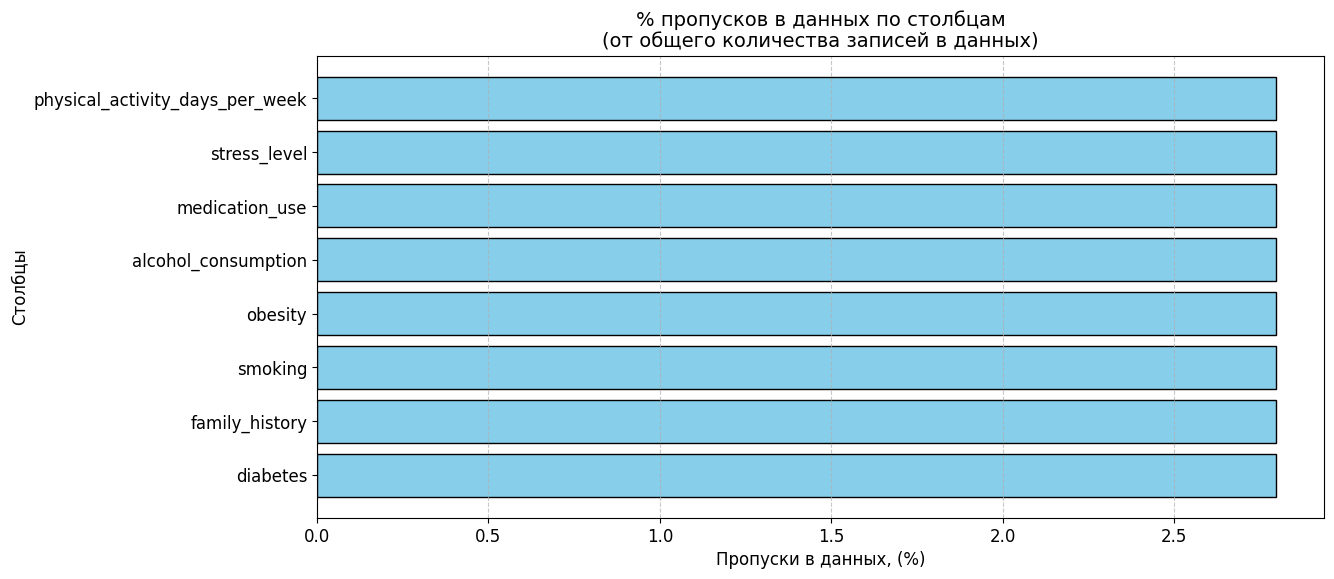

Доля пропусков по столбцам:


diabetes                           2.797927
family_history                     2.797927
smoking                            2.797927
obesity                            2.797927
alcohol_consumption                2.797927
medication_use                     2.797927
stress_level                       2.797927
physical_activity_days_per_week    2.797927
dtype: float64

In [22]:
# посмотрим количество пропусков в данных
plot_isna(heart)

**Комментарий**: наблюдается $\sim2.8%$ пропусков в данных. Проблема в том, что данные очень чувствительны и индивидуальны, массово заполнить мы их не сможем, т.к. это может исказить информацию. Проверим, все ли пропуски соответствуют одним и тем же строкам. В случае положительного результата -- удалим их.

In [23]:
# сформируем список столбцов, где найдены пропуски
na_cols = ['diabetes', 'family_history', 
           'smoking', 'obesity', 
           'alcohol_consumption',
           'medication_use', 'stress_level',
           'physical_activity_days_per_week']

# проверим, совпадают ли индексы пропусков
missing_mask = heart[na_cols].isna().any(axis=1)
print("Пропущено строк:", missing_mask.sum())

Пропущено строк: 243


**Комментарий**: пропуски в одних и тех же строках, удалим.

In [24]:
# если это одни и те же строки -- удаляем
if missing_mask.sum() <= missing_mask.sum():
    print("Размерность данных до удаления:", heart.shape)
    heart = heart.dropna(subset=na_cols)
    print("Размерность данных после удаления:", heart.shape)

Размерность данных до удаления: (8685, 23)
Размерность данных после удаления: (8442, 23)


In [25]:
# проверим наличие пропусков еще раз
plot_isna(heart)

Пропуски в данных отсутствуют.


**Промежуточный вывод**: было обнаружено и удалено **243** строки в данных с пропусками ($\sim2.8$%).

### Типы данных

**Комментарий**: проверим и исправим (при необходимости) типы данных в столбцах.

In [26]:
# выведем информацию о данных
dataset_info(heart)
# выведем информацию о кол-ве уникальных значений в столбцах
dataset_duplicates_info(heart)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8684
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8442 non-null   float64
 1   cholesterol                      8442 non-null   float64
 2   heart_rate                       8442 non-null   float64
 3   diabetes                         8442 non-null   float64
 4   family_history                   8442 non-null   float64
 5   smoking                          8442 non-null   float64
 6   obesity                          8442 non-null   float64
 7   alcohol_consumption              8442 non-null   float64
 8   exercise_hours_per_week          8442 non-null   float64
 9   diet                             8442 non-null   int64  
 10  medication_use                   8442 non-null   float64
 11  stress_level                     8442 non-null   float64
 

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,systolic_blood_pressure,diastolic_blood_pressure
count,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000
mean,0.449008,0.501108,0.050194,0.652097,0.489576,0.902867,0.498342,0.601990,0.503415,1.001540,0.501185,5.493367,0.499142,0.496089,0.496831,0.505539,3.508292,0.503712,0.356906,0.227998,0.451955,0.501672
std,0.232809,0.288785,0.018442,0.476333,0.499921,0.296157,0.500027,0.489517,0.288881,0.812981,0.500028,2.867862,0.289418,0.288767,0.286599,0.290412,2.281772,0.332749,0.479115,0.074623,0.170187,0.170302
min,0.044944,0.000000,0.018332,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.161290,0.209302
25%,0.247191,0.260714,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.253359,0.000000,0.000000,3.000000,0.247650,0.244591,0.247935,0.257143,2.000000,0.166667,0.000000,0.227018,0.303226,0.348837
50%,0.460674,0.496429,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.508244,1.000000,1.000000,5.000000,0.492734,0.496052,0.490801,0.507792,3.000000,0.500000,0.000000,0.227018,0.451613,0.500000
75%,0.640449,0.750000,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.754901,2.000000,1.000000,8.000000,0.751047,0.747603,0.744399,0.758442,6.000000,0.833333,1.000000,0.227018,0.600000,0.651163
max,0.853933,1.000000,0.082493,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,0.741935,0.790698


Первые 5 записей:


,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,gender,systolic_blood_pressure,diastolic_blood_pressure
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,Male,0.212903,0.709302
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,Female,0.412903,0.569767
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,Female,0.238710,0.220930
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,Female,0.348387,0.267442
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,Male,0.619355,0.441860


Последние 5 записей:


,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,gender,systolic_blood_pressure,diastolic_blood_pressure
8680,0.359551,0.357143,0.040330,1.0,0.0,1.0,1.0,1.0,0.926662,2,0.0,6.0,0.184825,0.412145,0.292379,0.222078,0.0,0.166667,0.0,0.136364,Male,0.632258,0.511628
8681,0.516854,0.832143,0.036664,1.0,1.0,1.0,1.0,1.0,0.455572,2,1.0,8.0,0.083490,0.295875,0.925992,0.396104,6.0,0.833333,0.0,0.195652,Male,0.561290,0.511628
8682,0.471910,0.067857,0.023831,1.0,0.0,1.0,0.0,1.0,0.076336,2,1.0,10.0,0.997170,0.378114,0.077175,0.189610,1.0,0.833333,0.0,0.227018,Male,0.374194,0.558140
8683,0.595506,0.000000,0.075160,0.0,1.0,1.0,0.0,1.0,0.371759,2,0.0,9.0,0.881231,0.554353,0.496346,0.892208,4.0,0.500000,0.0,0.227018,Male,0.477419,0.744186
8684,0.292135,0.342857,0.021082,0.0,1.0,1.0,1.0,0.0,0.567079,0,0.0,9.0,0.169786,0.753330,0.990535,0.975325,5.0,0.833333,0.0,0.227018,Male,0.703226,0.639535


Размерность данных: (8442, 23)
age                                  73
cholesterol                         281
heart_rate                           71
diabetes                              2
family_history                        2
smoking                               2
obesity                               2
alcohol_consumption                   2
exercise_hours_per_week            7932
diet                                  3
medication_use                        2
stress_level                         10
sedentary_hours_per_day            7932
income                             7807
bmi                                7932
triglycerides                       771
physical_activity_days_per_week       8
sleep_hours_per_day                   7
heart_attack_risk_binary              2
blood_sugar                         224
gender                                2
systolic_blood_pressure              91
diastolic_blood_pressure             51
dtype: int64
Количество явных дубликатов: 12


**Комментарий**: теоретически мы можем установить тип данных для столбцов `diabetes`, `family_history`, `smoking`, `obesity`, `alcohol_consumption`, `previous_heart_problems`, `medication_use`, `stress_level`, `physical_activity_days_per_week`, `heart_attack_risk_binary` к типу `int`, т.к. это целочисленные значения.

In [27]:
# сформируем список столбцов
int_cols = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 
           'medication_use', 'stress_level', 
           'physical_activity_days_per_week', 'heart_attack_risk_binary']

heart[int_cols] = heart[int_cols].astype(int)

In [28]:
# выведем информацию о данных
dataset_info(heart)

Общая информация о датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 8442 entries, 0 to 8684
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8442 non-null   float64
 1   cholesterol                      8442 non-null   float64
 2   heart_rate                       8442 non-null   float64
 3   diabetes                         8442 non-null   int64  
 4   family_history                   8442 non-null   int64  
 5   smoking                          8442 non-null   int64  
 6   obesity                          8442 non-null   int64  
 7   alcohol_consumption              8442 non-null   int64  
 8   exercise_hours_per_week          8442 non-null   float64
 9   diet                             8442 non-null   int64  
 10  medication_use                   8442 non-null   int64  
 11  stress_level                     8442 non-null   int64  
 

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,systolic_blood_pressure,diastolic_blood_pressure
count,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000
mean,0.449008,0.501108,0.050194,0.652097,0.489576,0.902867,0.498342,0.601990,0.503415,1.001540,0.501185,5.493367,0.499142,0.496089,0.496831,0.505539,3.508292,0.503712,0.356906,0.227998,0.451955,0.501672
std,0.232809,0.288785,0.018442,0.476333,0.499921,0.296157,0.500027,0.489517,0.288881,0.812981,0.500028,2.867862,0.289418,0.288767,0.286599,0.290412,2.281772,0.332749,0.479115,0.074623,0.170187,0.170302
min,0.044944,0.000000,0.018332,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.161290,0.209302
25%,0.247191,0.260714,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.253359,0.000000,0.000000,3.000000,0.247650,0.244591,0.247935,0.257143,2.000000,0.166667,0.000000,0.227018,0.303226,0.348837
50%,0.460674,0.496429,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.508244,1.000000,1.000000,5.000000,0.492734,0.496052,0.490801,0.507792,3.000000,0.500000,0.000000,0.227018,0.451613,0.500000
75%,0.640449,0.750000,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.754901,2.000000,1.000000,8.000000,0.751047,0.747603,0.744399,0.758442,6.000000,0.833333,1.000000,0.227018,0.600000,0.651163
max,0.853933,1.000000,0.082493,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,0.741935,0.790698


Первые 5 записей:


,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,gender,systolic_blood_pressure,diastolic_blood_pressure
0,0.359551,0.732143,0.074244,1,1,1,1,1,0.535505,1,0,8,0.225704,0.105948,0.459176,0.979221,3,0.333333,0,0.227018,Male,0.212903,0.709302
1,0.202247,0.325000,0.047663,1,1,0,0,1,0.068690,2,0,9,0.289923,0.164217,0.117053,0.515584,3,0.833333,0,0.150198,Female,0.412903,0.569767
2,0.606742,0.860714,0.055912,1,0,1,1,1,0.944001,2,1,6,0.550133,0.598745,0.373574,0.012987,2,1.000000,0,0.227018,Female,0.238710,0.220930
3,0.730337,0.007143,0.053162,0,0,1,0,1,0.697023,0,1,3,0.330962,0.077605,0.049735,0.131169,0,0.333333,1,0.227018,Female,0.348387,0.267442
4,0.775281,0.757143,0.021998,0,0,1,0,1,0.412878,1,0,8,0.524600,0.341960,0.830405,0.070130,5,1.000000,1,0.227018,Male,0.619355,0.441860


Последние 5 записей:


,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,gender,systolic_blood_pressure,diastolic_blood_pressure
8680,0.359551,0.357143,0.040330,1,0,1,1,1,0.926662,2,0,6,0.184825,0.412145,0.292379,0.222078,0,0.166667,0,0.136364,Male,0.632258,0.511628
8681,0.516854,0.832143,0.036664,1,1,1,1,1,0.455572,2,1,8,0.083490,0.295875,0.925992,0.396104,6,0.833333,0,0.195652,Male,0.561290,0.511628
8682,0.471910,0.067857,0.023831,1,0,1,0,1,0.076336,2,1,10,0.997170,0.378114,0.077175,0.189610,1,0.833333,0,0.227018,Male,0.374194,0.558140
8683,0.595506,0.000000,0.075160,0,1,1,0,1,0.371759,2,0,9,0.881231,0.554353,0.496346,0.892208,4,0.500000,0,0.227018,Male,0.477419,0.744186
8684,0.292135,0.342857,0.021082,0,1,1,1,0,0.567079,0,0,9,0.169786,0.753330,0.990535,0.975325,5,0.833333,0,0.227018,Male,0.703226,0.639535


**Промежуточный вывод**: данные в столбцах `diabetes`, `family_history`, `smoking`, `obesity`, `alcohol_consumption`, `previous_heart_problems`, `medication_use`, `stress_level`, `physical_activity_days_per_week`, `heart_attack_risk_binary` приведены к типу `int`, т.к. это целочисленные значения.

### Дубликаты в данных

**Комментарий**: проверим данные на наличие явных дубликатов.

In [29]:
# информация о дубликатах
dataset_duplicates_info(heart)

Размерность данных: (8442, 23)
age                                  73
cholesterol                         281
heart_rate                           71
diabetes                              2
family_history                        2
smoking                               2
obesity                               2
alcohol_consumption                   2
exercise_hours_per_week            7932
diet                                  3
medication_use                        2
stress_level                         10
sedentary_hours_per_day            7932
income                             7807
bmi                                7932
triglycerides                       771
physical_activity_days_per_week       8
sleep_hours_per_day                   7
heart_attack_risk_binary              2
blood_sugar                         224
gender                                2
systolic_blood_pressure              91
diastolic_blood_pressure             51
dtype: int64
Количество явных дубликатов: 12


**Комментарий**: обнаружено **12** явных дубликатов.

In [30]:
# выведем дубликаты, т.к. их немного
get_duplicated_data(heart).sort_values('age')

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,gender,systolic_blood_pressure,diastolic_blood_pressure
483,0.404494,0.482143,0.066911,1,0,1,1,0,0.871135,0,0,9,0.882496,0.686997,0.367145,0.985714,6,0.666667,0,0.274704,Female,0.258065,0.755814
685,0.404494,0.028571,0.066911,1,1,1,0,1,0.443074,0,0,1,0.393382,0.729860,0.257433,0.298701,6,0.500000,0,0.274704,Female,0.206452,0.290698
2108,0.404494,0.971429,0.066911,1,0,1,1,0,0.070743,1,1,2,0.077256,0.567258,0.004743,0.058442,6,0.500000,0,0.274704,Female,0.483871,0.337209
2645,0.404494,0.482143,0.066911,1,0,1,1,0,0.871135,0,0,9,0.882496,0.686997,0.367145,0.985714,6,0.666667,0,0.274704,Female,0.258065,0.755814
4686,0.404494,0.425000,0.066911,1,0,1,0,1,0.870237,0,0,6,0.059238,0.193575,0.492952,0.461039,2,0.333333,0,0.274704,Male,0.232258,0.220930
4410,0.404494,0.028571,0.066911,1,1,1,0,1,0.443074,0,0,1,0.393382,0.729860,0.257433,0.298701,6,0.500000,0,0.274704,Female,0.206452,0.290698
8348,0.404494,0.425000,0.066911,1,0,1,0,1,0.870237,0,0,6,0.059238,0.193575,0.492952,0.461039,2,0.333333,0,0.274704,Male,0.232258,0.220930
7773,0.404494,0.971429,0.066911,1,0,1,1,0,0.070743,1,1,2,0.077256,0.567258,0.004743,0.058442,6,0.500000,0,0.274704,Female,0.483871,0.337209
5203,0.516854,0.464286,0.063245,1,1,1,0,1,0.159094,2,1,7,0.573992,0.500036,0.561674,0.088312,4,0.000000,1,0.114625,Female,0.690323,0.372093
7828,0.516854,0.464286,0.063245,1,1,1,0,1,0.159094,2,1,7,0.573992,0.500036,0.561674,0.088312,4,0.000000,1,0.114625,Female,0.690323,0.372093


**Комментарий**: удалим обнаруженные явные дубликаты.

In [31]:
# вызовем метод удаления явных дубликатов
remove_duplicated_data(heart)

Размерность данных до удаления дубликатов: (8442, 23)
Удалено дубликатов: 12
Размерность данных после удаления дубликатов: (8430, 23)


In [32]:
# выведем снова информацию о дубликатах
dataset_duplicates_info(heart)

Размерность данных: (8430, 23)
age                                  73
cholesterol                         281
heart_rate                           71
diabetes                              2
family_history                        2
smoking                               2
obesity                               2
alcohol_consumption                   2
exercise_hours_per_week            7932
diet                                  3
medication_use                        2
stress_level                         10
sedentary_hours_per_day            7932
income                             7807
bmi                                7932
triglycerides                       771
physical_activity_days_per_week       8
sleep_hours_per_day                   7
heart_attack_risk_binary              2
blood_sugar                         224
gender                                2
systolic_blood_pressure              91
diastolic_blood_pressure             51
dtype: int64
Количество явных дубликатов: 0


**Промежуточный вывод**: удалено **12** явных дубликатов.

### Промежуточный вывод

Выполнена предварительная обработка данных:

1. Выполнен первичный отбор признаков: признаки `CK-MB` и `Troponin` убраны, т.к. они являются не воспроизводимыми, признак `id` убран, т.к. он неинформативен и признак `Previous Heart Problems` убран, т.к. это потенциальная утечка;
2. Выполнено переименование столбцов с приведением к `snake_case` формату.
3. В данных обнаружено и удалено **243** строки с пропусками ($\sim2.8$% от общего кол-ва записей);
4. Данные в столбцах `diabetes`, `family_history`, `smoking`, `obesity`, `alcohol_consumption`, `previous_heart_problems`, `medication_use`, `stress_level`, `physical_activity_days_per_week`, `heart_attack_risk_binary` приведены к типу `int`, т.к. это целочисленные значения;
5. В данных обнаружено и удалено **12** явных дубликатов.

## <u>Исследовательский анализ данных</u>

**Комментарий**: теперь проведем исследовательский анализ данных, в том числе на предмет аномальных и некорректных значений. Также пронализируем их связь и распределение по целевому признаку.

В данных присутствуют следующие типы признаков:

***Количественные***:
- `age` -- возраст пациента
- `cholesterol` -- уровень холестерина в крови пациента 
- `heart_rate` -- пульс пациента
- `exercise_hours_per_week` -- количество часов физических упражнений в неделю
- `sedentary_hours_per_day` -- сколько часов в день проводит пациент в сидячем положении
- `income` -- уровень дохода пациента
- `bmi` -- ИМТ -- индекс массы тела пациента
- `triglycerides` -- уровень триглициридов в крови пациента
- `physical_activity_days_per_week` -- количество дней в неделю с физической активностью
- `sleep_hours_per_day` -- количество часов сна в сутки
- `blood_sugar` -- уровень сахара в крови пациента
- `systolic_blood_pressure` -- cистолическое артериальное давление пациента
- `diastolic_blood_pressure` -- диастолическое артериальное давление пациента

***Категориальные***:
- `diabetes` -- наличие у пациента диагностированного диабета
- `family_history` -- были ли проблемы с сердцем у родственников пациента
- `smoking` -- является ли пациент курильщиком
- `obesity` -- страдает ли пациент от ожирения
- `alcohol_consumption` -- употребление алкоголя пациентом
- `diet` -- какая у пациента диета/питание
- `medication_use` -- принимает ли пациент лекарственные препараты
- `stress_level` -- уровень стресса пациента
- `gender` -- пол пациента

**Целевой признак**:
- `heart_attack_risk_binary` -- риск сердечного приступа у пациента **целевой признак**

### Количественные признаки

**Комментарий**: рассмотрим сначала количественные признаки:

- `age` -- возраст пациента
- `cholesterol` -- уровень холестерина в крови пациента 
- `heart_rate` -- пульс пациента
- `exercise_hours_per_week` -- количество часов физических упражнений в неделю
- `sedentary_hours_per_day` -- сколько часов в день проводит пациент в сидячем положении
- `income` -- уровень дохода пациента
- `bmi` -- ИМТ -- индекс массы тела пациента
- `triglycerides` -- уровень триглициридов в крови пациента
- `physical_activity_days_per_week` -- количество дней в неделю с физической активностью
- `sleep_hours_per_day` -- количество часов сна в сутки
- `blood_sugar` -- уровень сахара в крови пациента
- `systolic_blood_pressure` -- cистолическое артериальное давление пациента
- `diastolic_blood_pressure` -- диастолическое артериальное давление пациента

#### Признак `age`

**Комментарий**: исследуем признак `age` -- возраст пациента.

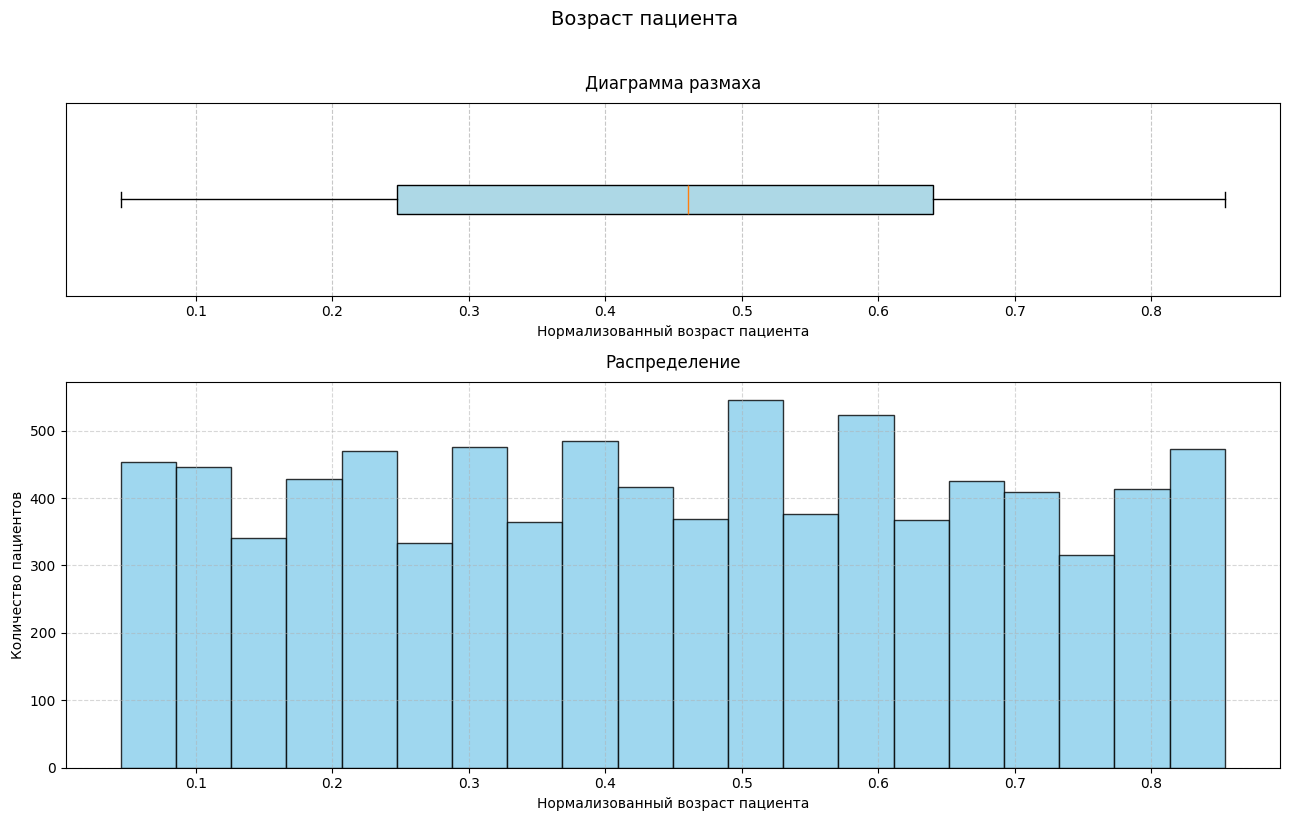

count    8430.000000
mean        0.448878
std         0.232903
min         0.044944
25%         0.247191
50%         0.460674
75%         0.640449
max         0.853933
Name: age, dtype: float64

In [33]:
# выведем график распределения
plot_data_analysis(heart['age'],
                   title='Возраст пациента',
                   x_label='Нормализованный возраст пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

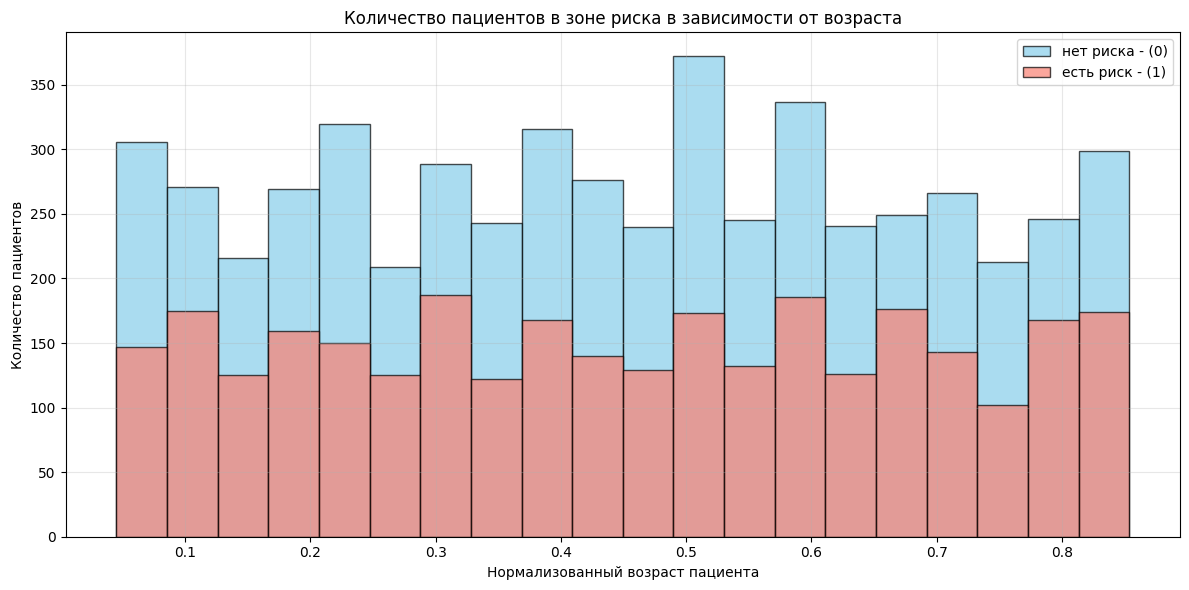

Статистика по age:
Уникальных значений: 73

Средние значения:

Средние значения:
Без риска: 0.447617
С риском: 0.451153
Разница средних (риск - нет риска): 0.003536
Относительная разница: 0.79%


In [34]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'age', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от возраста',
                       x_label='Нормализованный возраст пациента',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**:

#### Признак `cholesterol`

**Комментарий**: исследуем признак `cholesterol` -- уровень холестерина в крови пациента 

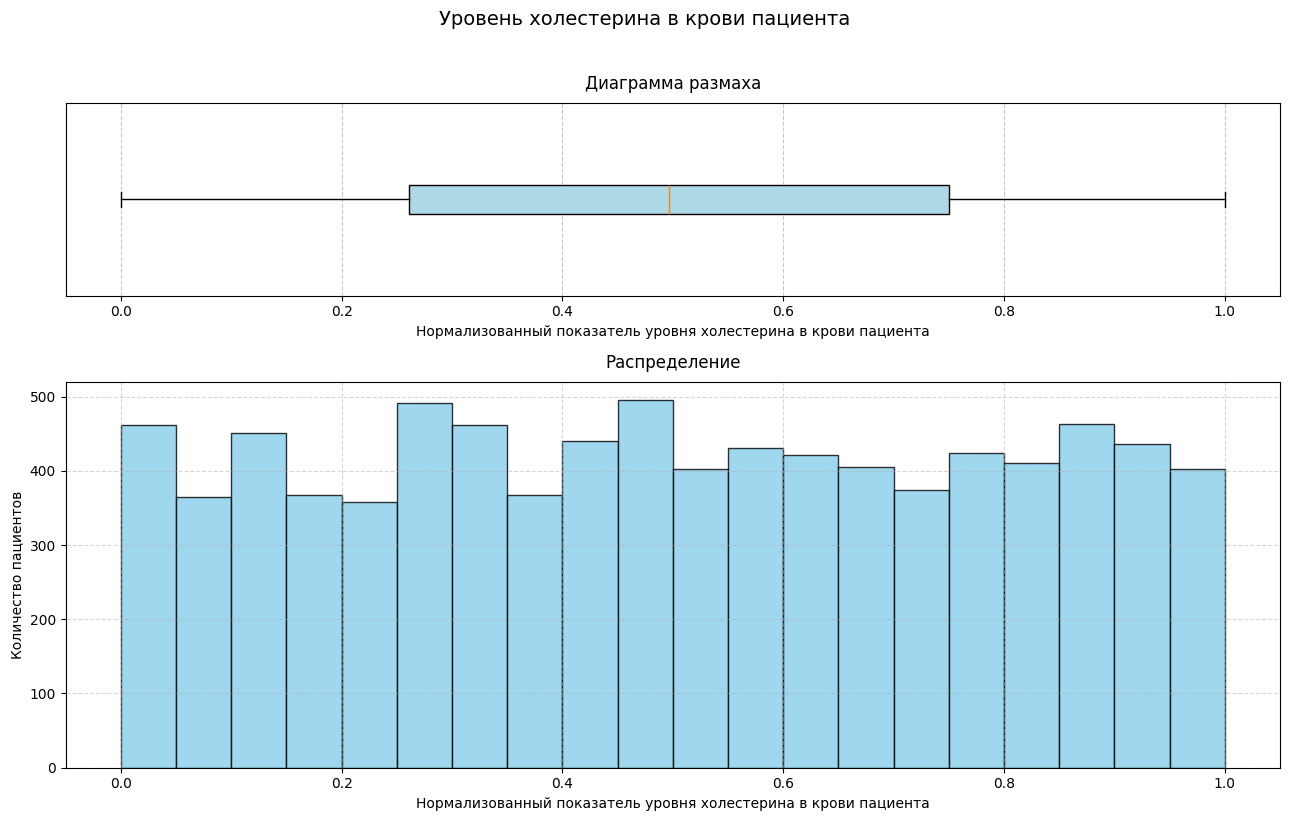

count    8430.000000
mean        0.501114
std         0.288786
min         0.000000
25%         0.260714
50%         0.496429
75%         0.750000
max         1.000000
Name: cholesterol, dtype: float64

In [35]:
# выведем график распределения
plot_data_analysis(heart['cholesterol'],
                   title='Уровень холестерина в крови пациента',
                   x_label='Нормализованный показатель уровня холестерина в крови пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

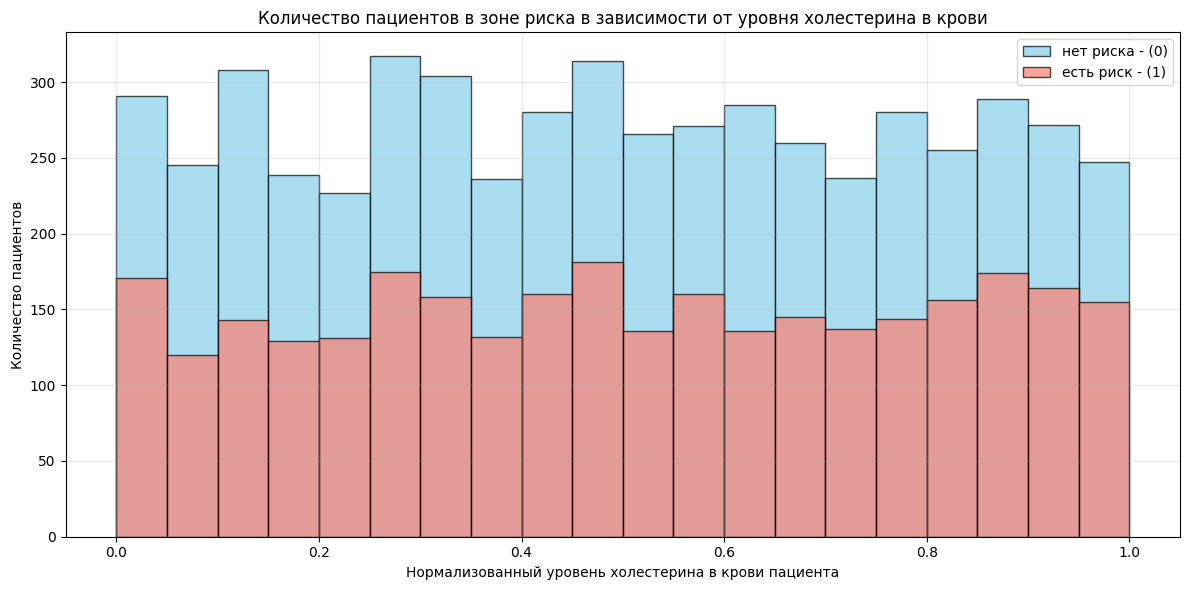

Статистика по cholesterol:
Уникальных значений: 281

Средние значения:

Средние значения:
Без риска: 0.497042
С риском: 0.508459
Разница средних (риск - нет риска): 0.011417
Относительная разница: 2.30%


In [36]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'cholesterol', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от уровня холестерина в крови',
                       x_label='Нормализованный уровень холестерина в крови пациента',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**:

#### Признак `heart_rate`

**Комментарий**: исследуем признак `heart_rate` -- пульс пациента.

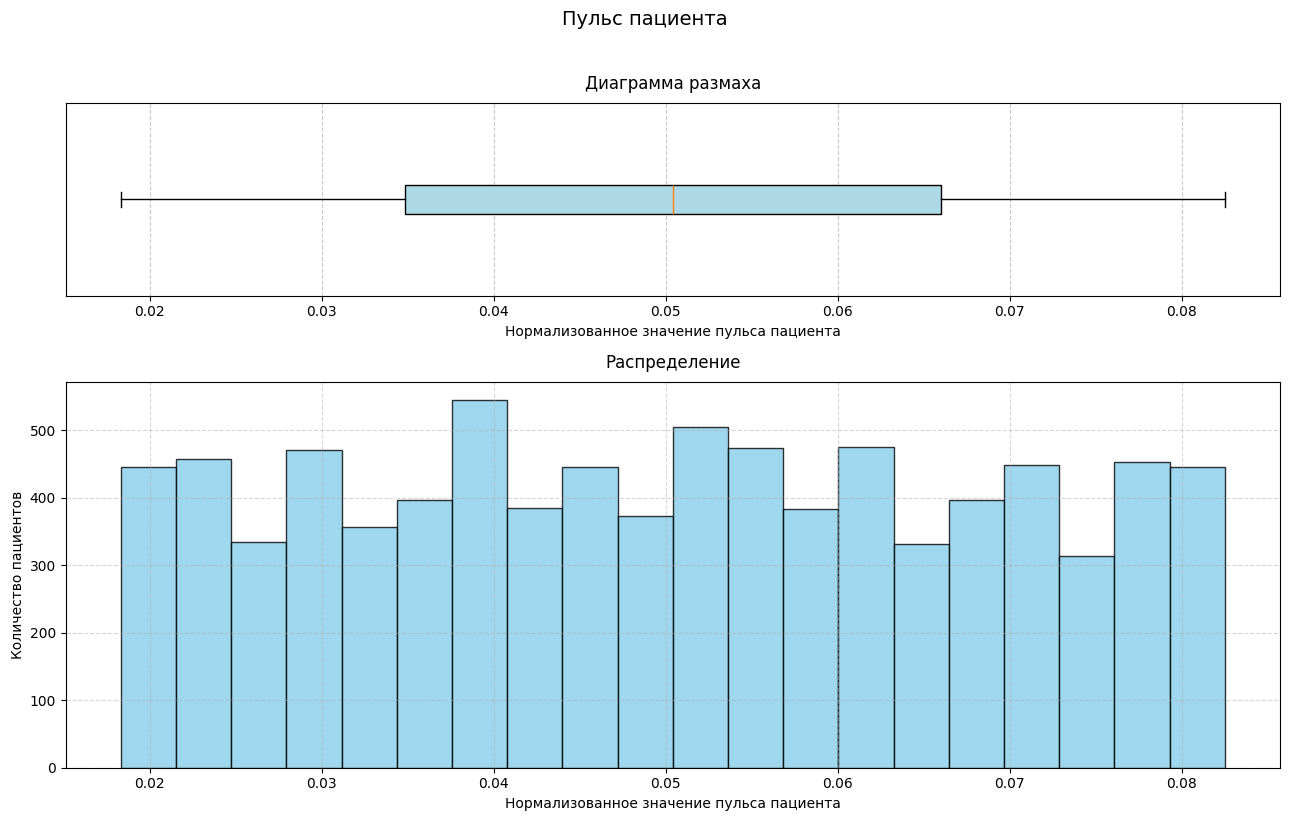

count    8430.000000
mean        0.050189
std         0.018447
min         0.018332
25%         0.034830
50%         0.050412
75%         0.065995
max         0.082493
Name: heart_rate, dtype: float64

In [37]:
# выведем график распределения
plot_data_analysis(heart['heart_rate'],
                   title='Пульс пациента',
                   x_label='Нормализованное значение пульса пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

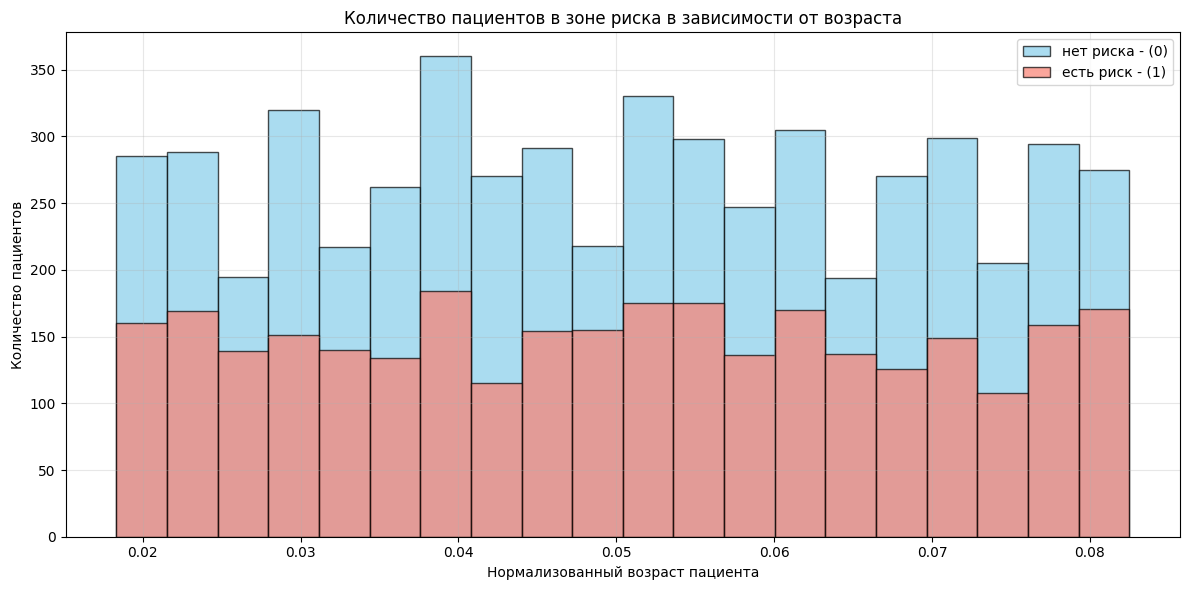

Статистика по heart_rate:
Уникальных значений: 71

Средние значения:

Средние значения:
Без риска: 0.050207
С риском: 0.050156
Разница средних (риск - нет риска): -0.000051
Относительная разница: -0.10%


In [38]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'heart_rate', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от возраста',
                       x_label='Нормализованный возраст пациента',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**:

#### Признак `exercise_hours_per_week`

**Комментарий**: исследуем признак `exercise_hours_per_week` -- количество часов физических упражнений в неделю.

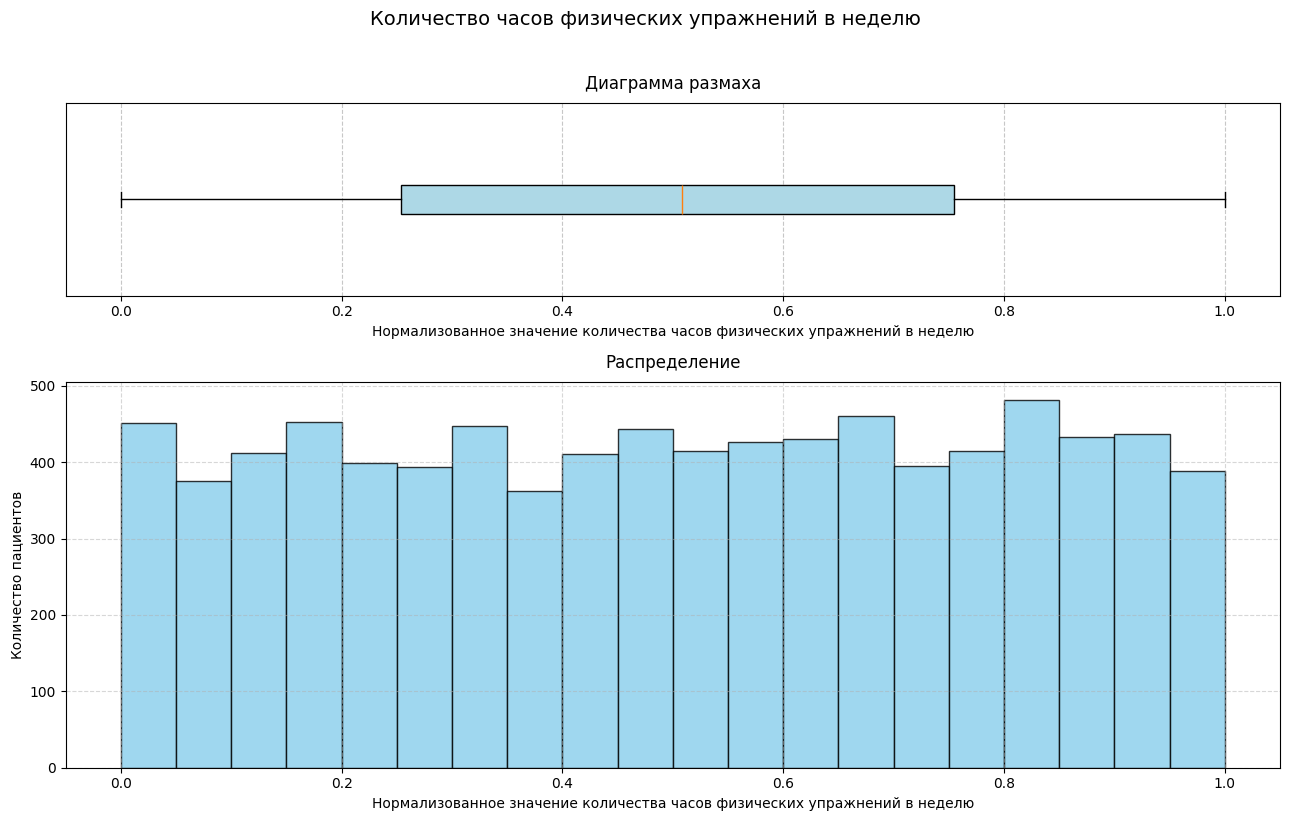

count    8430.000000
mean        0.503397
std         0.288867
min         0.000000
25%         0.253462
50%         0.508178
75%         0.754854
max         1.000000
Name: exercise_hours_per_week, dtype: float64

In [39]:
# выведем график распределения
plot_data_analysis(heart['exercise_hours_per_week'],
                   title='Количество часов физических упражнений в неделю',
                   x_label='Нормализованное значение количества часов физических упражнений в неделю',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

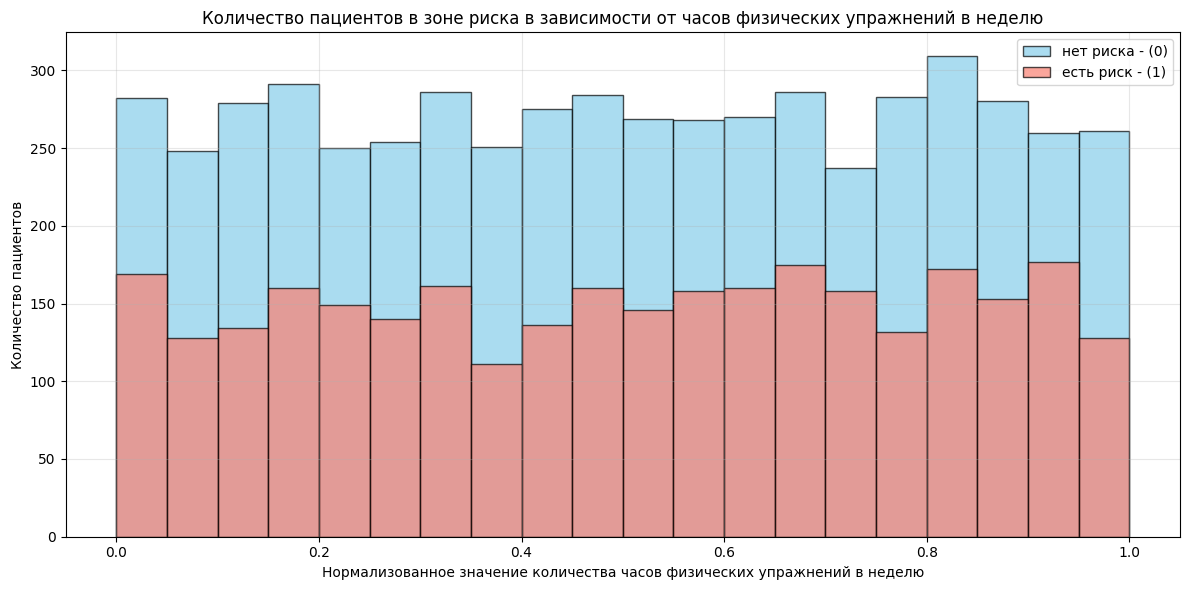

Статистика по exercise_hours_per_week:
Уникальных значений: 7932

Средние значения:

Средние значения:
Без риска: 0.501264
С риском: 0.507244
Разница средних (риск - нет риска): 0.005980
Относительная разница: 1.19%


In [40]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'exercise_hours_per_week', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от часов физических упражнений в неделю',
                       x_label='Нормализованное значение количества часов физических упражнений в неделю',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**:

#### Признак `sedentary_hours_per_day`

**Комментарий**: исследуем признак `sedentary_hours_per_day` -- сколько часов в день проводит пациент в сидячем положении.

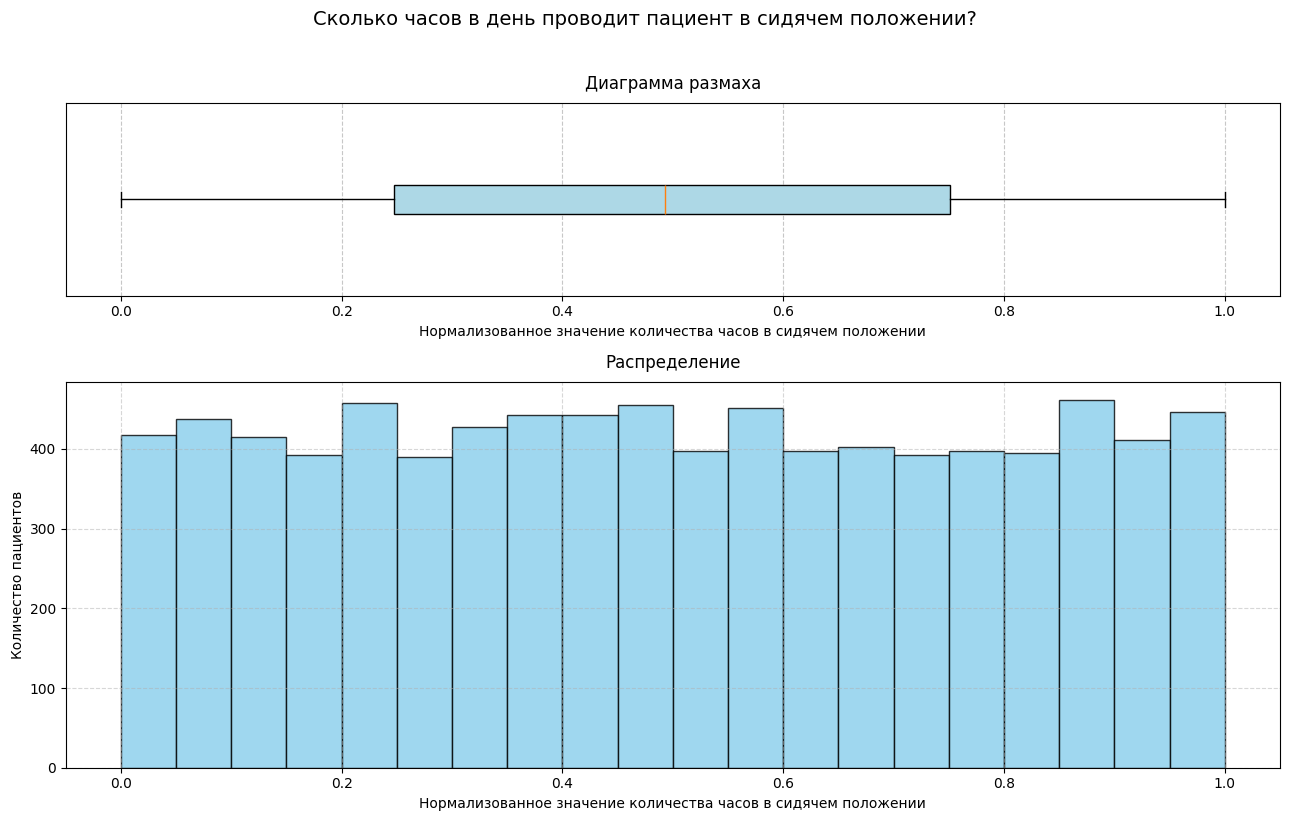

count    8430.000000
mean        0.499073
std         0.289362
min         0.000000
25%         0.247650
50%         0.492500
75%         0.750919
max         1.000000
Name: sedentary_hours_per_day, dtype: float64

In [41]:
# выведем график распределения
plot_data_analysis(heart['sedentary_hours_per_day'],
                   title='Сколько часов в день проводит пациент в сидячем положении?',
                   x_label='Нормализованное значение количества часов в сидячем положении',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

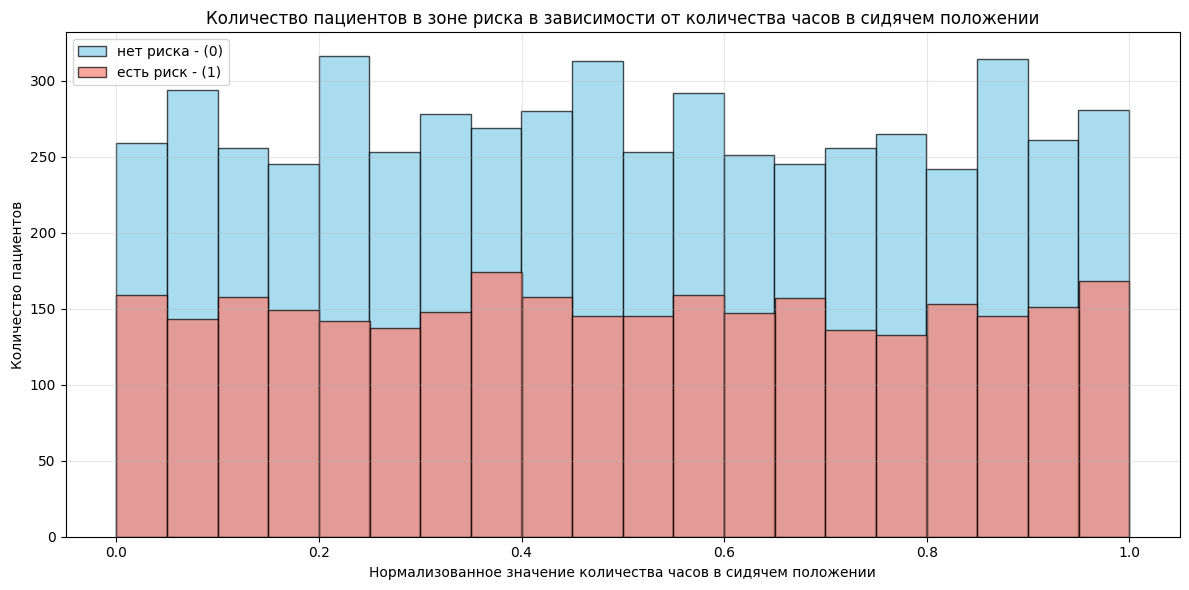

Статистика по sedentary_hours_per_day:
Уникальных значений: 7932

Средние значения:

Средние значения:
Без риска: 0.498853
С риском: 0.499470
Разница средних (риск - нет риска): 0.000617
Относительная разница: 0.12%


In [42]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'sedentary_hours_per_day', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от количества часов в сидячем положении',
                       x_label='Нормализованное значение количества часов в сидячем положении',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**:

#### Признак `income`

**Комментарий**: исследуем признак `income` -- уровень дохода пациента.

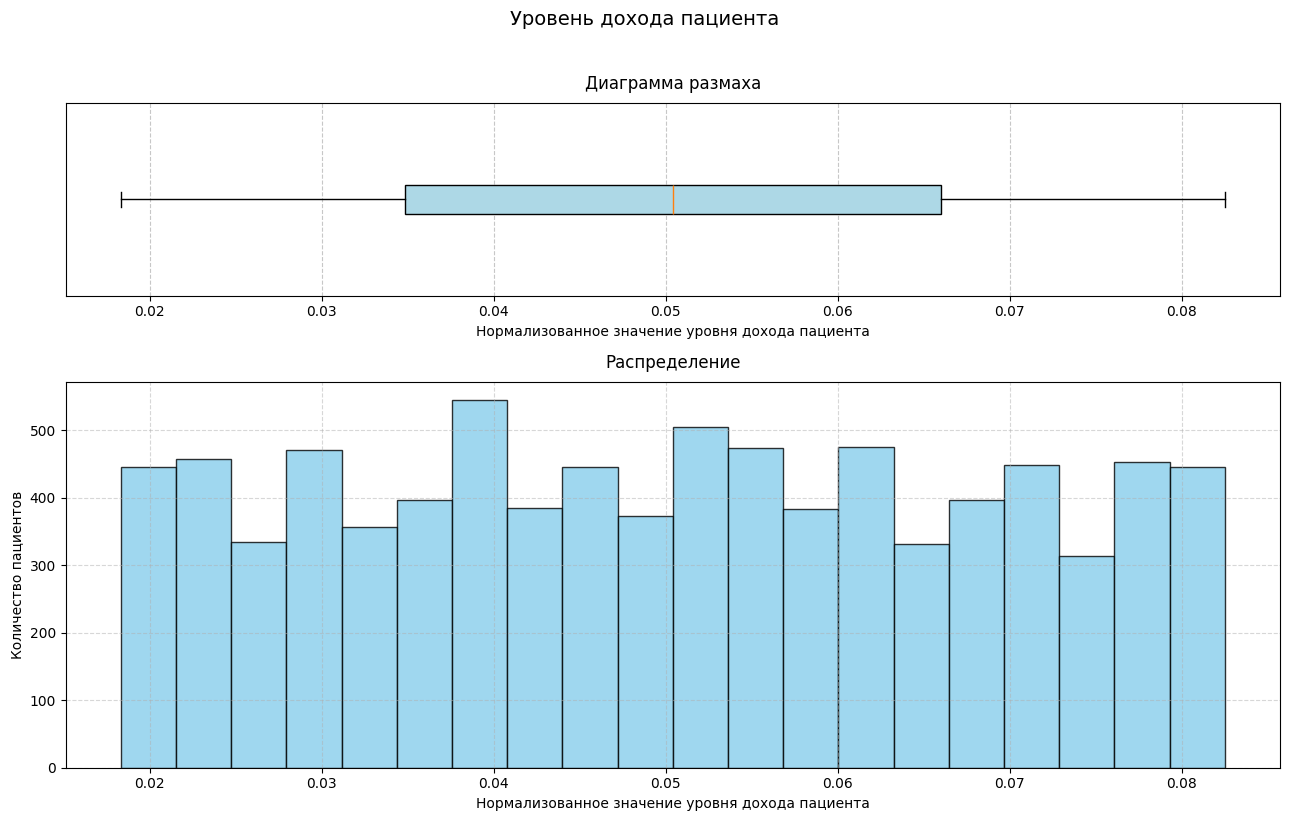

count    8430.000000
mean        0.050189
std         0.018447
min         0.018332
25%         0.034830
50%         0.050412
75%         0.065995
max         0.082493
Name: heart_rate, dtype: float64

In [43]:
# выведем график распределения
plot_data_analysis(heart['heart_rate'],
                   title='Уровень дохода пациента',
                   x_label='Нормализованное значение уровня дохода пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

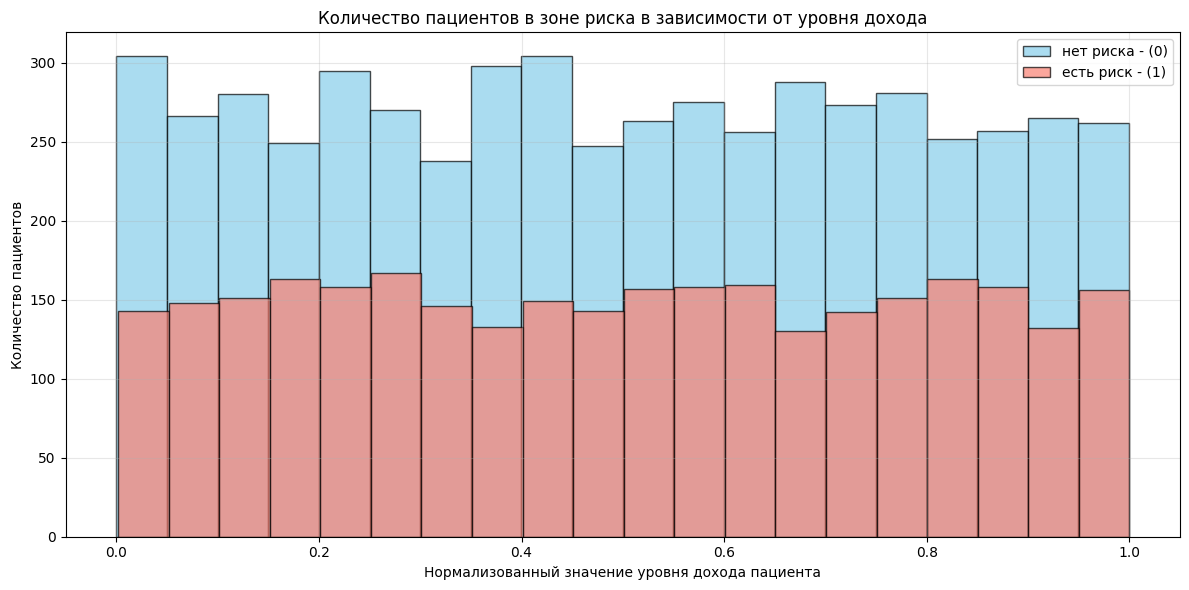

Статистика по income:
Уникальных значений: 7807

Средние значения:

Средние значения:
Без риска: 0.494301
С риском: 0.499206
Разница средних (риск - нет риска): 0.004905
Относительная разница: 0.99%


In [44]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'income', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от уровня дохода',
                       x_label='Нормализованный значение уровня дохода пациента',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**:

#### Признак `bmi`

**Комментарий**: исследуем признак `bmi` -- ИМТ -- индекс массы тела пациента.

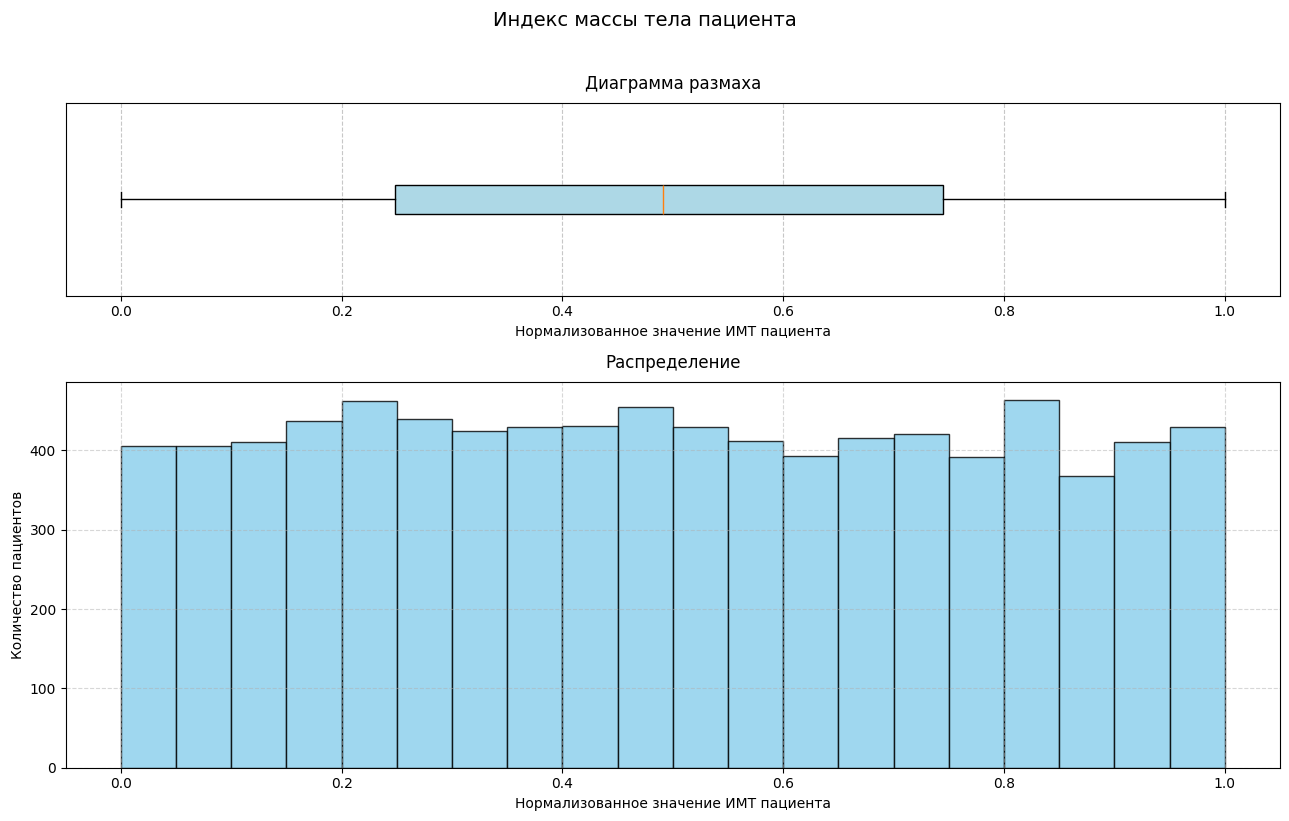

count    8430.000000
mean        0.497023
std         0.286637
min         0.000000
25%         0.248032
50%         0.490867
75%         0.744620
max         1.000000
Name: bmi, dtype: float64

In [45]:
# выведем график распределения
plot_data_analysis(heart['bmi'],
                   title='Индекс массы тела пациента',
                   x_label='Нормализованное значение ИМТ пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

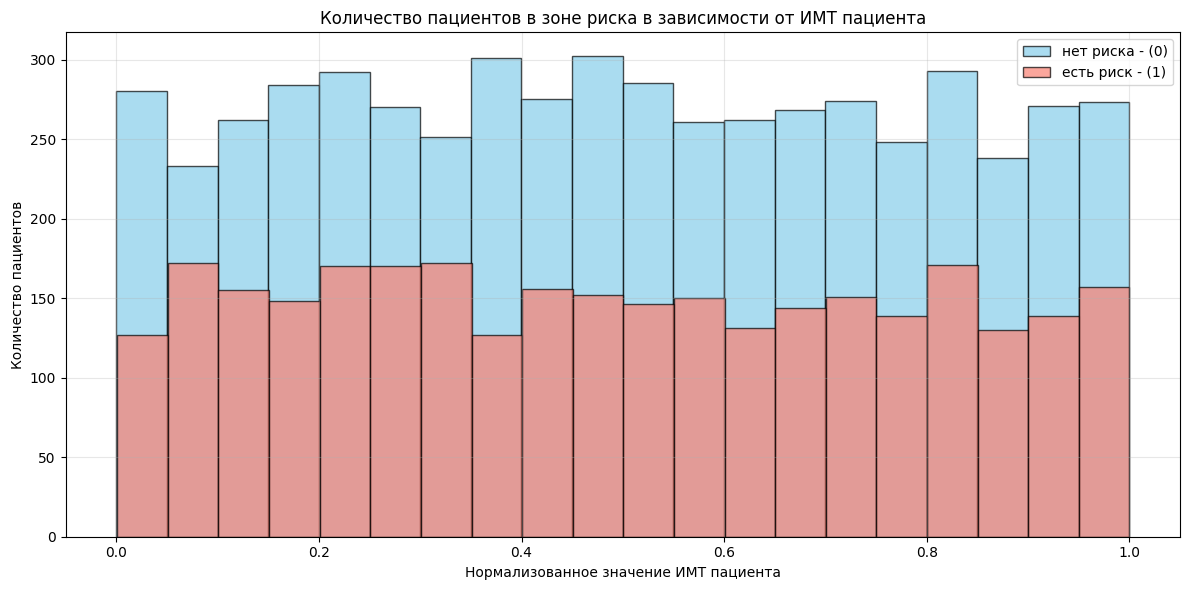

Статистика по bmi:
Уникальных значений: 7932

Средние значения:

Средние значения:
Без риска: 0.498483
С риском: 0.494389
Разница средних (риск - нет риска): -0.004093
Относительная разница: -0.82%


In [46]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'bmi', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от ИМТ пациента',
                       x_label='Нормализованное значение ИМТ пациента',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**:

#### Признак `triglycerides`

**Комментарий**: исследуем признак `triglycerides` -- уровень триглициридов в крови пациента.

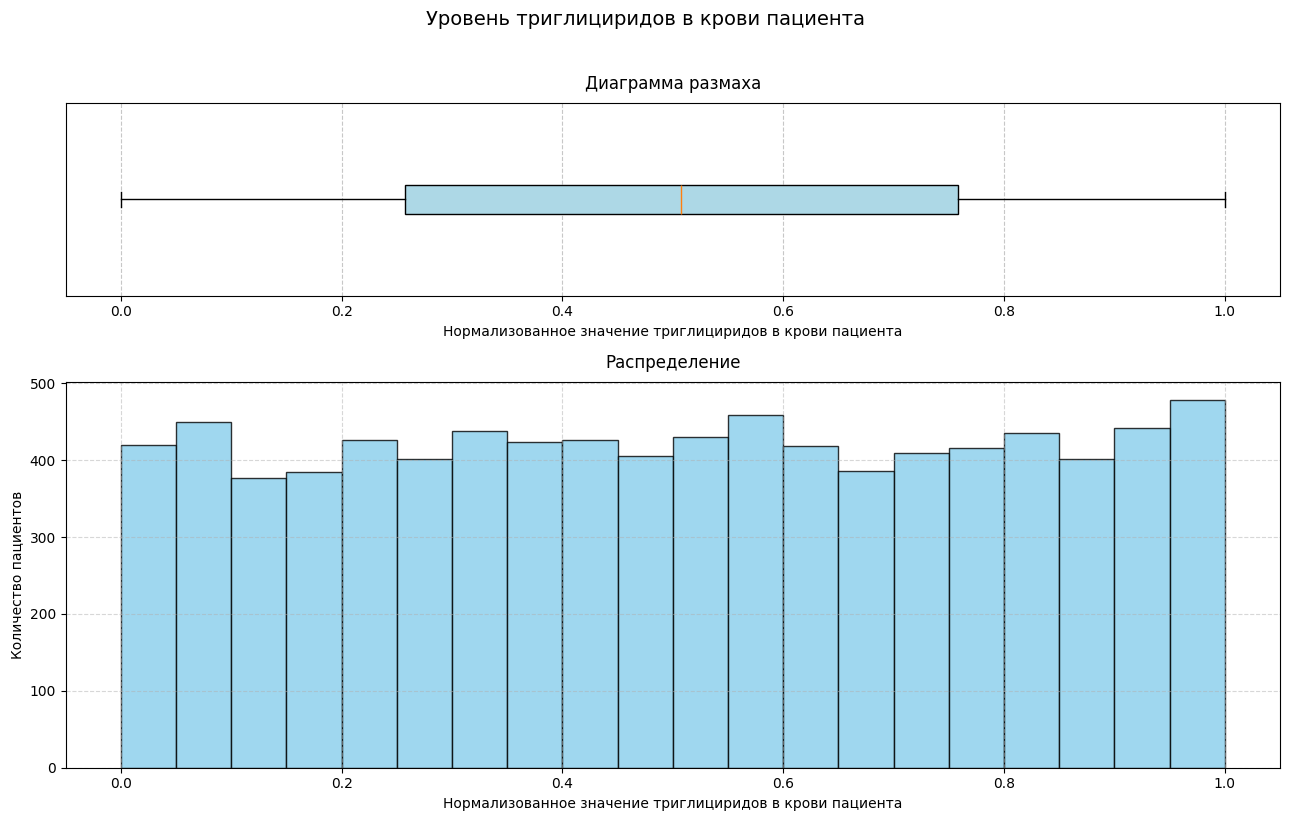

count    8430.000000
mean        0.505538
std         0.290354
min         0.000000
25%         0.257143
50%         0.507792
75%         0.758442
max         1.000000
Name: triglycerides, dtype: float64

In [47]:
# выведем график распределения
plot_data_analysis(heart['triglycerides'],
                   title='Уровень триглициридов в крови пациента',
                   x_label='Нормализованное значение триглициридов в крови пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

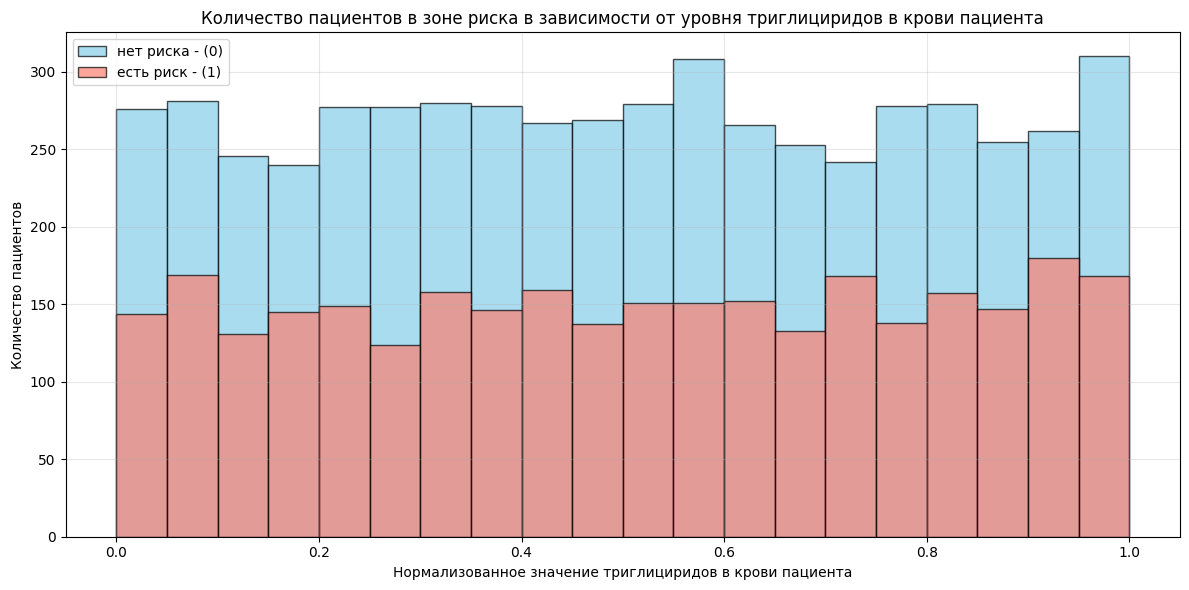

Статистика по triglycerides:
Уникальных значений: 771

Средние значения:

Средние значения:
Без риска: 0.502975
С риском: 0.510161
Разница средних (риск - нет риска): 0.007186
Относительная разница: 1.43%


In [48]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'triglycerides', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от уровня триглициридов в крови пациента',
                       x_label='Нормализованное значение триглициридов в крови пациента',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**:

#### Признак `physical_activity_days_per_week`

**Комментарий**: исследуем признак `physical_activity_days_per_week` -- количество дней в неделю с физической активностью.

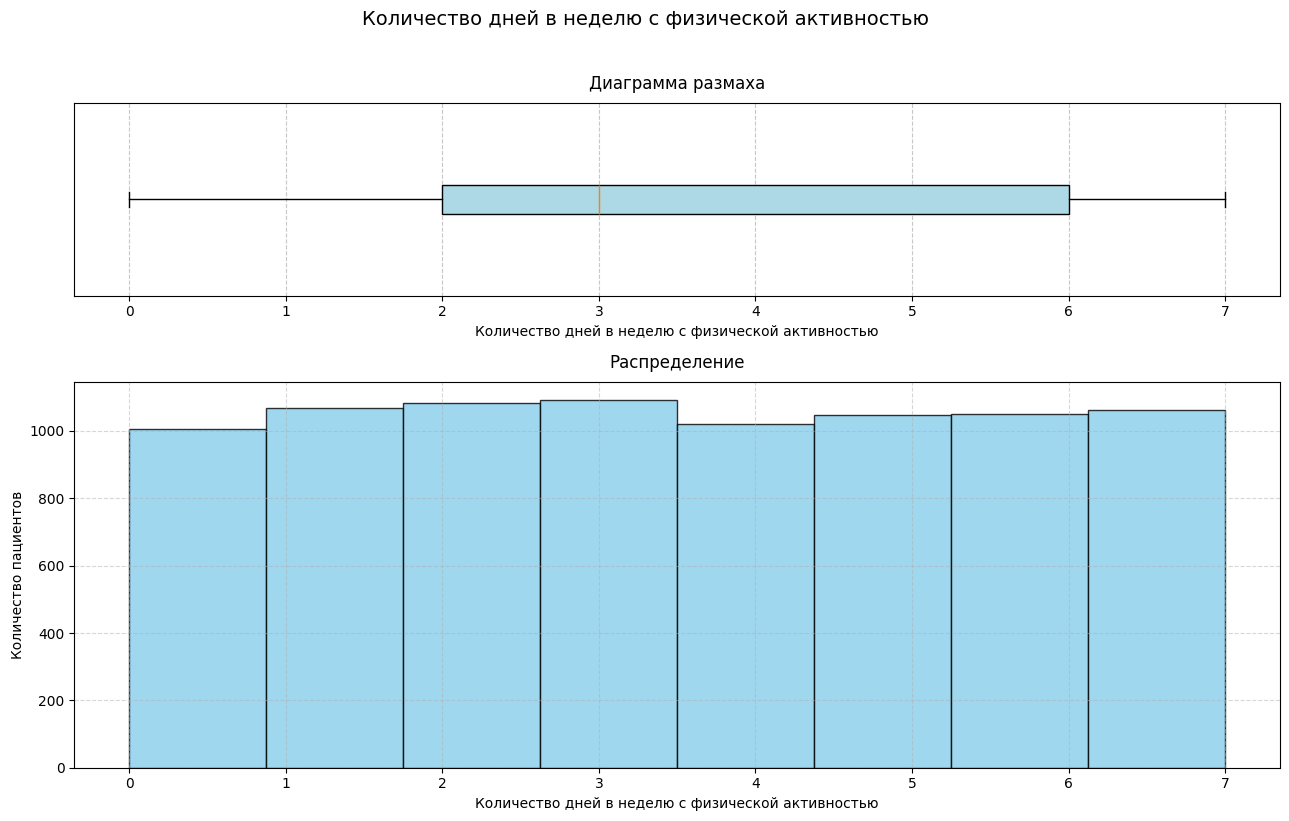

count    8430.000000
mean        3.507473
std         2.281917
min         0.000000
25%         2.000000
50%         3.000000
75%         6.000000
max         7.000000
Name: physical_activity_days_per_week, dtype: float64

In [49]:
# выведем график распределения
plot_data_analysis(heart['physical_activity_days_per_week'],
                   title='Количество дней в неделю с физической активностью',
                   x_label='Количество дней в неделю с физической активностью',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=8
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

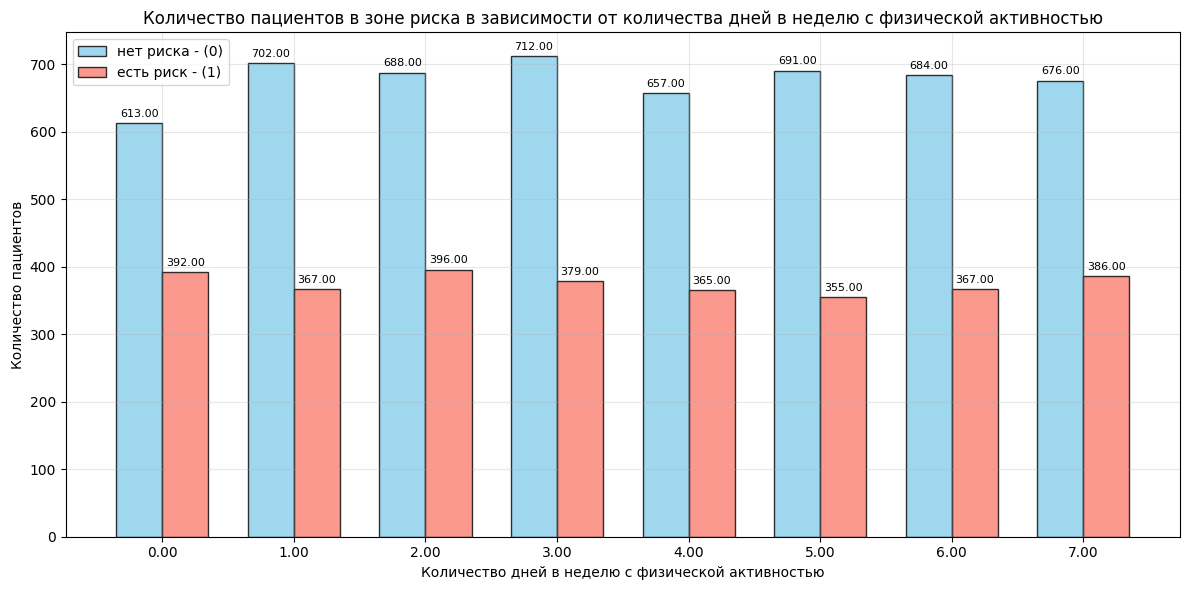

Статистика по physical_activity_days_per_week:
Уникальных значений: 8

Средние значения:

Средние значения:
Без риска: 3.528121
С риском: 3.470236

Доли риска по категориям physical_activity_days_per_week:
  0: 39.0%
  1: 34.3%
  2: 36.5%
  3: 34.7%
  4: 35.7%
  5: 33.9%
  6: 34.9%
  7: 36.3%


In [50]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'physical_activity_days_per_week', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости ' \
                       'от количества дней в неделю с физической активностью',
                       x_label='Количество дней в неделю с физической активностью',
                       y_label='Количество пациентов',
                       bins=8
                       )

**Промежуточный вывод**:

#### Признак `sleep_hours_per_day`

**Комментарий**: исследуем признак `sleep_hours_per_day` -- количество часов сна в сутки.

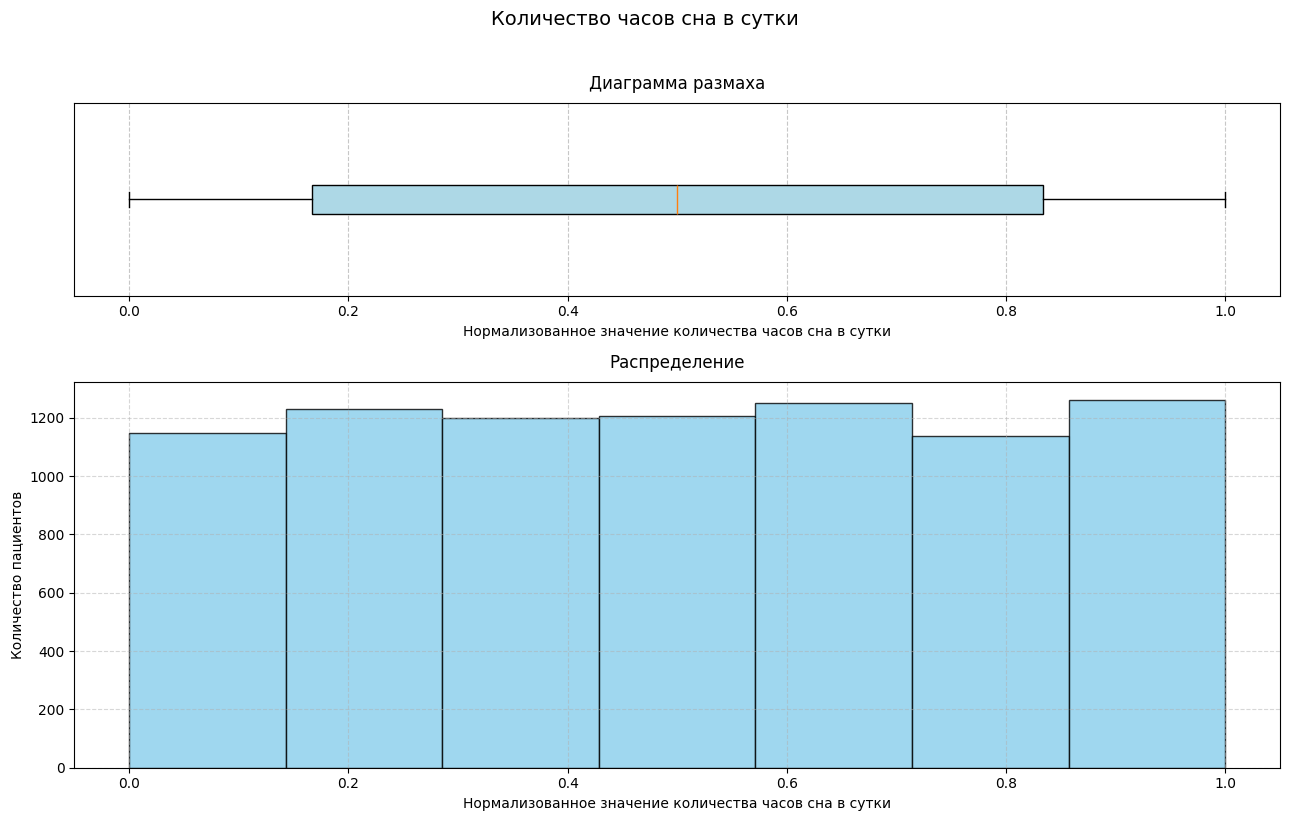

count    8430.000000
mean        0.503934
std         0.332692
min         0.000000
25%         0.166667
50%         0.500000
75%         0.833333
max         1.000000
Name: sleep_hours_per_day, dtype: float64

In [51]:
# выведем график распределения
plot_data_analysis(heart['sleep_hours_per_day'],
                   title='Количество часов сна в сутки',
                   x_label='Нормализованное значение количества часов сна в сутки',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=7
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

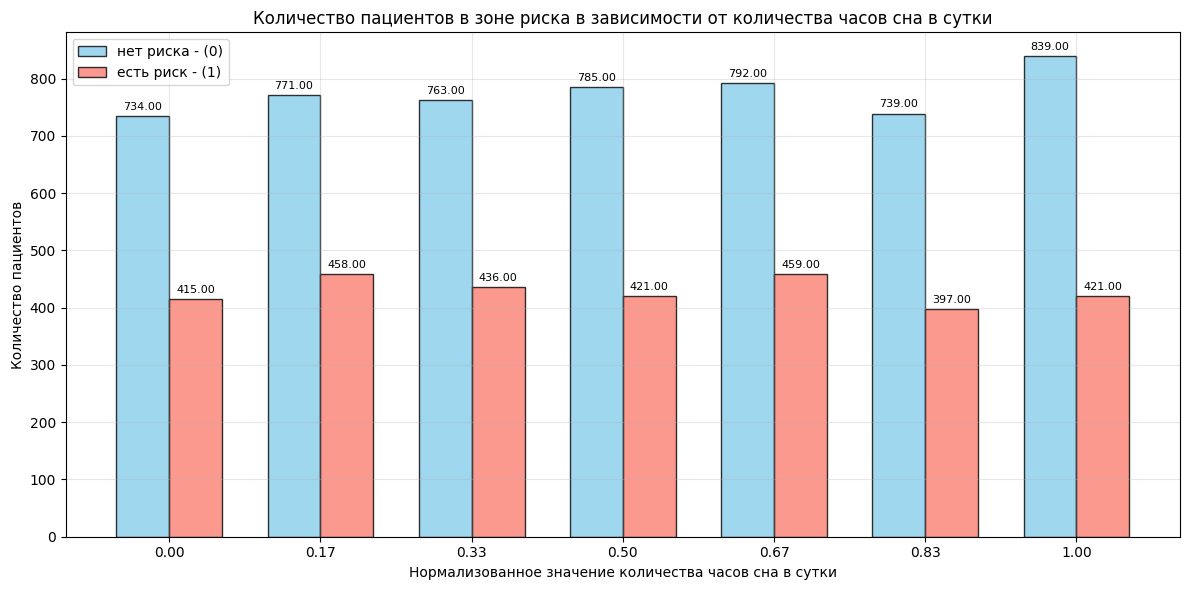

Статистика по sleep_hours_per_day:
Уникальных значений: 7

Средние значения:

Средние значения:
Без риска: 0.508605
С риском: 0.495510

Доли риска по категориям sleep_hours_per_day:
  0.0: 36.1%
  0.1666666666666666: 37.3%
  0.3333333333333333: 36.4%
  0.4999999999999999: 34.9%
  0.6666666666666666: 36.7%
  0.8333333333333334: 34.9%
  1.0: 33.4%


In [52]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'sleep_hours_per_day', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости ' \
                       'от количества часов сна в сутки',
                       x_label='Нормализованное значение количества часов сна в сутки',
                       y_label='Количество пациентов',
                       bins=7
                       )

**Промежуточный вывод**:

#### Признак `blood_sugar`

**Комментарий**: исследуем признак `blood_sugar` -- уровень сахара в крови пациента.

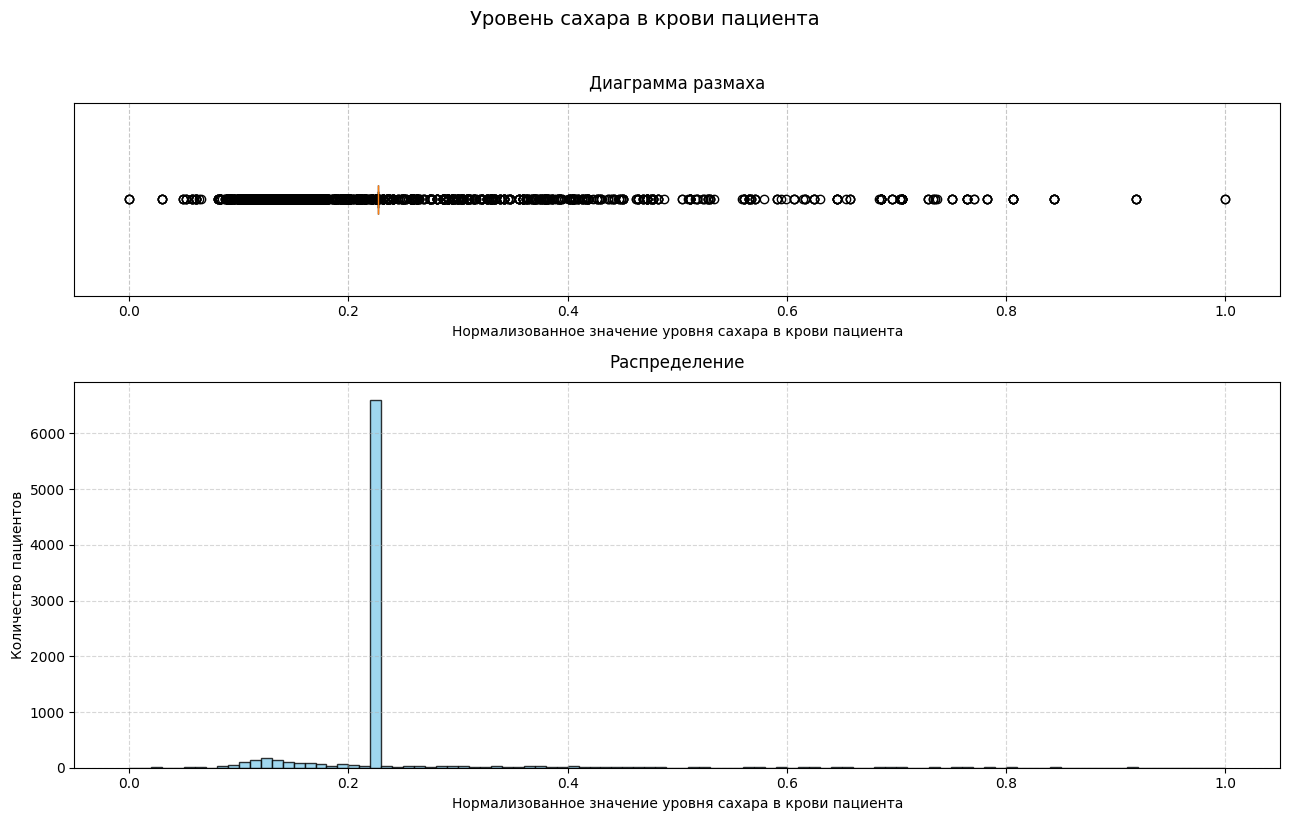

count    8430.000000
mean        0.228034
std         0.074625
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: blood_sugar, dtype: float64

In [53]:
# выведем график распределения
plot_data_analysis(heart['blood_sugar'],
                   title='Уровень сахара в крови пациента',
                   x_label='Нормализованное значение уровня сахара в крови пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=100
                   )

**Комментарий**: рассмотрим распределение в логарифмической шкале по количеству пациентов.

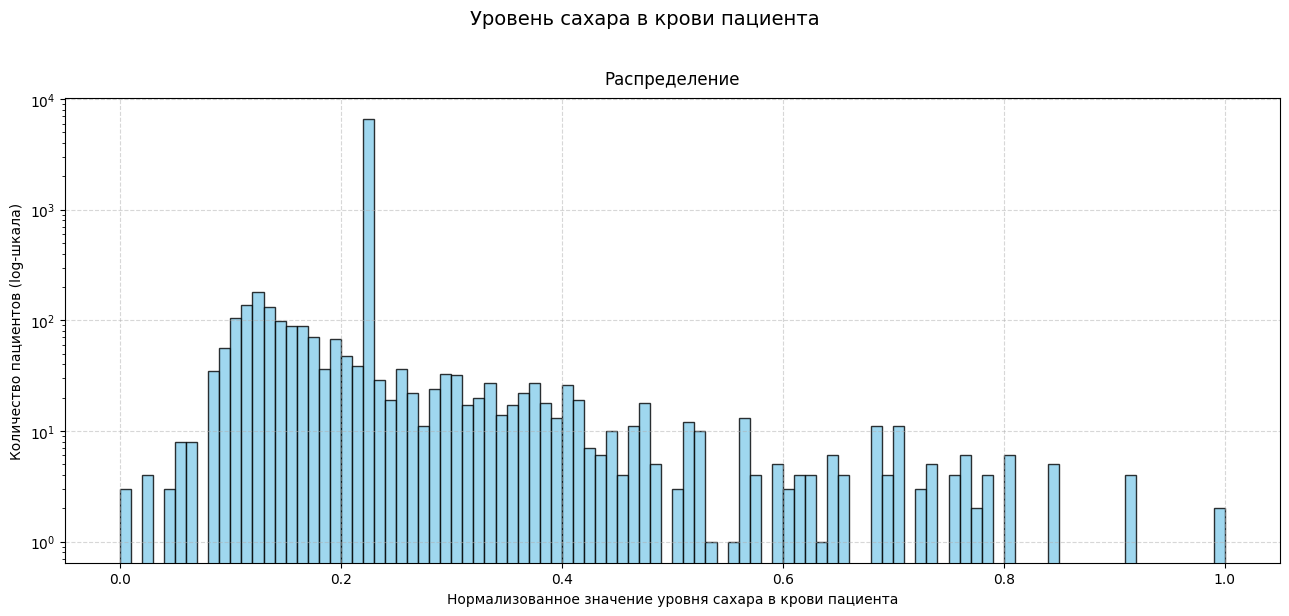

count    8430.000000
mean        0.228034
std         0.074625
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: blood_sugar, dtype: float64

In [54]:
# выведем график распределения
plot_data_analysis(heart['blood_sugar'],
                   title='Уровень сахара в крови пациента',
                   x_label='Нормализованное значение уровня сахара в крови пациента',
                   y_label='Количество пациентов (log-шкала)',
                   discrete=False,
                   plot_box=False,
                   bins=100,
                   log = True
                   )

In [55]:
# выведем значения распределения
result = heart.groupby(pd.cut(heart['blood_sugar'], bins=10))['heart_attack_risk_binary'].agg(['mean', 'count'])
print(result)

                   mean  count
blood_sugar                   
(-0.001, 0.1]  0.358974    117
(0.1, 0.2]     0.331678   1007
(0.2, 0.3]     0.363239   6855
(0.3, 0.4]     0.294686    207
(0.4, 0.5]     0.339623    106
(0.5, 0.6]     0.306122     49
(0.6, 0.7]     0.324324     37
(0.7, 0.8]     0.285714     35
(0.8, 0.9]     0.363636     11
(0.9, 1.0]     0.500000      6


**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Данные неестественно сконцентрированы вокруг значения $\sim$**0.227**. Кажется, что в реальности распределение сахара в крови должно быть более плавным. Однако, максимум на **0.227** может судить о том, что большинство пациентов имеет нормальное значение сахара в крови. Действительно, это подтверждается выводом данных выше: $\sim80$% пациентов сосредоточены в узком диапазоне [0.2, 0.3], при этом хвосты содержат слишком мало данных для надежных выводов по ним. Поэтому лучше использовать признак как есть и выбросы убирать категорически не стоит.

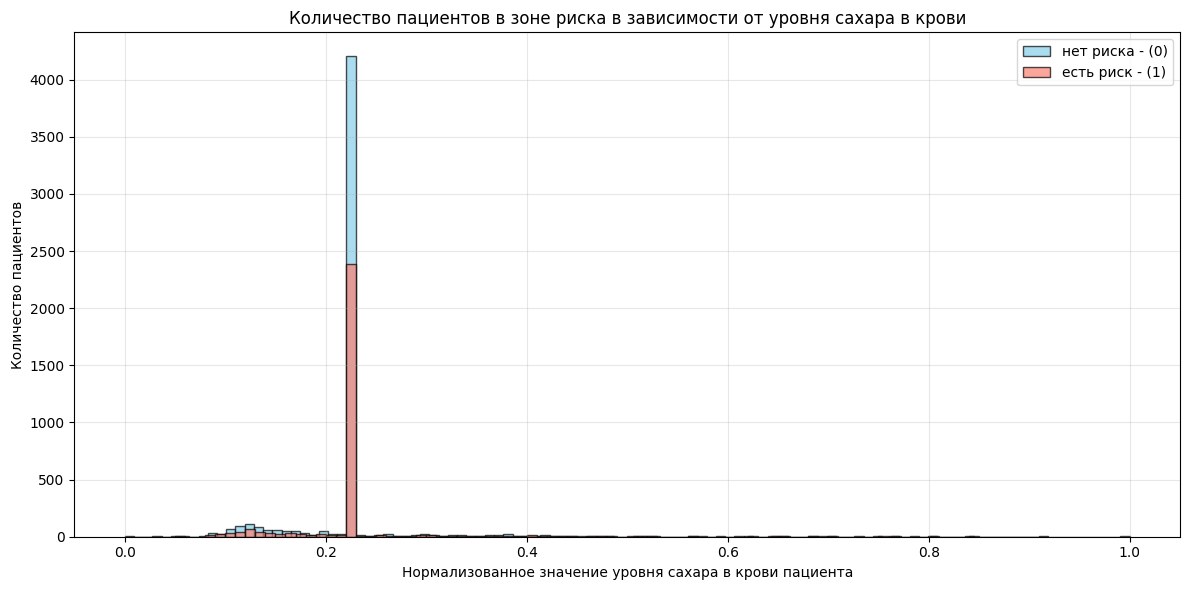

Статистика по blood_sugar:
Уникальных значений: 224

Средние значения:

Средние значения:
Без риска: 0.228272
С риском: 0.227605
Разница средних (риск - нет риска): -0.000668
Относительная разница: -0.29%


In [56]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'blood_sugar', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от уровня сахара в крови',
                       x_label='Нормализованное значение уровня сахара в крови пациента',
                       y_label='Количество пациентов',
                       bins=100
                       )

**Промежуточный вывод**:

#### Признак `systolic_blood_pressure`

**Комментарий**: исследуем признак `systolic_blood_pressure` -- cистолическое артериальное давление пациента.

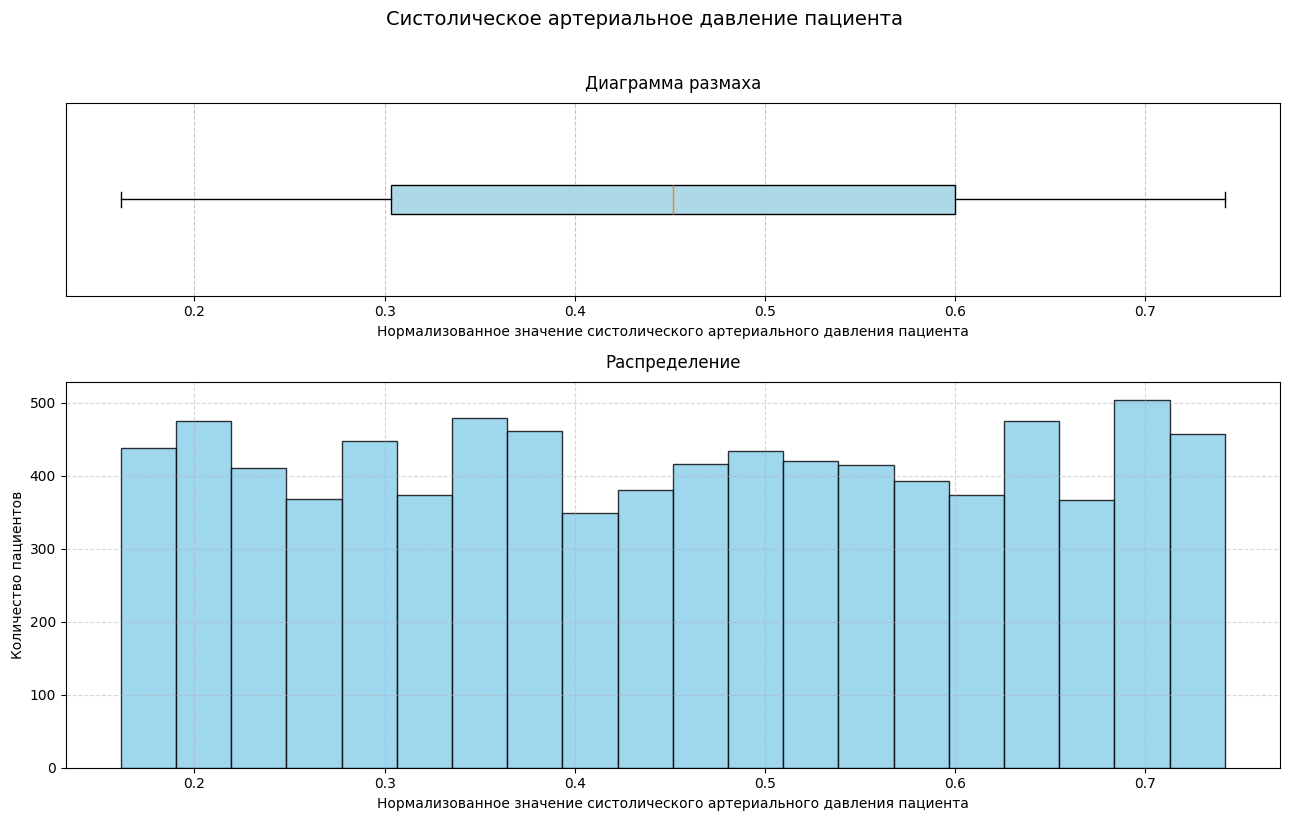

count    8430.000000
mean        0.451990
std         0.170136
min         0.161290
25%         0.303226
50%         0.451613
75%         0.600000
max         0.741935
Name: systolic_blood_pressure, dtype: float64

In [57]:
# выведем график распределения
plot_data_analysis(heart['systolic_blood_pressure'],
                   title='Систолическое артериальное давление пациента',
                   x_label='Нормализованное значение систолического артериального давления пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

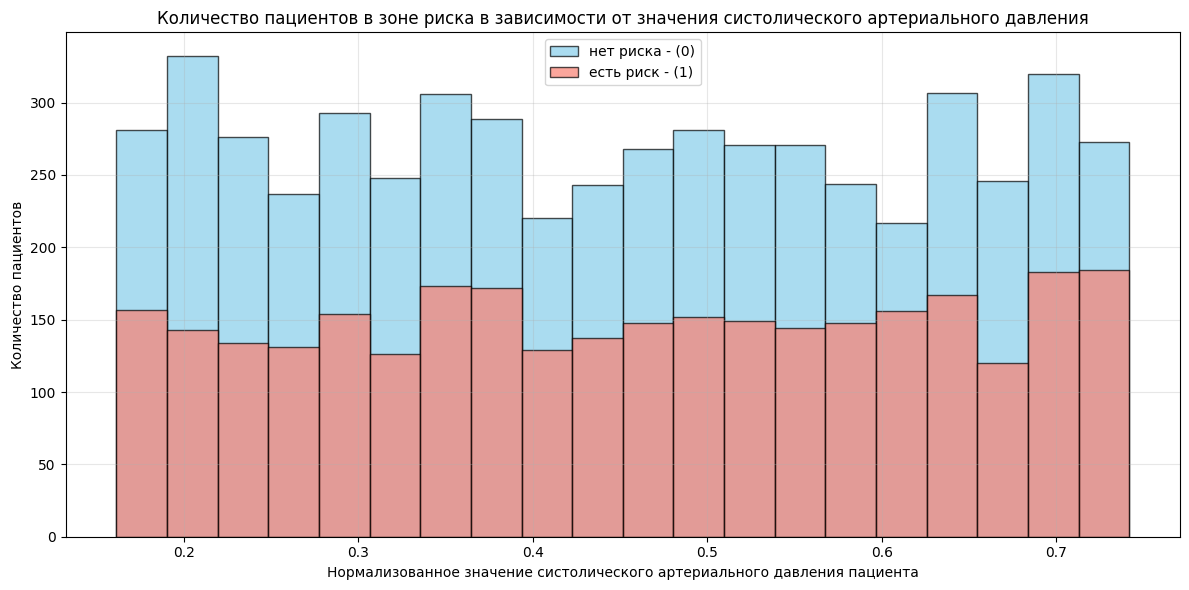

Статистика по systolic_blood_pressure:
Уникальных значений: 91

Средние значения:

Средние значения:
Без риска: 0.448710
С риском: 0.457906
Разница средних (риск - нет риска): 0.009196
Относительная разница: 2.05%


In [58]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'systolic_blood_pressure', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости ' \
                       'от значения систолического артериального давления',
                       x_label='Нормализованное значение систолического артериального давления пациента',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**:

#### Признак `diastolic_blood_pressure`

**Комментарий**: исследуем признак `diastolic_blood_pressure` -- диастолическое артериальное давление пациента.

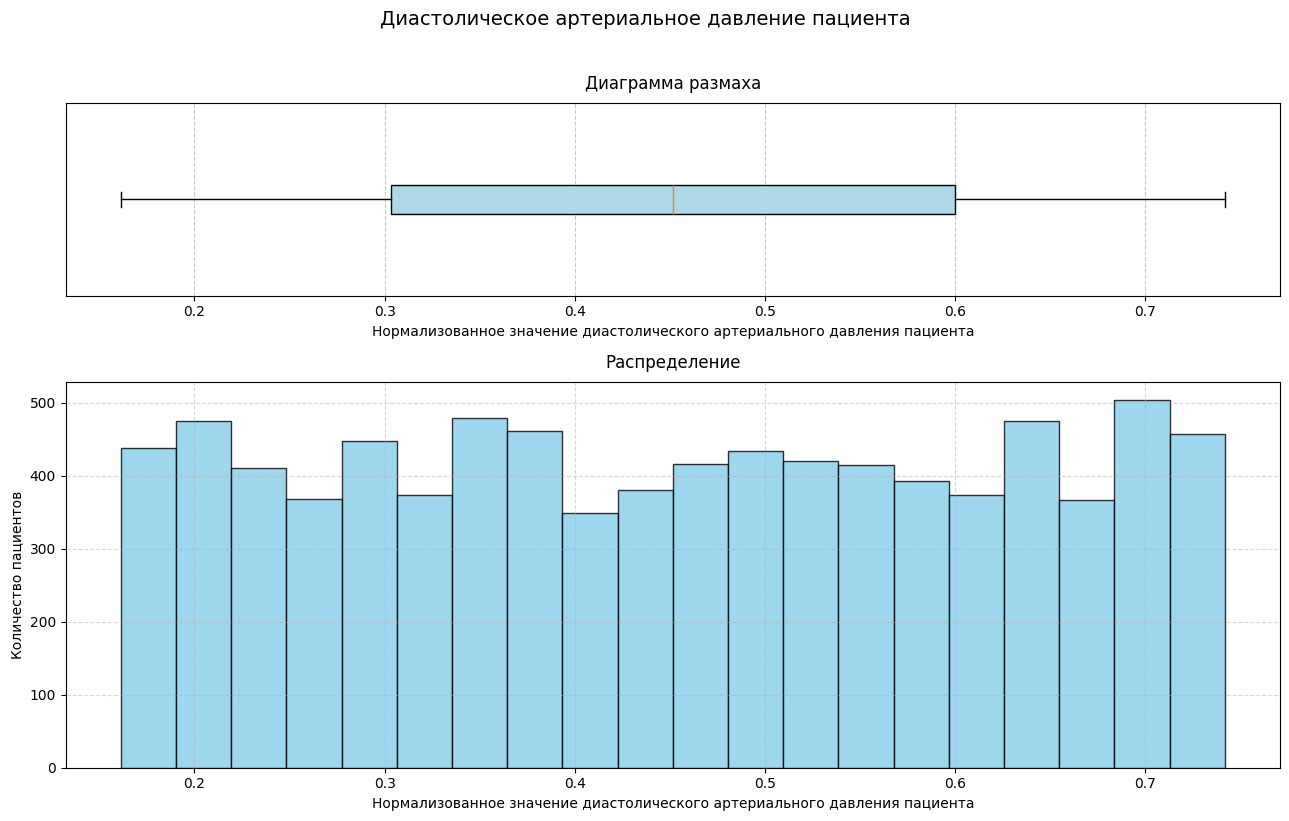

count    8430.000000
mean        0.451990
std         0.170136
min         0.161290
25%         0.303226
50%         0.451613
75%         0.600000
max         0.741935
Name: systolic_blood_pressure, dtype: float64

In [59]:
# выведем график распределения
plot_data_analysis(heart['systolic_blood_pressure'],
                   title='Диастолическое артериальное давление пациента',
                   x_label='Нормализованное значение диастолического артериального давления пациента',
                   y_label='Количество пациентов',
                   discrete=False,
                   plot_box=True,
                   bins=20
                   )

**Комментарий**: данные в этом столбце были уже предварительно отмасштабированы. Каких-то выбросов или аномалий не наблюдается. Посмотрим теперь распределение по целевому признаку.

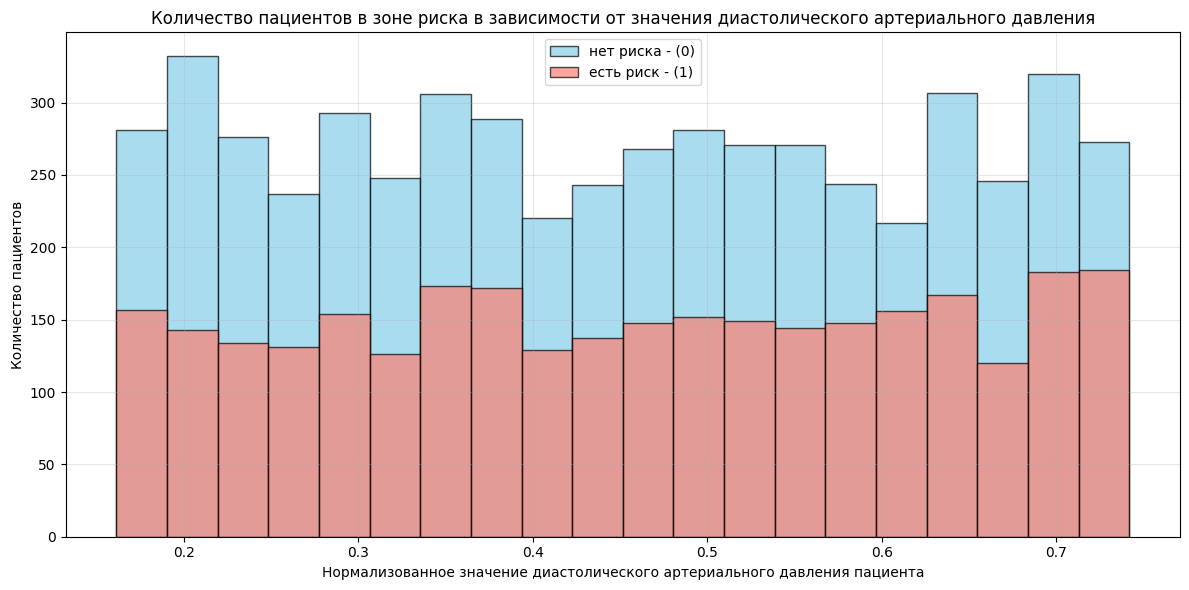

Статистика по systolic_blood_pressure:
Уникальных значений: 91

Средние значения:

Средние значения:
Без риска: 0.448710
С риском: 0.457906
Разница средних (риск - нет риска): 0.009196
Относительная разница: 2.05%


In [60]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'systolic_blood_pressure', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости ' \
                       'от значения диастолического артериального давления',
                       x_label='Нормализованное значение диастолического артериального давления пациента',
                       y_label='Количество пациентов',
                       bins=20
                       )

**Промежуточный вывод**:

### Категориальные признаки

**Комментарий**: теперь рассмотрим категориальные признаки:
- `diabetes` -- наличие у пациента диагностированного диабета
- `family_history` -- были ли проблемы с сердцем у родственников пациента
- `smoking` -- является ли пациент курильщиком
- `obesity` -- страдает ли пациент от ожирения
- `alcohol_consumption` -- употребление алкоголя пациентом
- `diet` -- какая у пациента диета/питание
- `previous_heart_problems` -- были ли ранее у пациента проблемы с сердцем
- `medication_use` -- принимает ли пациент лекарственные препараты
- `stress_level` -- уровень стресса пациента
- `gender` -- пол пациента

#### Признак `diabetes`

**Комментарий**: рассмотрим признак `diabetes` -- наличие у пациента диагностированного диабета.

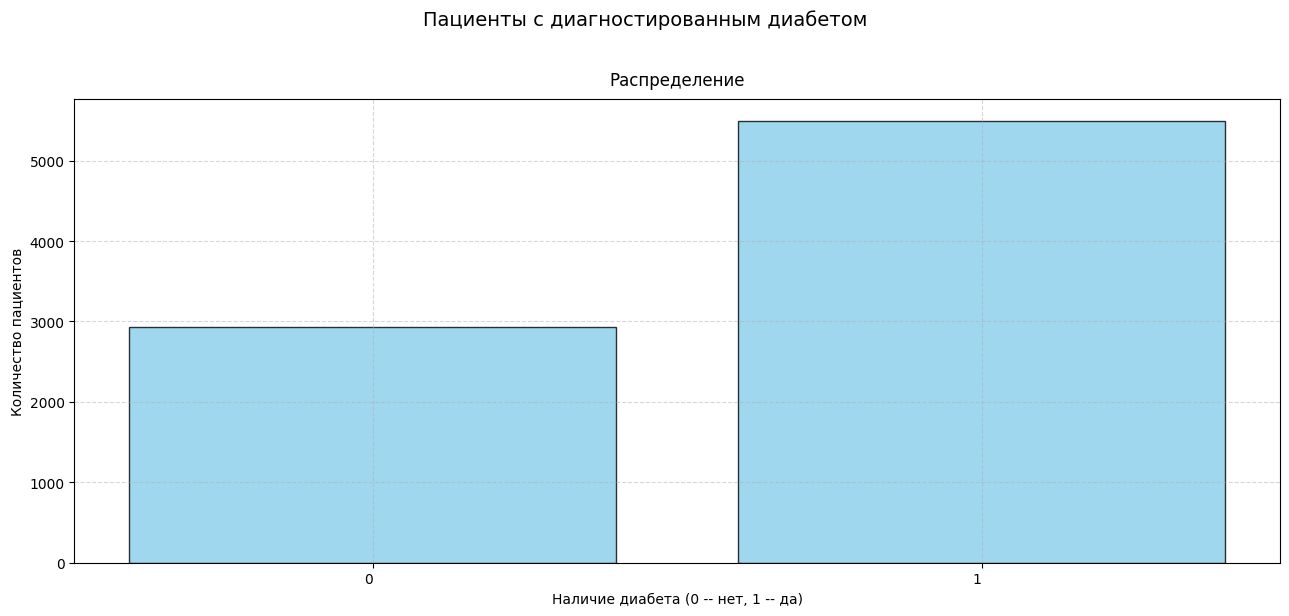

count    8430.000000
mean        0.652076
std         0.476340
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: diabetes, dtype: float64

In [61]:
# выведем график распределения
plot_data_analysis(heart['diabetes'],
                   title = 'Пациенты с диагностированным диабетом',
                   x_label = 'Наличие диабета (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: 

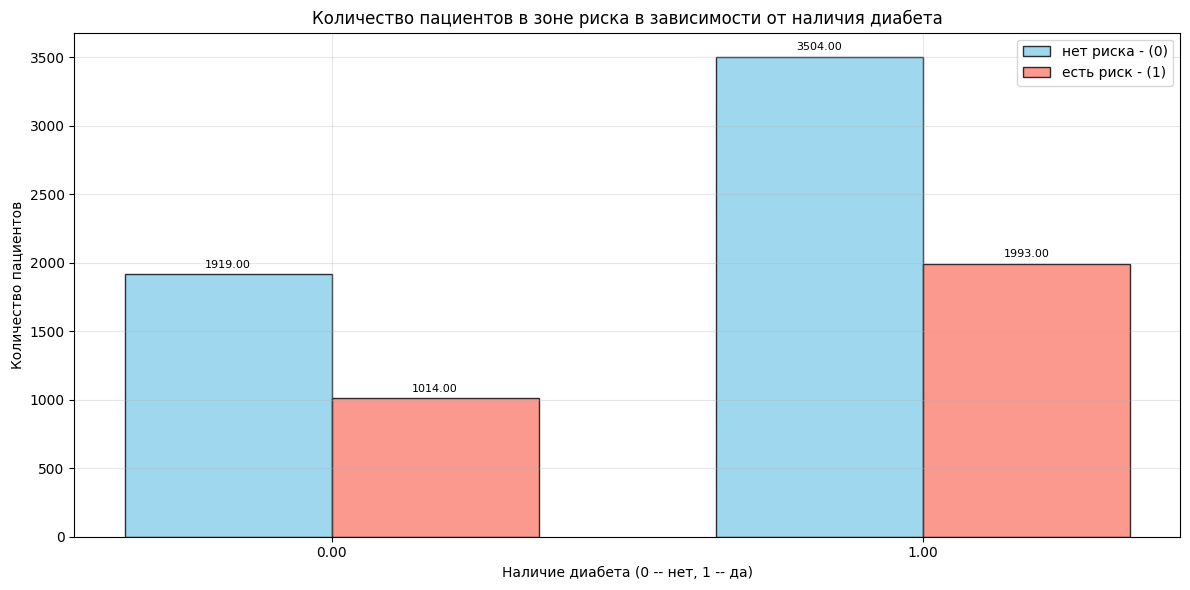

Статистика по diabetes:
Уникальных значений: 2

Средние значения:

Средние значения:
Без риска: 0.646137
С риском: 0.662787

Доли риска по категориям diabetes:
  0: 34.6%
  1: 36.3%


In [62]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'diabetes', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от наличия диабета',
                       x_label='Наличие диабета (0 -- нет, 1 -- да)',
                       y_label='Количество пациентов'
                       )

**Промежуточный вывод**:

#### Признак `family_history`

**Комментарий**: рассмотрим признак `family_history` -- были ли проблемы с сердцем у родственников пациента.

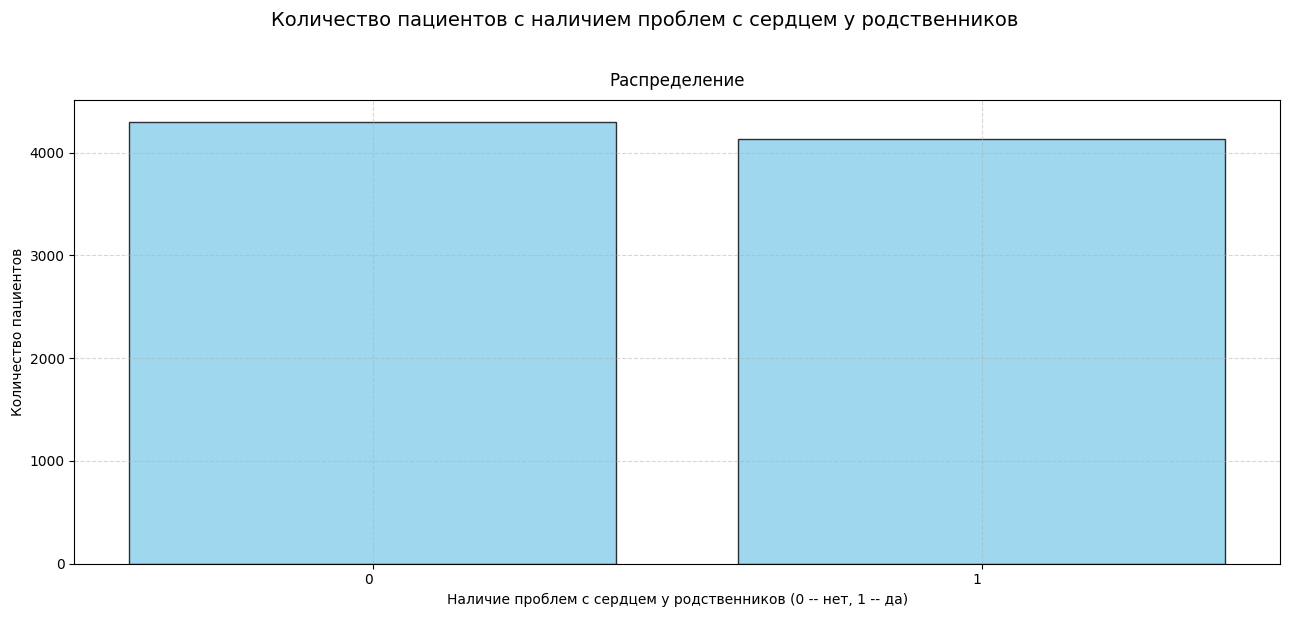

count    8430.000000
mean        0.489917
std         0.499928
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: family_history, dtype: float64

In [63]:
# выведем график распределения
plot_data_analysis(heart['family_history'],
                   title = 'Количество пациентов с наличием проблем с сердцем у родственников',
                   x_label = 'Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: 

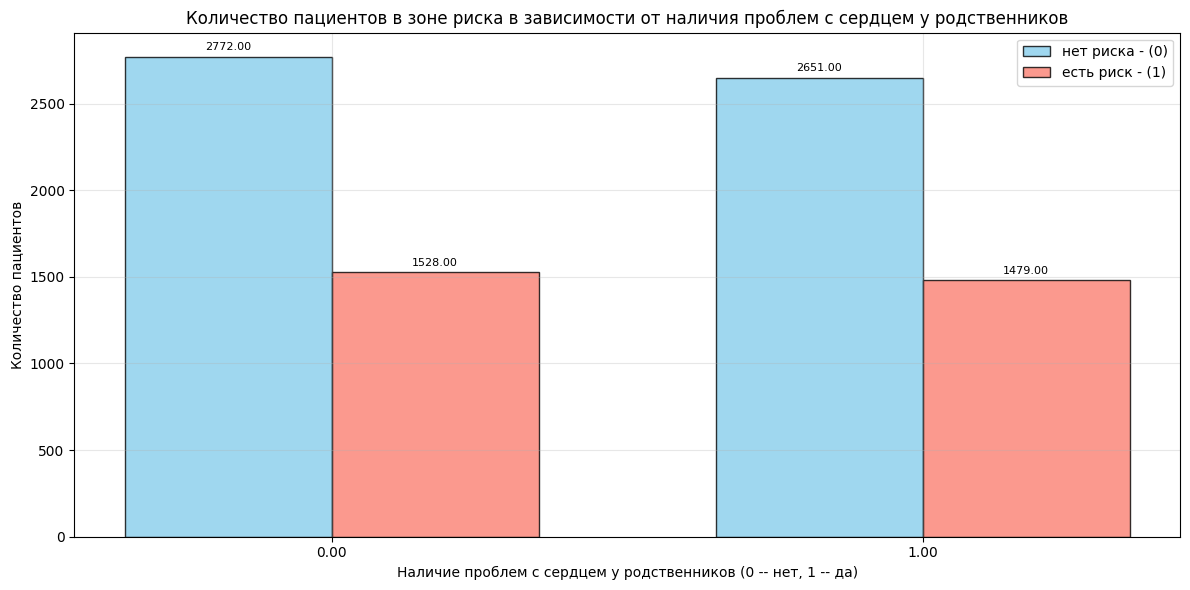

Статистика по family_history:
Уникальных значений: 2

Средние значения:

Средние значения:
Без риска: 0.488844
С риском: 0.491852

Доли риска по категориям family_history:
  0: 35.5%
  1: 35.8%


In [64]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'family_history', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от наличия проблем с сердцем у родственников',
                       x_label='Наличие проблем с сердцем у родственников (0 -- нет, 1 -- да)',
                       y_label='Количество пациентов'
                       )

**Промежуточный вывод**:

#### Признак `smoking`

**Комментарий**: рассмотрим признак `smoking` -- является ли пациент курильщиком.

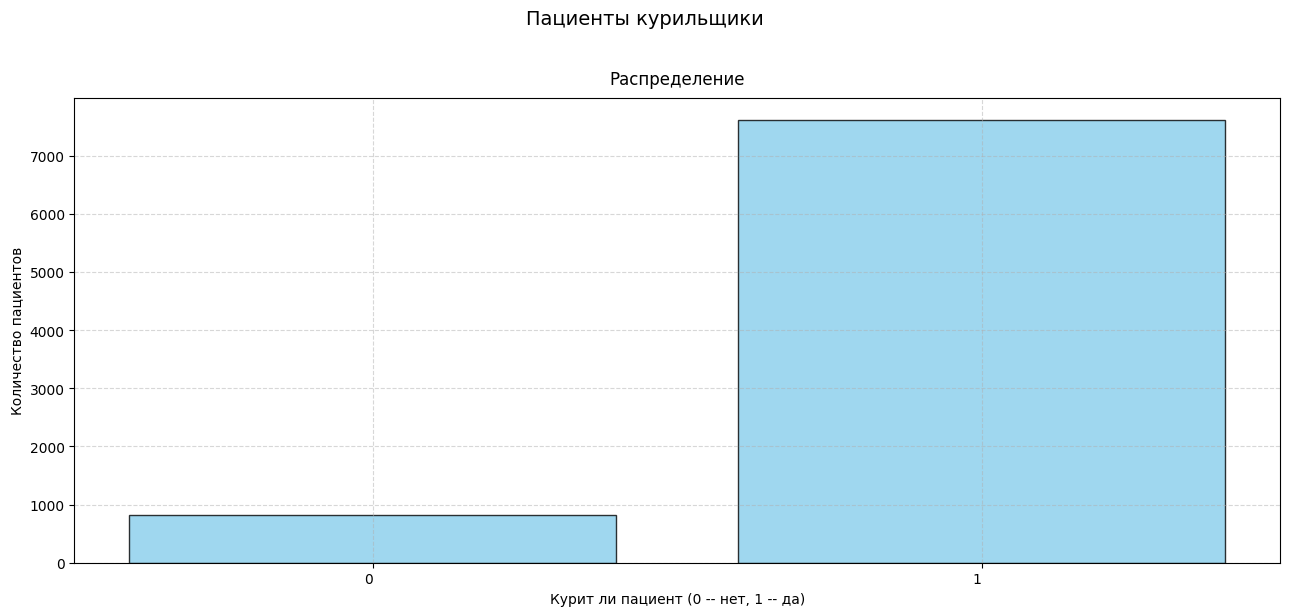

count    8430.000000
mean        0.902728
std         0.296345
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: smoking, dtype: float64

In [65]:
# выведем график распределения
plot_data_analysis(heart['smoking'],
                   title = 'Пациенты курильщики',
                   x_label = 'Курит ли пациент (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: 

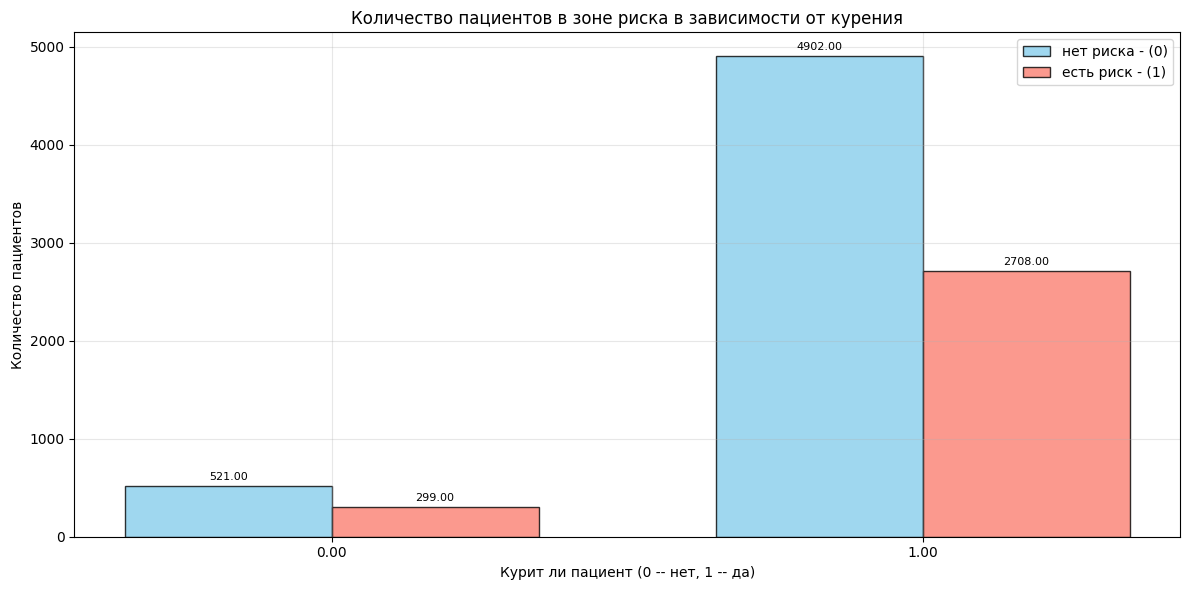

Статистика по smoking:
Уникальных значений: 2

Средние значения:

Средние значения:
Без риска: 0.903928
С риском: 0.900565

Доли риска по категориям smoking:
  0: 36.5%
  1: 35.6%


In [66]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'smoking', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от курения',
                       x_label='Курит ли пациент (0 -- нет, 1 -- да)',
                       y_label='Количество пациентов'
                       )

**Промежуточный вывод**:

#### Признак `obesity`

**Комментарий**: рассмотрим признак `obesity` -- страдает ли пациент от ожирения.

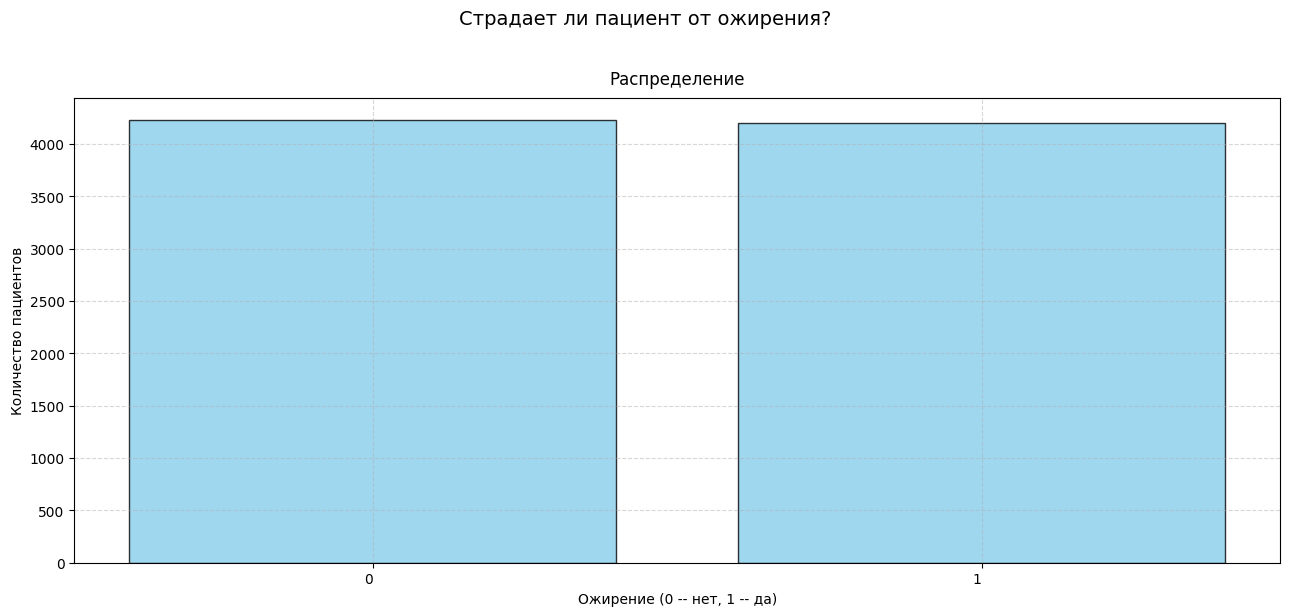

count    8430.000000
mean        0.498577
std         0.500028
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: obesity, dtype: float64

In [67]:
# выведем график распределения
plot_data_analysis(heart['obesity'],
                   title = 'Страдает ли пациент от ожирения?',
                   x_label = 'Ожирение (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: 

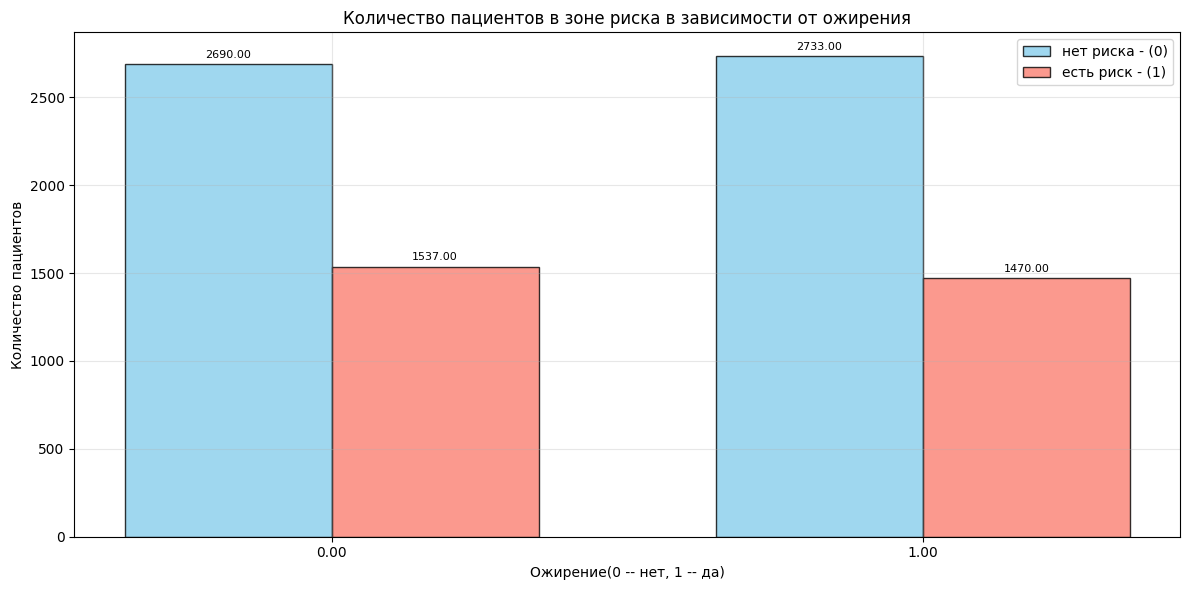

Статистика по obesity:
Уникальных значений: 2

Средние значения:

Средние значения:
Без риска: 0.503965
С риском: 0.488859

Доли риска по категориям obesity:
  0: 36.4%
  1: 35.0%


In [68]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'obesity', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от ожирения',
                       x_label='Ожирение(0 -- нет, 1 -- да)',
                       y_label='Количество пациентов'
                       )

**Промежуточный вывод**:

#### Признак `alcohol_consumption`

**Комментарий**: рассмотрим признак `alcohol_consumption` -- употребление алкоголя пациентом.

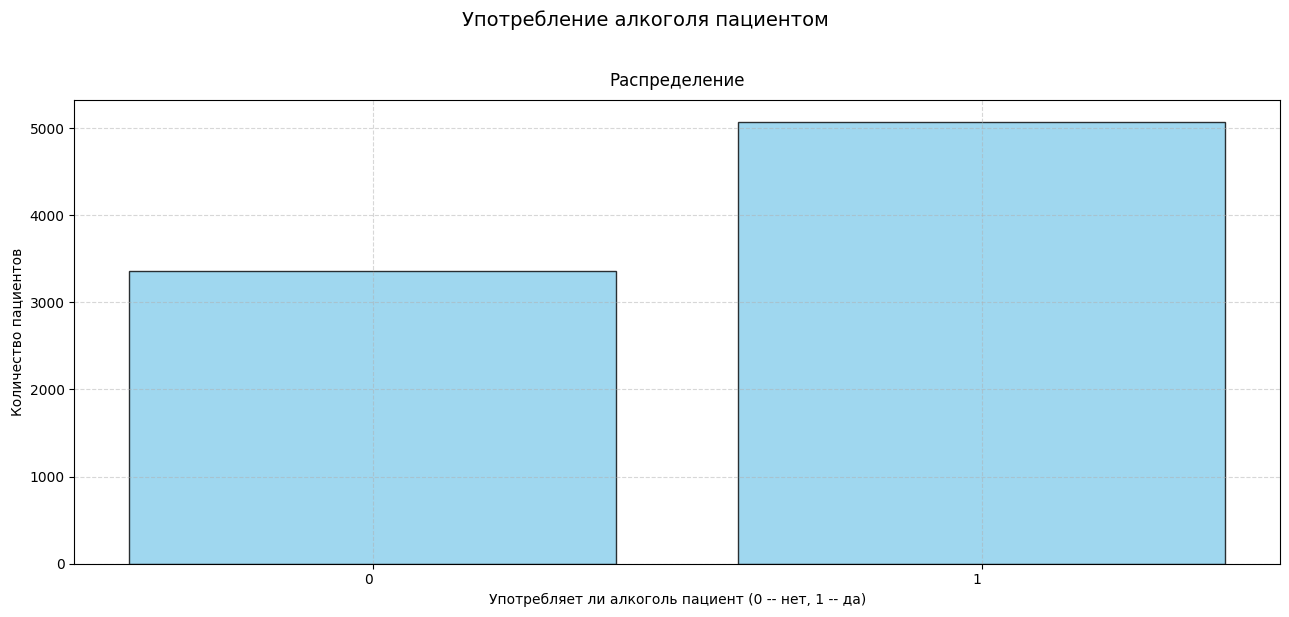

count    8430.000000
mean        0.602017
std         0.489511
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: alcohol_consumption, dtype: float64

In [69]:
# выведем график распределения
plot_data_analysis(heart['alcohol_consumption'],
                   title = 'Употребление алкоголя пациентом',
                   x_label = 'Употребляет ли алкоголь пациент (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: 

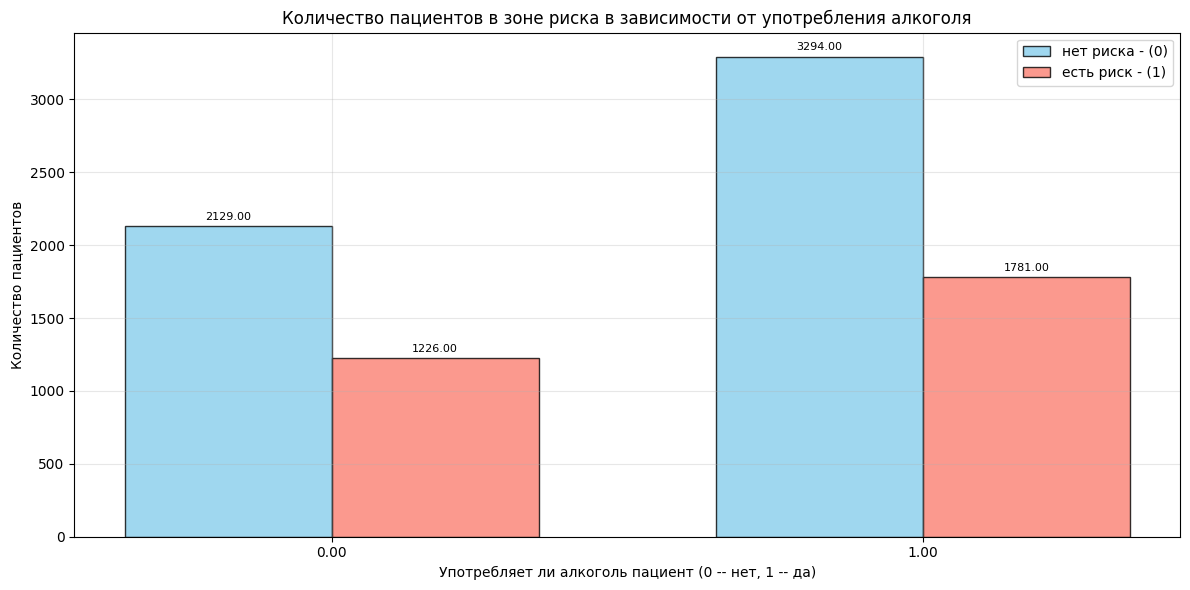

Статистика по alcohol_consumption:
Уникальных значений: 2

Средние значения:

Средние значения:
Без риска: 0.607413
С риском: 0.592285

Доли риска по категориям alcohol_consumption:
  0: 36.5%
  1: 35.1%


In [70]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'alcohol_consumption', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от употребления алкоголя',
                       x_label='Употребляет ли алкоголь пациент (0 -- нет, 1 -- да)',
                       y_label='Количество пациентов'
                       )

**Промежуточный вывод**:

#### Признак `diet`

**Комментарий**: рассмотрим признак `diet` -- какая у пациента диета/питание.

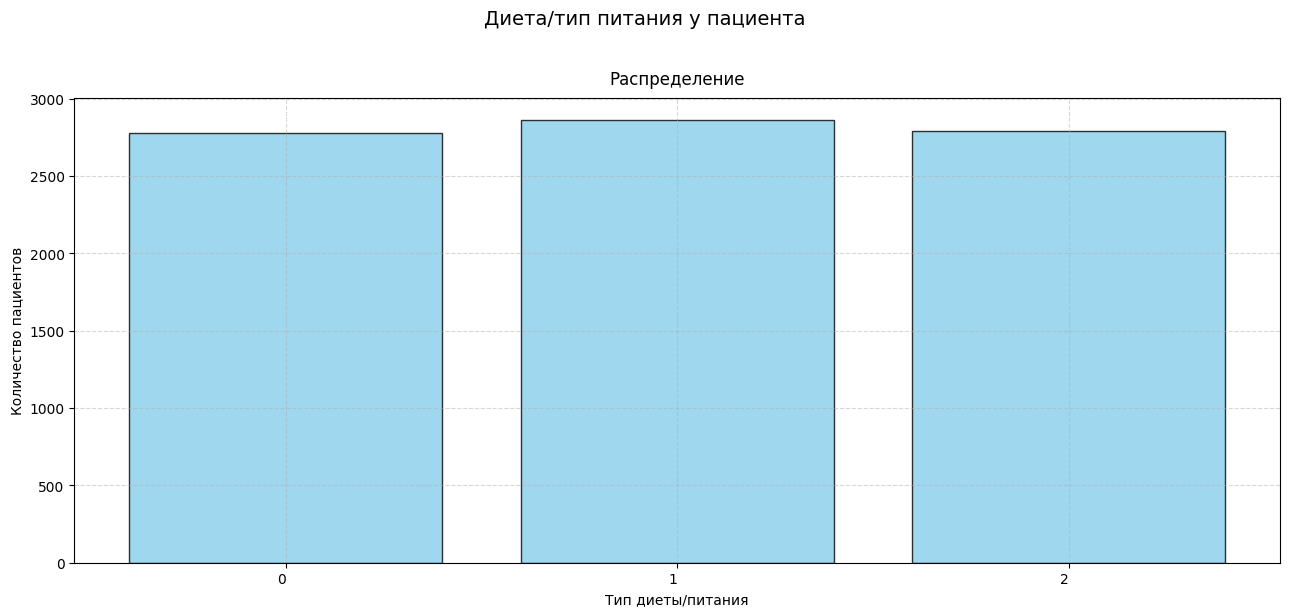

count    8430.000000
mean        1.001542
std         0.812830
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: diet, dtype: float64

In [71]:
# выведем график распределения
plot_data_analysis(heart['diet'],
                   title = 'Диета/тип питания у пациента',
                   x_label = 'Тип диеты/питания',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: 

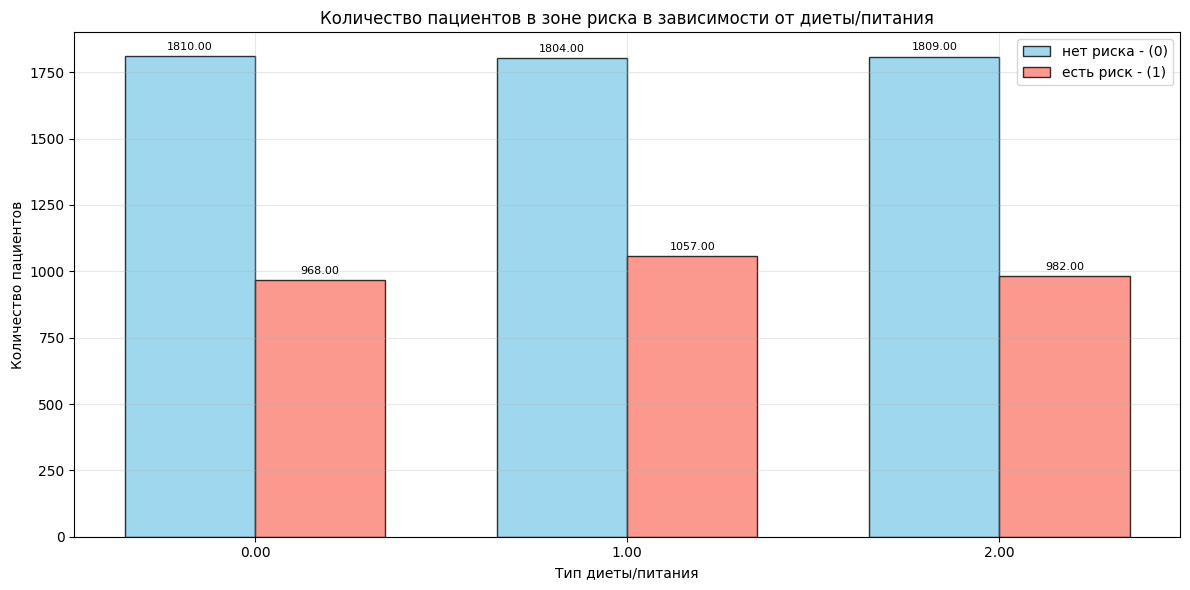

Статистика по diet:
Уникальных значений: 3

Средние значения:

Средние значения:
Без риска: 0.999816
С риском: 1.004656

Доли риска по категориям diet:
  0: 34.8%
  1: 36.9%
  2: 35.2%


In [72]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'diet', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от диеты/питания',
                       x_label='Тип диеты/питания',
                       y_label='Количество пациентов'
                       )

**Промежуточный вывод**:

#### Признак `medication_use`

**Комментарий**: рассмотрим признак `medication_use` -- принимает ли пациент лекарственные препараты.

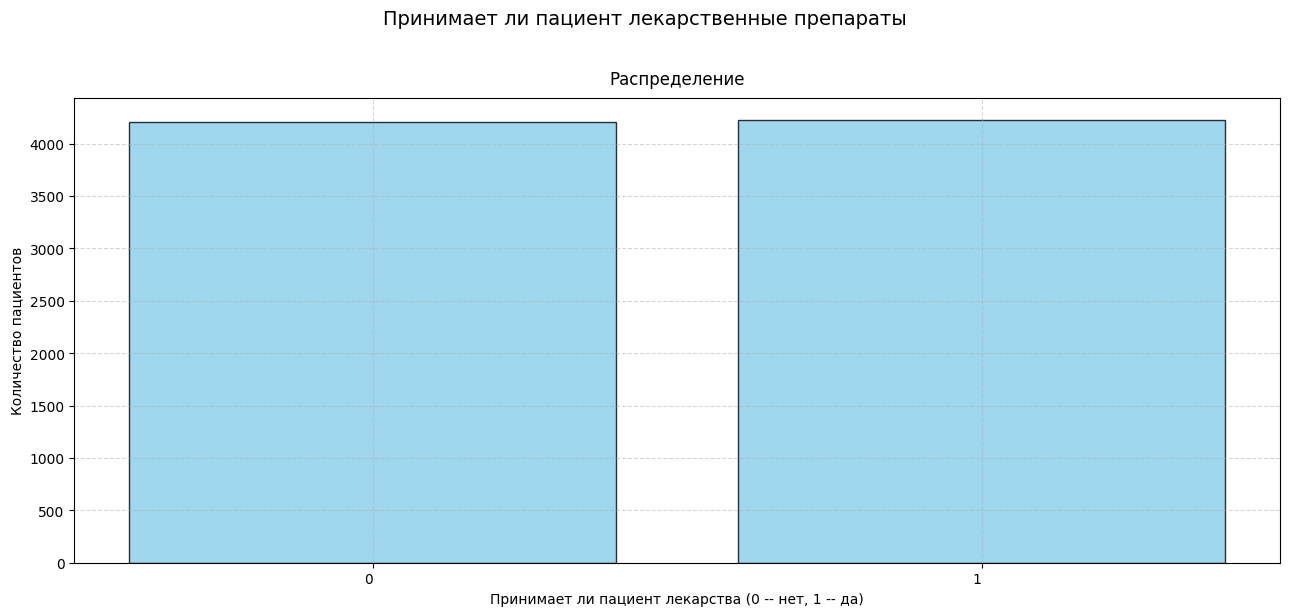

count    8430.000000
mean        0.501068
std         0.500029
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: medication_use, dtype: float64

In [73]:
# выведем график распределения
plot_data_analysis(heart['medication_use'],
                   title = 'Принимает ли пациент лекарственные препараты',
                   x_label = 'Принимает ли пациент лекарства (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: 

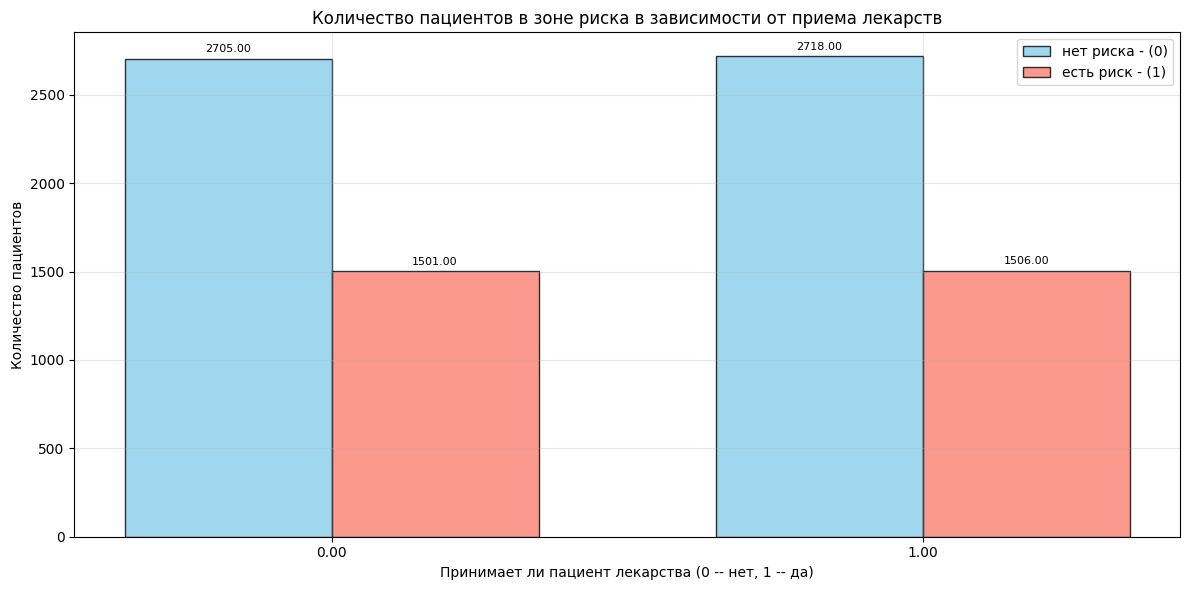

Статистика по medication_use:
Уникальных значений: 2

Средние значения:

Средние значения:
Без риска: 0.501199
С риском: 0.500831

Доли риска по категориям medication_use:
  0: 35.7%
  1: 35.7%


In [74]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'medication_use', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от приема лекарств',
                       x_label='Принимает ли пациент лекарства (0 -- нет, 1 -- да)',
                       y_label='Количество пациентов'
                       )

**Промежуточный вывод**:

#### Признак `stress_level`

**Комментарий**: рассмотрим признак `stress_level` -- уровень стресса пациента.

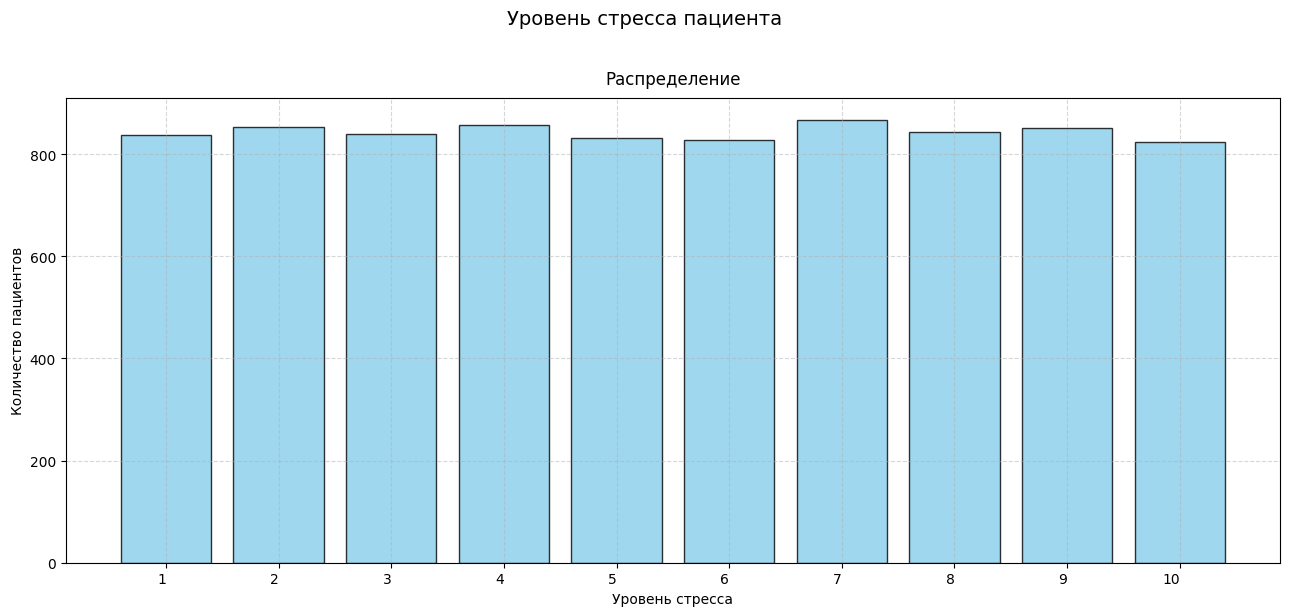

count    8430.000000
mean        5.493832
std         2.867650
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: stress_level, dtype: float64

In [75]:
# выведем график распределения
plot_data_analysis(heart['stress_level'],
                   title = 'Уровень стресса пациента',
                   x_label = 'Уровень стресса',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: 

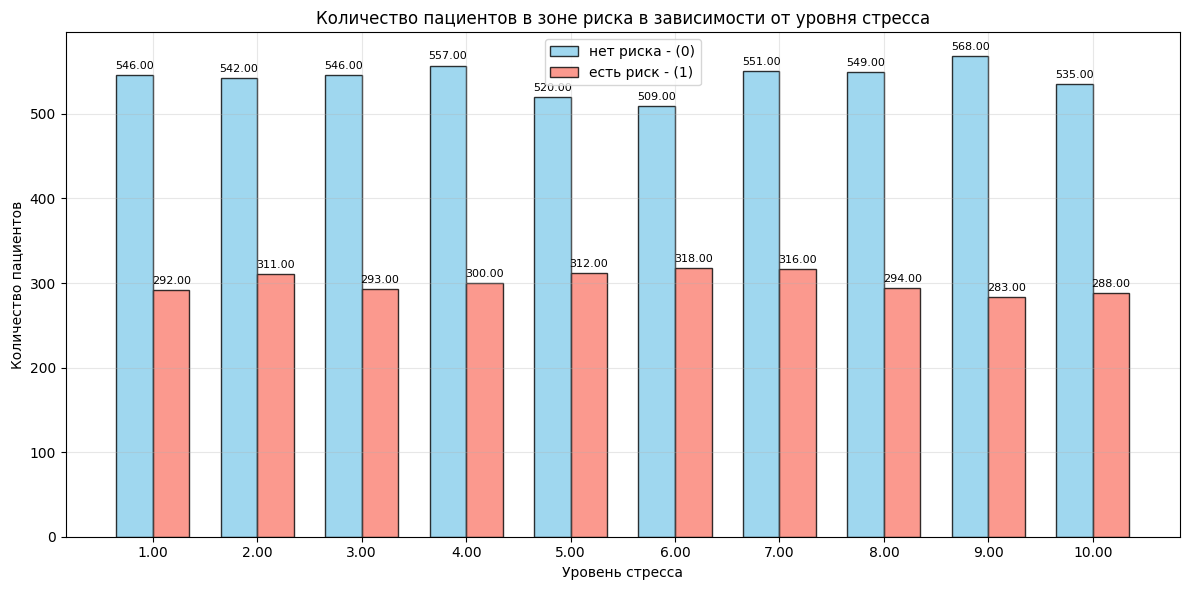

Статистика по stress_level:
Уникальных значений: 10

Средние значения:

Средние значения:
Без риска: 5.506362
С риском: 5.471234

Доли риска по категориям stress_level:
  1: 34.8%
  2: 36.5%
  3: 34.9%
  4: 35.0%
  5: 37.5%
  6: 38.5%
  7: 36.4%
  8: 34.9%
  9: 33.3%
  10: 35.0%


In [76]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart, 
                       'stress_level', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от уровня стресса',
                       x_label='Уровень стресса',
                       y_label='Количество пациентов'
                       )

**Промежуточный вывод**:

#### Признак `gender`

**Комментарий**: рассмотрим признак `gender` -- пол пациента.

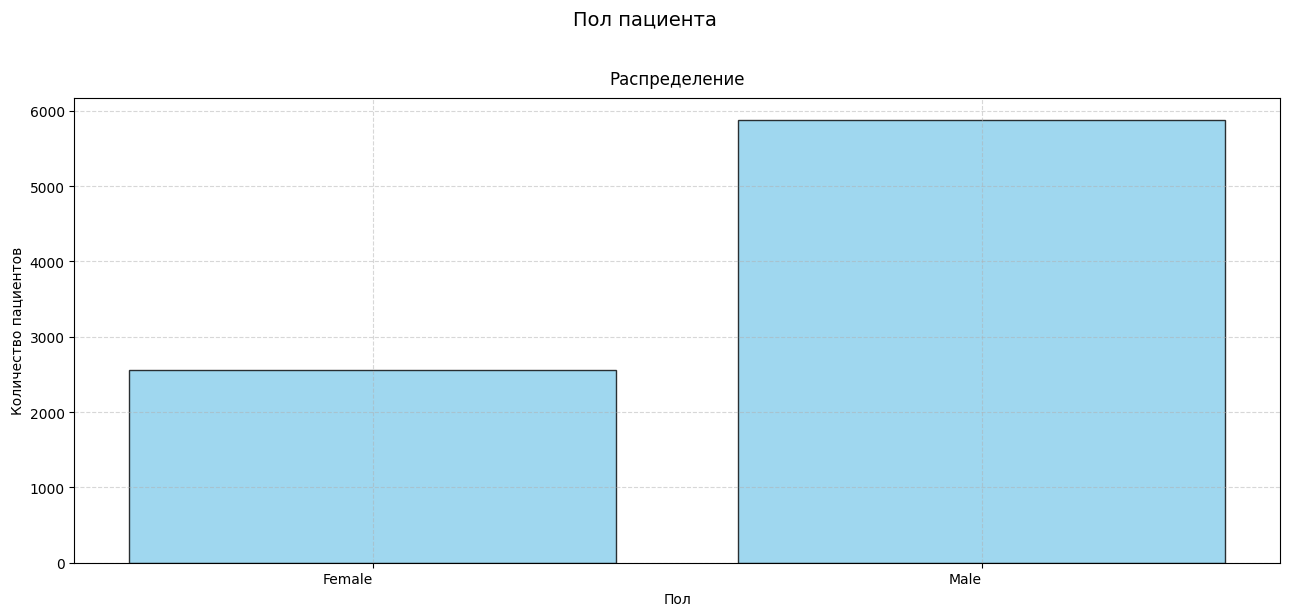

count     8430
unique       2
top       Male
freq      5877
Name: gender, dtype: object

In [77]:
# выведем график распределения
plot_data_analysis(heart['gender'],
                   title = 'Пол пациента',
                   x_label = 'Пол',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

**Комментарий**: 

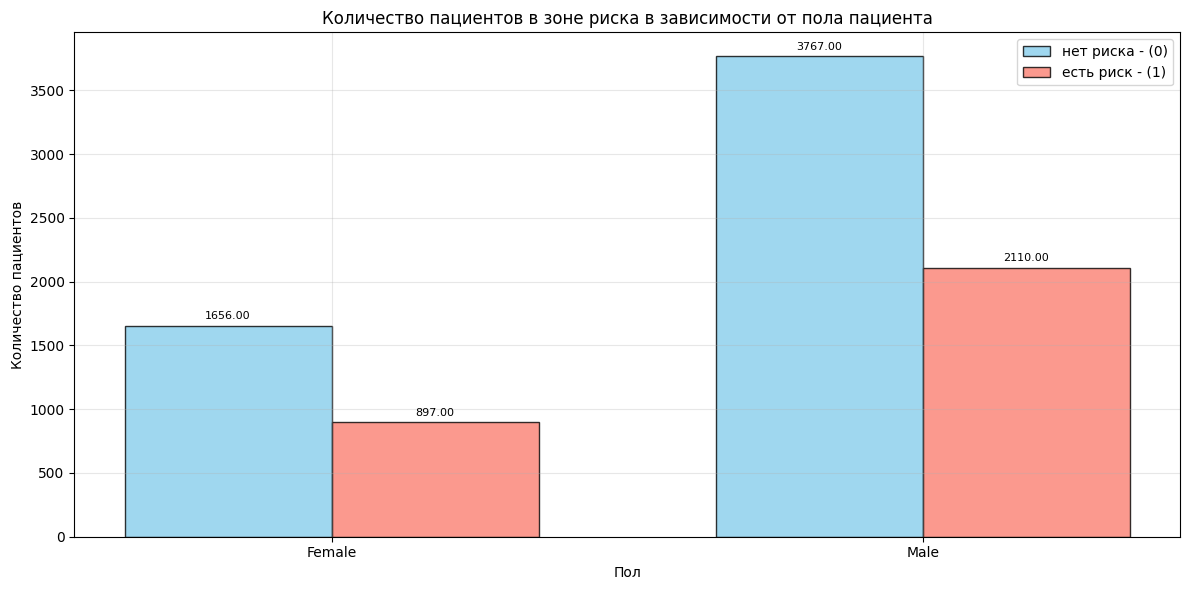

Статистика по gender:
Уникальных значений: 2

Средние значения:

Доли риска по категориям gender:
  Female: 35.1%
  Male: 35.9%


In [78]:
# посмотрим распределение в зависимости от целевого
plot_feature_vs_target(heart,
                       'gender', 
                       'heart_attack_risk_binary',
                       title='Количество пациентов в зоне риска в зависимости от пола пациента',
                       x_label='Пол',
                       y_label='Количество пациентов'
                       )

**Промежуточный вывод**:

#### Целевой признак `heart_attack_risk_binary`

**Комментарий**: рассмотрим **целевой признак** `heart_attack_risk_binary` -- риск сердечного приступа.

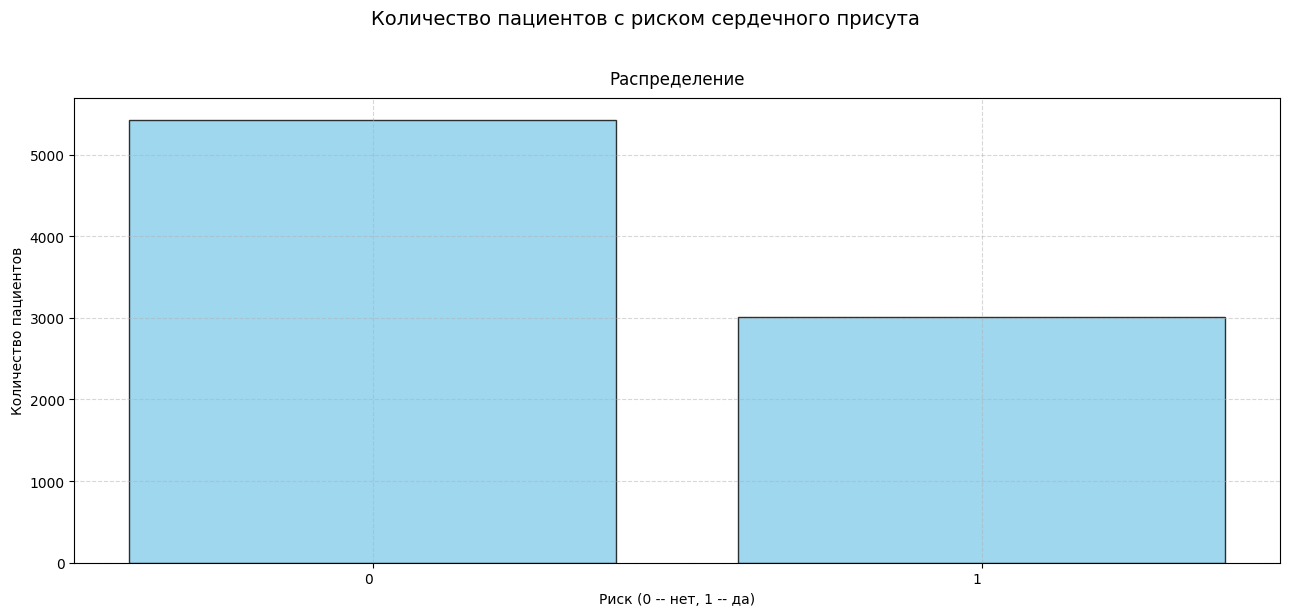

count    8430.000000
mean        0.356702
std         0.479054
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: heart_attack_risk_binary, dtype: float64

In [79]:
# выведем график распределения
plot_data_analysis(heart['heart_attack_risk_binary'],
                   title = 'Количество пациентов с риском сердечного присута',
                   x_label = 'Риск (0 -- нет, 1 -- да)',
                   y_label = 'Количество пациентов',
                   plot_bar = True,
                   plot_box = False,
                   discrete = True
                   )

In [80]:
heart['heart_attack_risk_binary'].value_counts()

heart_attack_risk_binary
0    5423
1    3007
Name: count, dtype: int64

**Комментарий**: наблюдается дисбаланс в целевом признаке. Важно это учитывать при формировании выборки (стратификация), и при настройке и обучении моделей (например, балансировочные веса для бустинга и деревьев).

**Промежуточный вывод**:

### Промежуточный вывод

## <u>Корреляционный анализ</u>

**Комментарий**: выполним корреляционный анализ признаков.

In [81]:
# составим список числовых столбцов
corr_columns = heart.select_dtypes(include=np.number).columns.tolist()

In [ ]:
# построим диаграммы рассеяния
sns.pairplot(heart[corr_columns], hue='heart_attack_risk_binary');

In [ ]:
# сформируем список столбцов с непрерывными признаками
interval_columns = ['age', 
                    'cholesterol', 
                    'heart_rate', 
                    'exercise_hours_per_week',
                    'sedentary_hours_per_day',
                    'income',
                    'bmi',
                    'triglycerides',
                    'blood_sugar',
                    'systolic_blood_pressure',
                    'diastolic_blood_pressure'
                    ]

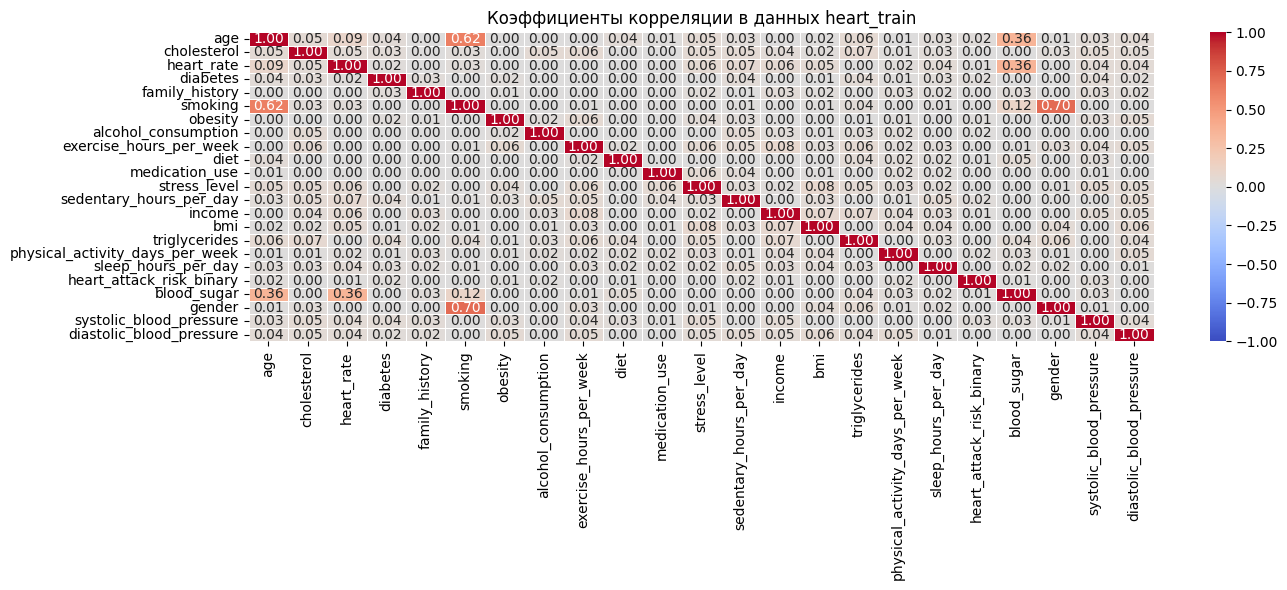

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,gender,systolic_blood_pressure,diastolic_blood_pressure
age,1.000000,0.047205,0.094651,0.036773,0.000000,0.620377,0.000000,0.000000,0.000000,0.035670,0.010370,0.053847,0.027653,0.000000,0.015423,0.059126,0.005952,0.026380,0.022771,0.358931,0.008955,0.034107,0.039307
cholesterol,0.047205,1.000000,0.046599,0.034752,0.000000,0.025275,0.000000,0.050559,0.058844,0.000000,0.000000,0.052501,0.049304,0.037413,0.016013,0.066644,0.008687,0.029596,0.000000,0.000000,0.029633,0.047706,0.045653
heart_rate,0.094651,0.046599,1.000000,0.021259,0.000000,0.027348,0.003041,0.000000,0.000000,0.000000,0.000000,0.056508,0.065830,0.059882,0.048522,0.000000,0.020693,0.041794,0.009688,0.358195,0.000000,0.039548,0.043704
diabetes,0.036773,0.034752,0.021259,1.000000,0.026747,0.000000,0.020192,0.000000,0.000000,0.000000,0.000000,0.000000,0.036973,0.004657,0.005734,0.043328,0.012611,0.027209,0.019439,0.000000,0.000000,0.039374,0.024868
family_history,0.000000,0.000000,0.000000,0.026747,1.000000,0.000000,0.008493,0.000000,0.000000,0.000000,0.000000,0.023718,0.006988,0.033839,0.018625,0.000000,0.026457,0.018264,0.000000,0.027711,0.000000,0.031777,0.024799
smoking,0.620377,0.025275,0.027348,0.000000,0.000000,1.000000,0.000000,0.000000,0.008815,0.000000,0.000000,0.000000,0.009050,0.000000,0.011603,0.035614,0.000000,0.008617,0.000000,0.115294,0.704346,0.000000,0.000000
obesity,0.000000,0.000000,0.003041,0.020192,0.008493,0.000000,1.000000,0.020207,0.056817,0.000000,0.000000,0.038422,0.027541,0.000000,0.000000,0.005607,0.012870,0.000000,0.014371,0.000000,0.000000,0.031677,0.049579
alcohol_consumption,0.000000,0.050559,0.000000,0.000000,0.000000,0.000000,0.020207,1.000000,0.000000,0.000000,0.000000,0.000000,0.053833,0.027077,0.012374,0.025460,0.024964,0.000000,0.015160,0.000000,0.000000,0.000000,0.000000
exercise_hours_per_week,0.000000,0.058844,0.000000,0.000000,0.000000,0.008815,0.056817,0.000000,1.000000,0.020654,0.000000,0.057239,0.050349,0.083803,0.029799,0.058457,0.016458,0.028829,0.000000,0.010039,0.031898,0.035970,0.051466
diet,0.035670,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020654,1.000000,0.000000,0.004222,0.000000,0.000000,0.003154,0.044284,0.024639,0.018849,0.006997,0.046430,0.000000,0.029587,0.000000


In [ ]:
# рассчитаем корреляцию и построим матрицу коэффициентов корреляции и тепловую карту
corr_matrix = plot_corr_heatmap(heart,
                                title = 'Коэффициенты корреляции в данных heart_train',
                                columns = interval_columns)
display(corr_matrix)

In [ ]:
# проведем беглый анализ корреляционной матрицы
corr_res = corr_analysis(corr_matrix, target_feature='heart_attack_risk_binary', min_abs_corr=1e-8)

In [ ]:
# выведем результаты анализа корреляционной матрицы
display(corr_res)

,Признак,Корреляция,Сила связи,Направление
0,systolic_blood_pressure,0.031,Очень слабая,положительная
1,age,0.023,Очень слабая,положительная
2,diabetes,0.019,Очень слабая,положительная
3,sedentary_hours_per_day,0.019,Очень слабая,положительная
4,physical_activity_days_per_week,0.017,Очень слабая,положительная
5,alcohol_consumption,0.015,Очень слабая,положительная
6,obesity,0.014,Очень слабая,положительная
7,blood_sugar,0.011,Очень слабая,положительная
8,heart_rate,0.010,Очень слабая,положительная
9,income,0.008,Очень слабая,положительная


**Комментарий**: слабые еле уловимые связи, нужно смотреть `SHAP` и `feature_importance`.

## <u>Обучение модели</u>

**Комментарий**:

### Подготовка данных

**Комментарий**: т.к. у нас имеется изначально тренировочная выборка, то предлагается разбить ее на подвыборки -- обучающую и валидационную.

In [ ]:
X = heart.drop('heart_attack_risk_binary', axis=1)
y = heart['heart_attack_risk_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y  # сохраняем пропорции целевого признака
)

print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер валидационной выборки: {len(X_test)}\n")
print(f"Пропроция целевого признака в обучающей выборке:\n{y_train.value_counts(normalize=True)}\n")
print(f"Пропроция целевого признака в валидационной выборке:\n{y_test.value_counts(normalize=True)}")

Размер обучающей выборки: 6322
Размер валидационной выборки: 2108

Пропроция целевого признака в обучающей выборке:
heart_attack_risk_binary
0    0.643309
1    0.356691
Name: proportion, dtype: float64

Пропроция целевого признака в валидационной выборке:
heart_attack_risk_binary
0    0.643264
1    0.356736
Name: proportion, dtype: float64


In [ ]:
# формируем списки признаков
num_columns = heart.drop(columns=['gender']).columns.tolist()
cat_columns = heart['gender']

**Комментарий**:

In [ ]:
# ohe enconder
categorical_transformer_ohe = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

# ordinal encoder
categorical_transformer_ordinal = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# количественные признаки
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# два препроцессора
data_preprocessor_ohe = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns),
        ('cat', categorical_transformer_ohe, cat_columns)
    ])

data_preprocessor_ordinal = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns),
        ('cat', categorical_transformer_ordinal, cat_columns)
    ])

**Промежуточный вывод**:

### Выбор метрики

В качестве метрик будем рассматривать следующие:
- ```recall``` (полнота) -- минимизация ложноотрицательных случаев, не пропускаем реальные случаи проблем с сердцем. **Т.к. несвоевременное предсказание проблем с сердцем может оказаться фатальным, то нужно максимизировать ```recall```**.
- ```average precision``` (**```ROC-PR```**) - лучше при дисбалансе целевого признака (у нас наблюдается дисбаланс $64$%/$36$%), в этом случае больше внимания уделяется риску проблем с сердцем. Для медицинской задачи, коей является цель настоящего проекта, это будет более строгая метрика.

В качестве общих дополнительных рассмотреть можно учитывать еще:
- ```precision``` (точность) - минимизация ложноположительных случаев на втором плане, лучше перебдеть конечно;
- ```f1-score``` - баланс между ```precision``` и ```recall```;
- ```ROC-AUC``` - общее качество разделения классов;

### Обучение модели

**Комментарий**:

In [ ]:
# составим список моделей и наборов гиперпараметров
scalers = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
}
models = [
    {
        'model': DummyClassifier(),
        'params': {
            'model__strategy': ['stratified', 'most_frequent', 'prior', 'uniform'],
            **scalers
        },
        'name': 'Dummy'
    },
    {
        'model': LogisticRegression(random_state=RANDOM_STATE),
        'params': {
            'model__C': [0.1, 1.0, 10.0],
            'model__penalty': ['l1', 'l2', 'elasticnet'],
            'model__solver': ['liblinear', 'saga'],
            'model__max_iter': [1000],
            'model__class_weight': ['balanced', None]
            **scalers
        },
        'name': 'LogisticRegression'
    },
    {
        'model': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__max_depth': [3, 5, 7, 10],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__criterion': ['gini', 'entropy'],
            'model__class_weight': ['balanced', None]
            **scalers
        },
        'name': 'DecisionTreeClassifier'
    },
    {
        'model': GradientBoostingClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 4, 5],
            'model__subsample': [0.8, 1.0],
            **scalers
        },
        'name': 'GradientBoostingClassifier'
    },
    {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance'],
            'model__metric': ['euclidean', 'manhattan', 'minkowski'],
            **scalers
        },
        'name': 'KNeighborsClassifier'
    },
    {
        'model': RandomForestClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [5, 10, 15, None],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__class_weight': ['balanced', None],
            **scalers
        },
        'name': 'RandomForestClassifier'
    },
    {
        'model': XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        'params': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [3, 6, 9],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__subsample': [0.8, 0.9, 1.0],
            'model__colsample_bytree': [0.8, 0.9, 1.0],
            'model__scale_pos_weight': [1, len(y_train[y_train==0])/len(y_train[y_train==1])],  # для дисбаланса
            **scalers
        },
        'name': 'XGBClassifier'
    },
    {
        'model': LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        'params': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [3, 5, 7, -1],  # -1 = no limit
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__num_leaves': [31, 63, 127],
            'model__class_weight': ['balanced', None],
            **scalers
        },
        'name': 'LGBMClassifier'
    },
    {
        'model': SVC(random_state=RANDOM_STATE, probability=True),
        'params': {
            'model__C': [0.1, 1.0, 10.0],
            'model__kernel': ['linear', 'rbf', 'poly'],
            'model__gamma': ['scale', 'auto'],
            'model__class_weight': ['balanced', None],
            **scalers
        },
        'name': 'SVC'
    },
    {
    'model': CatBoostClassifier(random_state=RANDOM_STATE, verbose=False),
    'params': {
        'model__iterations': [100, 200, 500],
        'model__depth': [4, 6, 8],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__l2_leaf_reg': [1, 3, 5],
        'model__border_count': [32, 64, 128],
        **scalers
    },
    'name': 'CatBoostClassifier'
}
]

In [ ]:
# в цикле выполним подбор параметров, замеряем время обучения, предсказания и подборов параметров
results = []
for mdl in models:
    results.append(evaluate_model(mdl['model'], 
                                  mdl['params'], 
                                  mdl['name'],
                                  X_train,
                                  y_train,
                                  data_preprocessor_ohe,
                                  data_preprocessor_ordinal,
                                  refit_metric='recall',
                                  random_state = RANDOM_STATE))

In [ ]:
# сформируем DataFrame из итоговых результатов и выведем таблицу
results_df = pd.DataFrame(results)

# выведем таблицу с результатами по всем моделям
print("Итоговые результаты:")
display(results_df[['model_name', 
                    'accuracy_cv', 
                    'precision_cv',
                    'recall_cv',
                    'roc_auc_cv',
                    'average_precision_cv',
                    'f1_cv',
                    'params_time',
                    'train_time',
                    'predict_time']].sort_values(['average_precision_cv', 'recall_cv'],
                                                 ascending=False).reset_index(drop=True))

# лучшая модель по ROC-PR и recall
best_model_metrics = results_df.sort_values(['average_precision_cv', 'recall_cv'],
                                            ascending=False).iloc[0]

# выводим результат
print(f"Лучшая модель: {best_model_metrics['model_name']}") 
print(f"Average Precision на кросс-валидации = {best_model_metrics['average_precision_cv']:.4f}")
print(f"Recall на кросс-валидации = {best_model_metrics['recall_cv']:.4f}")
print(f"ROC-AUC на кросс-валидации = {best_model_metrics['roc_auc_cv']:.4f}")
print(f"F1-score на кросс-валидации = {best_model_metrics['f1_cv']:.4f}")
print(f"Accuracy на кросс-валидации = {best_model_metrics['accuracy_cv']:.4f}")
print(f"Precision на кросс-валидации = {best_model_metrics['precision_cv']:.4f}")
print(f"train_time = {best_model_metrics['train_time']:.3f} с.")
print(f"predict_time = {best_model_metrics['predict_time']:.3f} c.")

best_final_model = best_model_metrics['best_model']

**Промежуточный вывод**:

## <u>Тестирование модели</u>

**Комментарий**:

In [ ]:
# выведем модель
print(best_final_model)

In [ ]:
y_pred = best_final_model.predict(X_test)
y_pred_proba = best_final_model.predict_proba(X_test)[:, 1]  # вероятности для положительного класса

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

print(f"Метрики на тестовой выборке для финальной модели {best_model_metrics['model_name']}:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision:.4f}")

# Выведем матрицу ошибок
print("\nМатрица ошибок:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plot_confusion_matrix(cm)

## <u>Анализ фажности признаков</u>

**Комментарий**:

In [ ]:
print(f"\nSHAP анализ для {best_model_metrics['model_name']}:")
try:
    # получаем имена признаков
    feature_names = best_final_model.named_steps['preprocessor'].get_feature_names_out()
    
    # подготавливаем данные
    X_test_processed = best_final_model.named_steps['preprocessor'].transform(X_test)
    
    # берем подвыборку для ускорения
    sample_size = min(1000, X_test_processed.shape[0])
    sample_idx = np.random.choice(X_test_processed.shape[0], size=sample_size, replace=False)
    X_sample = X_test_processed[sample_idx]
    
    # SHAP анализ
    explainer = shap.TreeExplainer(best_final_model.named_steps['model'])
    shap_values = explainer.shap_values(X_sample)
    
    # summary plot
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
    plt.title(f'SHAP Summary Plot ({best_model_metrics["model_name"]})')
    plt.show()
    
    # feature importance (стандартная)
    if hasattr(best_final_model.named_steps['model'], 'feature_importances_'):
        importance = best_final_model.named_steps['model'].feature_importances_
        
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='importance', y='feature', data=importance_df.head(20))
        plt.title(f'Важность признаков ({best_model_metrics["model_name"]})')
        plt.show()
        
        print("\nТоп-20 важных признаков:")
        print(importance_df.head(20))
    
except Exception as e:
    print(f"Ошибка при анализе: {str(e)}")

## <u>Итоговый вывод</u>